In [50]:
# ============================================================
# Cell 1 – Leela‑scope Lightning Simulator v3  (tiers 1 … 9)
# ============================================================
"""
Exactly six stations, harder ‘near/medium/far’, and progressive realism.

Variables & structures are IDENTICAL to the legacy generator:
    stations, station_order, STN           – geography dict / list / alias
    STATIONS                               – extra alias for downstream code
    quantized, station_truth               – raw ADC & truth windows
    events, stroke_records, stroke_samples – ground‑truth meta
    df_wave, df_labels                     – convenience DataFrames
    df_to_quantized(),  df_labels_to_events()
Nothing else downstream needs to change.
"""
# ------------------------------------------------------------
import math, random, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt
# 0)  USER KNOBS ------------------------------------------------------------
SEED          = 424242
duration_min  = 5                 # storm length (min)
scenario      = 'medium'          # 'near' | 'medium' | 'far'
DIFFICULTY    = 5                 # 1 (easy) … 9 (very hard)
FS            = 109_375           # Hz  – keep for pipeline
BITS, VREF    = 14, 1.0
random.seed(SEED); np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# 1)  STATION GEOGRAPHY (always six) ---------------------------------------
stations = {
    'LER': dict(lat=60.15, lon=-1.13),   # Lerwick
    'INV': dict(lat=57.48, lon=-4.23),   # Inverness
    'DUB': dict(lat=53.35, lon=-6.26),   # Dublin
    'LON': dict(lat=51.50, lon=-0.12),   # London
    'AMS': dict(lat=52.37, lon= 4.90),   # Amsterdam
    'BER': dict(lat=52.52, lon=13.40),   # Berlin
}

stations = {
    'KEF': dict(lat=64.020, lon=-22.567),  # Keflavík
    'VAL': dict(lat=51.930, lon=-10.250),  # Valentia Observatory
    'LER': dict(lat=60.150, lon= -1.130),  # Lerwick
    'HER': dict(lat=50.867, lon=  0.336),  # Herstmonceux
    'GIB': dict(lat=36.150, lon= -5.350),  # Gibraltar
    'AKR': dict(lat=34.588, lon= 32.986),  # Akrotiri
    'CAM': dict(lat=50.217, lon= -5.317),  # Camborne
    'WAT': dict(lat=52.127, lon=  0.956),  # Wattisham
    'CAB': dict(lat=51.970, lon=  4.930),  # Cabauw
    'PAY': dict(lat=46.820, lon=  6.950),  # Payerne
    'TAR': dict(lat=58.263, lon= 26.464),  # Tõravere
}

station_order = list(stations.keys())    # fixed order
STN      = station_order
STATIONS = station_order                 # alias used in other notebooks
N_STN    = len(STN)

# 2)  Helpers ---------------------------------------------------------------
def hav(lat1, lon1, lat2, lon2):
    R=6371.0
    φ1,φ2 = map(math.radians, (lat1,lat2))
    dφ    = math.radians(lat2-lat1)
    dλ    = math.radians(lon2-lon1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

# 3)  Timeline --------------------------------------------------------------
pre_sec   = rng.uniform(5,30)
storm_sec = duration_min*60
total_sec = pre_sec + storm_sec
N         = int(total_sec*FS)

quantized      = {nm: np.zeros(N, np.int16)   for nm in STN}
station_truth  = {nm: np.zeros(N//1024, bool) for nm in STN}
events, stroke_records, burst_book = [], [], []

# 4)  Tier flags ------------------------------------------------------------
flags = dict(
    ic_mix          = DIFFICULTY>=2,
    multipath       = DIFFICULTY>=3,
    coloured_noise  = DIFFICULTY>=4,
    rfi             = DIFFICULTY>=5,
    sprite_ring     = DIFFICULTY>=5,
    false_transient = DIFFICULTY>=5,
    clipping        = DIFFICULTY>=5,
    multi_cell      = DIFFICULTY>=6,
    skywave         = DIFFICULTY>=7,
    bg_sferics      = DIFFICULTY>=7,
    clock_skew      = DIFFICULTY>=8,
    gain_drift      = DIFFICULTY>=8,
    dropouts        = DIFFICULTY>=8,
    low_snr         = DIFFICULTY>=9,
    burst_div       = DIFFICULTY>=9,
)

# 5)  Storm‑cell geometry ----------------------------------------------------
lat0 = np.mean([s['lat'] for s in stations.values()])
lon0 = np.mean([s['lon'] for s in stations.values()])
R0   = dict(near=100, medium=400, far=900)[scenario]   # tougher radii

n_cells = 1 if not flags['multi_cell'] else rng.integers(2,5)
cells=[]
for _ in range(n_cells):
    θ   = rng.uniform(0,2*math.pi)
    rad = R0*rng.uniform(0.3,1.0)
    cells.append(dict(
        lat   = lat0 + (rad/111)*math.cos(θ),
        lon   = lon0 + (rad/111)*math.sin(θ)/math.cos(math.radians(lat0)),
        drift = rng.uniform(-0.20,0.20,2)          # deg·h‑1
    ))

# 6)  Flash & stroke generation ---------------------------------------------
wave_len = int(0.04*FS)
tv       = np.arange(wave_len)/FS
rfi_freqs= [14400,20100,30300]

eid, t = 0, pre_sec
while True:
    cell = cells[rng.integers(len(cells))]
    c_age= t-pre_sec
    c_lat= cell['lat'] + cell['drift'][0]*c_age/3600
    c_lon= cell['lon'] + cell['drift'][1]*c_age/3600
    t   += rng.lognormal(3,1)* (0.4 if flags['multi_cell'] else 1)
    if t>=total_sec: break
    eid += 1
    # flash location
    d = rng.uniform(0,R0)
    φ = rng.uniform(0,2*math.pi)
    f_lat = c_lat + (d/111)*math.cos(φ)
    f_lon = c_lon + (d/111)*math.sin(φ)/math.cos(math.radians(lat0))
    f_type= 'IC' if (flags['ic_mix'] and rng.random()<0.3) else 'CG'
    n_str = rng.integers(1, 4 if f_type=='IC' else 7)
    amp0  = 0.35 if f_type=='IC' else 1.0
    s_times = sorted(t + rng.uniform(0,0.06,size=n_str))
    events.append(dict(id=eid,flash_type=f_type,lat=f_lat,lon=f_lon,
                       stroke_times=s_times))
    # build bursts
    for si, t0 in enumerate(s_times):
        for nm in STN:
            dist = hav(f_lat,f_lon, stations[nm]['lat'],stations[nm]['lon'])
            idx  = int((t0 + dist/300_000 + rng.uniform(-50,50)/1e6)*FS)
            if idx>=N: continue
            # waveform
            if flags['burst_div'] and rng.random()<0.15:
                tau=.0008; burst = (tv/tau)*np.exp(1-tv/tau)
            else:
                f0=rng.uniform(2500,9500); tau=rng.uniform(0.0003,0.0025)
                burst = np.sin(2*math.pi*f0*tv)*np.exp(-tv/tau)
            amp = amp0*rng.uniform(2,5)/(1+dist/40)
            if flags['low_snr']: amp*=0.4
            burst *= amp
            # multipath
            if flags['multipath'] and dist>60:
                dly=int(rng.uniform(0.001,0.0035)*FS)
                if dly<wave_len: burst[dly:]+=0.35*burst[:-dly]
            # sprite ringers
            if flags['sprite_ring'] and rng.random()<0.04:
                dly=int(rng.uniform(0.008,0.018)*FS)
                if dly<wave_len: burst[dly:]+=0.25*burst[:-dly]
            # sky‑wave attenuation
            if flags['skywave'] and dist>600:
                f=np.fft.rfftfreq(wave_len,1/FS)
                H=np.exp(-0.00025*dist*((f/6e3)**2))
                burst=np.fft.irfft(np.fft.rfft(burst)*H,n=wave_len)
            burst_book.append((nm,idx,burst.astype(np.float32)))
            station_truth[nm][idx//1024]=True
            stroke_records.append(dict(event_id=eid,stroke_i=si,station=nm,
                                       flash_type=f_type,lat=f_lat,lon=f_lon,
                                       true_time_s=t0,sample_idx=idx,
                                       window_idx=idx//1024))
            #if nm==STN[0]: stroke_samples.append(idx)

# 7)  Noise profiles ---------------------------------------------------------
noise_cfg={}
for nm in STN:
    base_white=rng.uniform(0.010,0.017)
    tones=[]
    if flags['rfi'] and rng.random()<0.6:
        tones=[(rng.choice(rfi_freqs), rng.uniform(0.001,0.004))]
    noise_cfg[nm]=dict(
        w = base_white if not flags['coloured_noise'] else base_white*rng.uniform(1,1.8),
        h = 0.01 if not flags['coloured_noise'] else rng.uniform(0.006,0.020),
        tones = tones,
        gain_drift = rng.uniform(-0.05,0.05) if flags['gain_drift'] else 0.0,
        skew = rng.uniform(-20e-6,20e-6) if flags['clock_skew'] else 0.0
    )

# 8)  ADC synthesis loop -----------------------------------------------------
b,a  = butter(4, 45000/(FS/2),'low')
chunk= int(20*FS)
tv40 = np.arange(wave_len)/FS   # for false‑transient reuse

for nm in STN:
    bur = [b for b in burst_book if b[0]==nm]
    cfg = noise_cfg[nm]
    drop = np.ones(N,bool)
    if flags['dropouts'] and rng.random()<0.1:
        for _ in range(rng.integers(1,3)):
            s=rng.integers(int(pre_sec*FS),N-int(0.4*FS))
            drop[s:s+int(0.4*FS)]=False
    for s0 in range(0,N,chunk):
        e0=min(N,s0+chunk); L=e0-s0
        t=np.arange(s0,e0)/FS
        seg = cfg['w']*rng.standard_normal(L) + cfg['h']*np.sin(2*math.pi*50*t)
        for f,amp in cfg['tones']:
            seg += amp*np.sin(2*math.pi*f*t + rng.uniform(0,2*math.pi))
        # gain drift
        seg *= 1 + cfg['gain_drift']*(t-pre_sec)/(storm_sec+1e-9)
        # add bursts
        for (_,i0,br) in bur:
            if s0<=i0<e0:
                off=i0-s0; l=min(len(br),L-off)
                seg[off:off+l]+=br[:l]
        # false transient
        if flags['false_transient'] and rng.random()<0.002:
            idx=rng.integers(0,L-wave_len)
            seg[idx:idx+wave_len]+=0.7*np.sin(2*math.pi*5800*tv40)*np.exp(-tv40/0.0009)
        # filtering & clipping
        seg = filtfilt(b,a,seg)
        if flags['clipping']: seg=np.clip(seg,-0.9*VREF,0.9*VREF)
        full=2**(BITS-1)-1
        adc = np.clip(np.round(seg/VREF*full), -full, full).astype(np.int16)
        quantized[nm][s0:e0][drop[s0:e0]] = adc[drop[s0:e0]]

# 9)  DataFrames -------------------------------------------------------------
df_wave = pd.DataFrame({'time_s':np.arange(N)/FS})
for nm in STN: df_wave[nm]=quantized[nm]
df_labels = pd.DataFrame(stroke_records)

def df_to_quantized(df):      return {nm:df[nm].values.astype(np.int16) for nm in STN}
def df_labels_to_events(df):
    out=[];      grp=df.groupby('event_id')
    for eid,g in grp:
        out.append(dict(id=eid,flash_type=g.flash_type.iloc[0],
                        lat=g.lat.iloc[0],lon=g.lon.iloc[0],
                        stroke_times=sorted(g.true_time_s.unique())))
    return out

# 10)  Summary --------------------------------------------------------------
print(f"Tier‑{DIFFICULTY} | scenario={scenario} | cells={n_cells}")
print(f"Flashes {len(events):3d} | strokes {len(df_labels)//N_STN:3d} "
      f"| samples {N:,}")


Tier‑5 | scenario=medium | cells=1
Flashes  11 | strokes  45 | samples 34,657,100


In [51]:
df_labels

,event_id,stroke_i,station,flash_type,lat,lon,true_time_s,sample_idx,window_idx
0,1,0,KEF,IC,52.475825,3.946231,65.392834,7153070,6985
1,1,0,VAL,IC,52.475825,3.946231,65.392834,7152689,6985
2,1,0,LER,IC,52.475825,3.946231,65.392834,7152669,6985
3,1,0,HER,IC,52.475825,3.946231,65.392834,7152452,6984
4,1,0,GIB,IC,52.475825,3.946231,65.392834,7153058,6985
...,...,...,...,...,...,...,...,...,...
490,11,4,CAM,CG,52.493444,5.870292,308.159511,33705243,32915
491,11,4,WAT,CG,52.493444,5.870292,308.159511,33705067,32915
492,11,4,CAB,CG,52.493444,5.870292,308.159511,33704982,32915
493,11,4,PAY,CG,52.493444,5.870292,308.159511,33705181,32915


► Simulator difficulty tier : 5
► Sampling rate             : 109,375 Hz (Δt=9.14 µs)
► Duration                  : 316.86 s  (5.28 min)
► Total ADC samples         : 34,657,100

STN  min  max  μ  σ  non‑zero %
KEF  -1124  1118  -0.0  170.6  99.77%
VAL  -1960  1911  0.0  140.0  99.71%
LER  -2098  2219  -0.0  140.5  99.72%
HER  -5443  5920  0.0  141.0  99.72%
GIB  -1062  1273  -0.0  171.7  99.77%
AKR  -775  749  0.0  158.7  99.77%
CAM  -2660  2928  0.0  143.0  99.73%
WAT  -7372  7372  0.0  150.0  99.74%
CAB  -7372  7372  0.1  161.9  99.73%
PAY  -4051  4107  -0.0  111.5  99.65%
TAR  -1032  1201  -0.0  136.5  99.74%

Flashes  : 11
Strokes  : 45



,time_s,lat,lon
0,65.392834,52.475825,3.946231
1,85.284603,52.149267,3.956993
2,85.286760,52.149267,3.956993
3,85.289424,52.149267,3.956993
4,85.295686,52.149267,3.956993


STN  simple detection rate
KEF  2.2%
VAL  2.2%
LER  0.0%
HER  13.3%
GIB  0.0%
AKR  0.0%
CAM  6.7%
WAT  11.1%
CAB  20.0%
PAY  13.3%
TAR  2.2%


Windows: quiet=33808, lightning=36


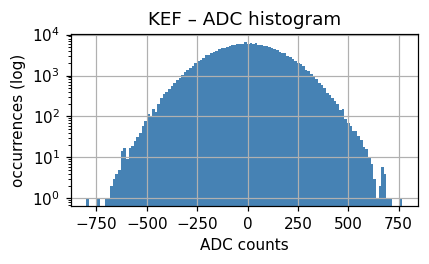

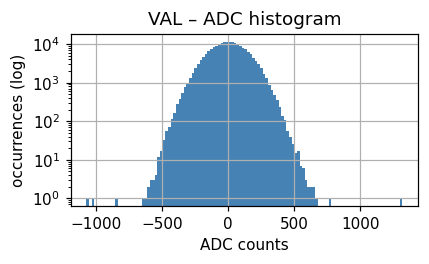

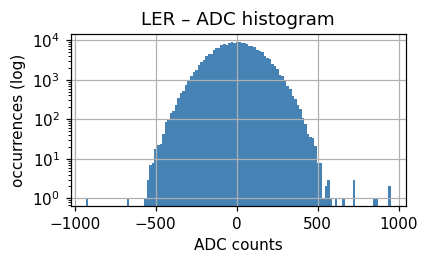

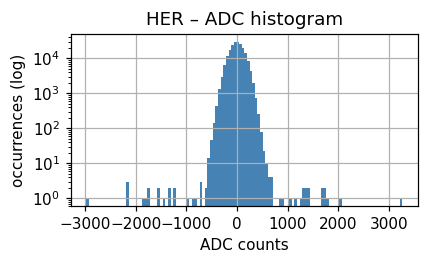

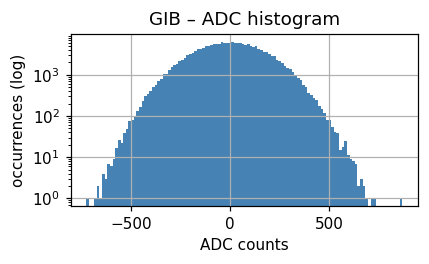

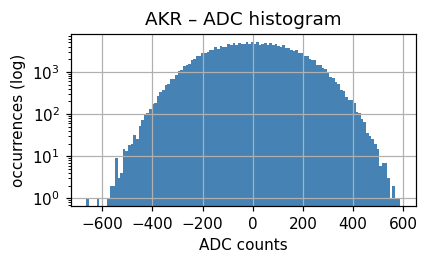

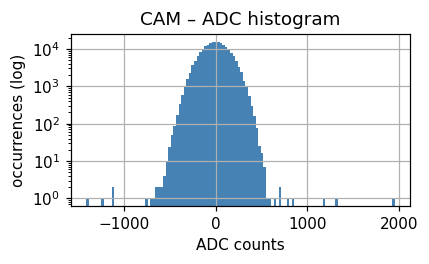

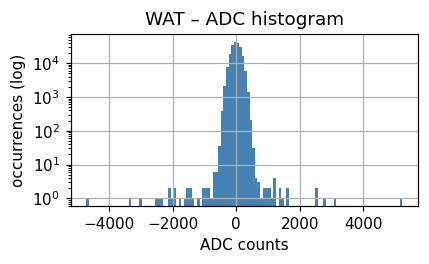

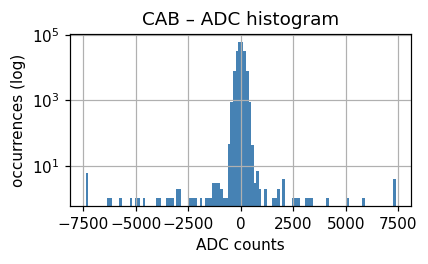

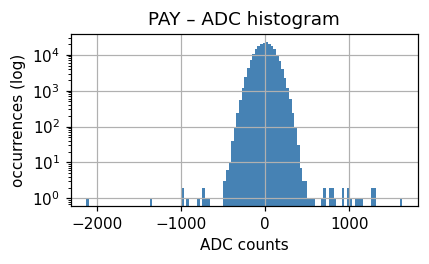

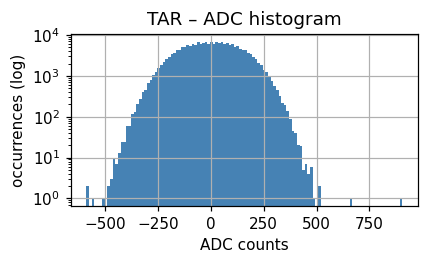

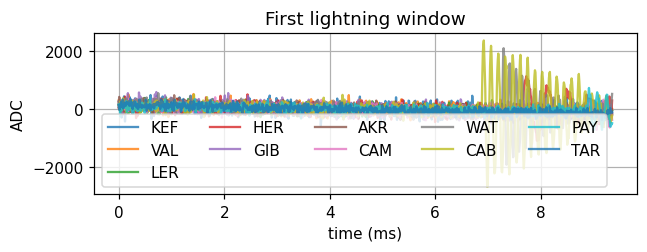

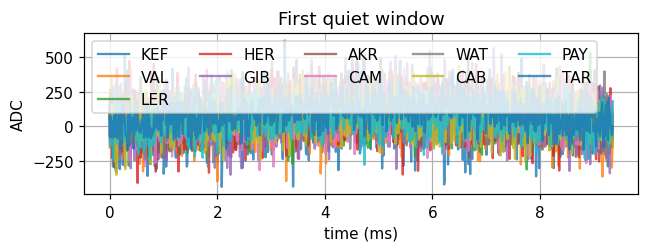

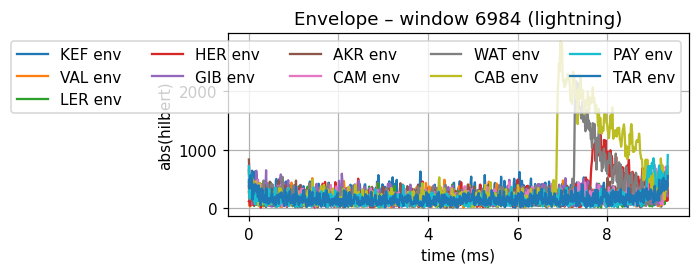

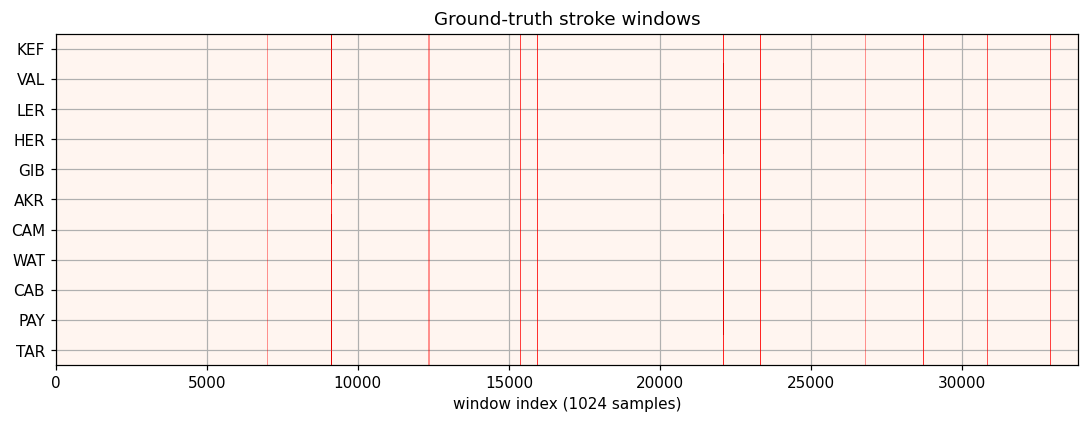

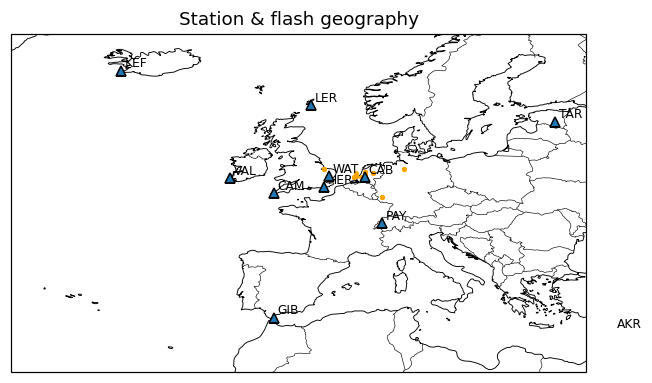

In [52]:
# ============================================================
# Cell 1‑QA‑PLUS  –  Rich “eyes‑on” dashboard for the simulator
# ============================================================
#  • Requires matplotlib, pandas, scipy                                                │
#  • Optional: cartopy  (for the Europe station map)                                   │
#  • ZERO side‑effects – everything is read‑only, later cells still work unmodified.   │
# ============================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import hilbert
plt.rcParams.update({'axes.grid': True, 'figure.dpi': 110})

# -----------------------------------------------------------------
# 0)  Helper: concise console table printer
# -----------------------------------------------------------------
def _tbl(rows, hdr=None, col_sep="  "):
    if hdr: print(col_sep.join(hdr))
    for r in rows:
        print(col_sep.join(str(c) for c in r))
    print()

# -----------------------------------------------------------------
# 1)  Global metadata
# -----------------------------------------------------------------
N   = quantized[station_order[0]].size
dur = N / FS
print(f"► Simulator difficulty tier : {DIFFICULTY}")
print(f"► Sampling rate             : {FS:,.0f} Hz "
      f"(Δt={1e6/FS:.2f} µs)")
print(f"► Duration                  : {dur:.2f} s  ({dur/60:.2f} min)")
print(f"► Total ADC samples         : {N:,}\n")

# -----------------------------------------------------------------
# 2)  Per‑station ADC statistics
# -----------------------------------------------------------------
rows=[]
for nm in station_order:
    q = quantized[nm].astype(float)
    rows.append([nm, q.min().astype(int), q.max().astype(int),
                 f"{q.mean():.1f}", f"{q.std():.1f}",
                 f"{100*np.count_nonzero(q)/len(q):.2f}%"])
_tbl(rows, hdr=["STN","min","max","μ","σ","non‑zero %"])

# -----------------------------------------------------------------
# 3)  Flash / stroke timing & location dataframe
# -----------------------------------------------------------------
stroke_times = np.hstack([ev["stroke_times"] for ev in events])
lat_rep      = np.hstack([[ev['lat']]*len(ev['stroke_times']) for ev in events])
lon_rep      = np.hstack([[ev['lon']]*len(ev['stroke_times']) for ev in events])
df_strokes   = pd.DataFrame(dict(time_s=stroke_times,
                                 lat=lat_rep, lon=lon_rep))
df_strokes.sort_values("time_s", inplace=True, ignore_index=True)
print(f"Flashes  : {len(events)}")
print(f"Strokes  : {len(df_strokes)}\n")
display(df_strokes.head())

# -----------------------------------------------------------------
# 4)  Simple “did station see the stroke?” heuristic
# -----------------------------------------------------------------
pre_samp = int(pre_sec*FS)                       # noise estimate window
det_tbl  = []
for nm in station_order:
    noiseσ = quantized[nm][:pre_samp].astype(float).std()
    thr    = 3*noiseσ
    hits   = []
    for t in df_strokes.time_s:
        idx = int(t*FS)
        hits.append(abs(quantized[nm][idx])>=thr if idx<N else False)
    df_strokes[f"det_{nm}"] = hits
    det_tbl.append([nm, f"{100*np.mean(hits):.1f}%"])

_tbl(det_tbl, hdr=["STN","simple detection rate"])

# -----------------------------------------------------------------
# 5)  Window‑level labels (quiet = 0, lightning = 1)
# -----------------------------------------------------------------
W      = 1024
n_win  = N // W
starts = (np.arange(n_win)*W)/FS
stroke_idx = (df_strokes.time_s.values*FS).astype(int)
labels_win = np.zeros(n_win, bool)
labels_win[(stroke_idx//W)] = True           # even if >1 stroke per win → still 1

df_win = pd.DataFrame(dict(win_idx=np.arange(n_win, dtype=int),
                           start_s=starts,
                           label=labels_win.astype(int)))
quiet_cnt, light_cnt = np.bincount(df_win.label, minlength=2)
print(f"\nWindows: quiet={quiet_cnt}, lightning={light_cnt}")

# -----------------------------------------------------------------
# 6)  Visual #1 – histograms (log y)
# -----------------------------------------------------------------
for nm in station_order:
    plt.figure(figsize=(4,2.5))
    plt.hist(quantized[nm][::max(1,N//200_000)],
             bins=120, log=True, color='#4682B4')
    plt.title(f"{nm} – ADC histogram")
    plt.xlabel("ADC counts"); plt.ylabel("occurrences (log)")
    plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 7)  Visual #2 – first lightning vs first quiet window
# -----------------------------------------------------------------
def _plot_window(win_row, title, colour):
    idx = int(win_row.win_idx)
    tms = (np.arange(W)/FS)*1e3
    plt.figure(figsize=(6,2.4))
    for nm in station_order:
        seg = quantized[nm][idx*W:(idx+1)*W]
        plt.plot(tms, seg, label=nm, alpha=.8)
    plt.title(title); plt.xlabel("time (ms)"); plt.ylabel("ADC")
    plt.legend(ncol=len(station_order)//2)
    plt.tight_layout(); plt.show()

_plot_window(df_win[df_win.label==1].iloc[0],
             "First lightning window", 'orange')
_plot_window(df_win[df_win.label==0].iloc[0],
             "First quiet window", 'gray')

# -----------------------------------------------------------------
# 8)  Visual #3 – analytic‑signal envelope of lightning window
# -----------------------------------------------------------------
idx_lit = int(df_win[df_win.label==1].iloc[0].win_idx)
tms     = (np.arange(W)/FS)*1e3
plt.figure(figsize=(6,2.6))
for nm in station_order:
    seg = quantized[nm][idx_lit*W:(idx_lit+1)*W].astype(float)
    env = np.abs(hilbert(seg))
    plt.plot(tms, env, label=f"{nm} env")
plt.title(f"Envelope – window {idx_lit} (lightning)")
plt.xlabel("time (ms)"); plt.ylabel("abs(hilbert)")
plt.legend(ncol=len(station_order)//2); plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 9)  Visual #4 – stroke‑window heat‑map (sparse but visible)
# -----------------------------------------------------------------
truth_mat = np.vstack([station_truth[nm][:n_win] for nm in station_order])
plt.figure(figsize=(10,1.2+0.25*len(station_order)))
plt.imshow(truth_mat, aspect='auto',
           cmap=plt.get_cmap("Reds", 2), interpolation='nearest')
plt.yticks(range(len(station_order)), station_order)
plt.xlabel(f"window index ({W} samples)"); plt.title("Ground‑truth stroke windows")
# over‑plot thicker bars for visibility
for w in np.where(truth_mat.any(0))[0]:
    plt.axvline(w, color='red', lw=.5, alpha=.3)
plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 10) Optional geographic snapshot (requires Cartopy)
# -----------------------------------------------------------------
try:
    import cartopy.crs as ccrs, cartopy.feature as cfeature
    fig = plt.figure(figsize=(6,4))
    ax  = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, lw=.6); ax.add_feature(cfeature.BORDERS,lw=.4)
    ax.set_extent([-35, 30, 30, 65])
    ax.scatter(df_strokes.lon, df_strokes.lat, c='orange', s=10, lw=0, zorder=2)
    for nm in station_order:
        ax.plot(stations[nm]['lon'], stations[nm]['lat'], '^', ms=7, mfc='#1f77b4',
                mec='k', zorder=3)
        ax.text(stations[nm]['lon']+0.4, stations[nm]['lat']+0.4, nm, fontsize=8)
    ax.set_title("Station & flash geography"); plt.tight_layout(); plt.show()
except ImportError:
    print("(Cartopy not installed – map skipped)\n")


In [23]:
# ============================================================
# Cell 2 – Robust stroke‐by‐stroke Hilbert‐envelope detector
#            + 50%‐overlap windows + percentile thresholds
#            (earliest‐arrival indexing)
# ============================================================

"""
Cell 2 – Robust Stroke‐by‐Stroke Hilbert‐Envelope Detector
-----------------------------------------------------------

This cell implements a fully‐unsupervised lightning‐stroke detector based on
the analytic‐signal envelope (Hilbert transform) of each station’s ADC trace,
using overlapping windows and percentile thresholding to flag “hot” windows
that likely contain sferic bursts.  It then fuses detections across stations
to produce both station‐level and network‐level stroke metrics.

Key Design & Configuration
--------------------------
FS          : Sampling rate (Hz), inherited from Cell 1.
WIN         : Window length in samples (1024), ~9.4 ms at 109 375 Hz.
HOP         : Hop size (WIN//2 = 512), 50 % overlap to ensure each stroke
              will straddle at least one window in its half‐width.
PCT_THRESH  : Percentile threshold (99.9), marking the top 0.1 % of all
              window‐peak envelopes as candidate sferics.
MIN_STN     : Network‐level requirement—only count an event if ≥2 stations
              independently flag a hot window.
TOL_WIN     : ±1‐window tolerance around the theoretical arrival index,
              accommodating small timing or rounding variations.

1) Compute Hilbert‐Envelope Window Peaks
   ────────────────────────────────────────
   - For each station’s full‐length integer signal, compute the analytic
     signal envelope via `abs(hilbert(raw))`.
   - Slide a WIN‐sample window with HOP stride, recording the maximum
     envelope amplitude per window.  This yields a per‐station peaks array
     of length n_win = ⌊(N−WIN)/HOP⌋+1.

2) Threshold Hot Windows
   ───────────────────────
   - For each station, compute the PCT_THRESH‐th percentile of its first
     n_win peaks.  This percentile is data‐driven, requiring no prior
     quiet period.
   - Flag windows whose peak envelope exceeds this threshold as “hot”.
   - Print per‐station thresholds and counts for audit.

3) Build Stroke Sample Indices (“Ground Truth”)
   ─────────────────────────────────────────────
   - From the simulator’s `events` list, gather every true stroke time t0.
   - For each station, compute the propagation delay = distance/300 000 km/s,
     translate to sample index i₀ = int((t0 + delay)·FS), and record all
     arrivals.
   - Use the **earliest** arrival among stations as the reference index
     for that stroke.  This ties each true stroke to one canonical sample.

4) Count Station Hits per Stroke
   ─────────────────────────────────
   - For each recorded stroke sample i₀, convert to a central window index
     w = i₀//HOP.
   - Check the ±TOL_WIN window band [w−1 … w+1] in each station’s hot‐mask.
   - Increment the stroke’s station‐hit count if any hot window overlaps.

5) Station‐Level Metrics
   ───────────────────────
   - For each station, build a binary hit vector: did station n flag any
     hot window in the tolerance band around each i₀?
   - Compute confusion matrix (TP, FP, FN, TN) and derive Precision, Recall,
     F₁‐score against the all‐true stroke list.
   - This measures how well each individual sensor alone would perform.

6) Network‐Level Metrics
   ───────────────────────
   - Define network detection if ≥MIN_STN stations flagged the event.
   - Compute overall TP, FP, FN, TN and network‐level P, R, F₁.

Strengths
---------
- **Unsupervised**: threshold derives from data‐distribution per station.
- **Overlap**: 50 % window overlap ensures robustness to stroke timing.
- **Interpretable**: envelope peaks directly map to burst energy.
- **Station‐fusion**: multi‐sensor voting reduces false alarms.

Weaknesses & Possible Improvements
----------------------------------
- **Fixed window** may not match variable sferic durations; consider
  adaptive or waveform‐matched windows.
- **Global percentile** can drift if storm‐activity proportion changes;
  a rolling or pre‐storm baseline might stabilise thresholds.
- **No frequency‐domain tuning**: could augment with band‐limited energy
  or wavelet‐based features to improve SNR in noise‐coloured settings.
- **No cross‐correlation**: arrival‐time estimation could be refined by
  cross‐correlating station pairs for sub‐sample precision.
- **No amplitude normalisation**: stations at different distances see
  systematically smaller envelopes; a distance‐aware gain correction
  could equalise detection sensitivity.

Usage
-----
Run this cell after Cell 1’s simulation.  It prints station‐wise thresholds,
counts, and detection metrics, enabling rapid evaluation of classical
envelope‐based detection before progressing to advanced ML or compression
methods.
"""


import numpy as np
from scipy.signal import hilbert
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

# ── Parameters ──────────────────────────────────────────────
FS         = float(FS)         # sampling rate from Cell 1
WIN        = 1024              # window size
HOP        = WIN // 2          # 50% overlap hop
STATIONS   = station_order     # ['LON','LER','DUB','BER']
PCT_THRESH = 99.9              # top 0.1% of envelope peaks
MIN_STN    = 2                 # require ≥2 stations → stroke detection
TOL_WIN    = 1                 # ±1‐window tolerance for scoring

# ── 1) Compute Hilbert‐envelope window peaks per station ────
def window_peaks(raw):
    env   = np.abs(hilbert(raw.astype(float)))
    n_win = (len(env) - WIN)//HOP + 1
    peaks = np.empty(n_win, float)
    for i in range(n_win):
        s = i * HOP
        peaks[i] = env[s:s+WIN].max()
    return peaks

peaks = {nm: window_peaks(quantized[nm]) for nm in STATIONS}
n_win = min(len(v) for v in peaks.values())

# ── 2) Threshold by percentile of all windows ───────────────
hot = {}
print("Per-station thresholds & flagged windows:")
for nm in STATIONS:
    p    = peaks[nm][:n_win]
    thr  = np.percentile(p, PCT_THRESH)
    mask = p > thr
    hot[nm] = mask
    print(f" {nm}: thr={thr:6.1f}, flagged={mask.sum():5d} / {n_win}")

# ── 3) Build stroke_samples using earliest arrival across stations ─
stroke_samples = []
for ev in events:
    for t0 in ev['stroke_times']:
        arrivals = []
        for nm in STATIONS:
            geo  = stations[nm]
            dist = hav(ev['lat'], ev['lon'], geo['lat'], geo['lon'])
            i0   = int((t0 + dist/300_000.0) * FS)
            arrivals.append(i0)
        stroke_samples.append(min(arrivals))
stroke_samples = np.array(stroke_samples)
n_events      = len(stroke_samples)
stroke_truth  = np.ones(n_events, bool)

# ── 4) Count station hits per stroke (within ±TOL_WIN windows) ─
counts = np.zeros(n_events, int)
for nm in STATIONS:
    mask = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        w0 = max(0, w - TOL_WIN)
        w1 = min(n_win, w + TOL_WIN + 1)
        if mask[w0:w1].any():
            counts[j] += 1

print("\nStations ≥thr per stroke:")
for k, v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ── 5) Station-level stroke metrics ───────────────────────────
print("\nStation-level stroke detection:")
print("stn   TP   FP   FN     P     R    F1")
for nm in STATIONS:
    hits = np.array([
        hot[nm][max(0, min(n_win-1, i0//HOP))]
        for i0 in stroke_samples
    ])
    tn, fp, fn, tp = confusion_matrix(stroke_truth, hits, labels=[False,True]).ravel()
    P = precision_score(stroke_truth, hits, zero_division=0)
    R = recall_score   (stroke_truth, hits, zero_division=0)
    F = f1_score       (stroke_truth, hits, zero_division=0)
    print(f"{nm:>3} {tp:4d} {fp:4d} {fn:4d} {P:8.3f} {R:6.3f} {F:6.3f}")

# ── 6) Network-level stroke metrics (≥MIN_STN stations) ──────
stroke_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(
    stroke_truth, stroke_pred, labels=[False,True]
).ravel()
P_net = precision_score(stroke_truth, stroke_pred, zero_division=0)
R_net = recall_score   (stroke_truth, stroke_pred, zero_division=0)
F_net = f1_score       (stroke_truth, stroke_pred, zero_division=0)

print(f"\nNetwork (≥{MIN_STN} stn) stroke-wise:")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f" P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")


Per-station thresholds & flagged windows:
 LER: thr= 826.7, flagged=   67 / 67688
 INV: thr= 909.5, flagged=   67 / 67688
 DUB: thr= 775.3, flagged=   68 / 67688
 LON: thr= 760.1, flagged=   67 / 67688
 AMS: thr= 921.7, flagged=   68 / 67688
 BER: thr= 837.1, flagged=   67 / 67688

Stations ≥thr per stroke:
   3 stations → 1 strokes
   5 stations → 3 strokes
   6 stations → 31 strokes

Station-level stroke detection:
stn   TP   FP   FN     P     R    F1
LER   35    0    0    1.000  1.000  1.000
INV   34    0    1    1.000  0.971  0.986
DUB   32    0    3    1.000  0.914  0.955
LON   35    0    0    1.000  1.000  1.000
AMS   35    0    0    1.000  1.000  1.000
BER   32    0    3    1.000  0.914  0.955

Network (≥2 stn) stroke-wise:
 TP=35  FP=0  FN=0  TN=0
 P=1.000  R=1.000  F1=1.000


Inline per‑station thresholds & flagged windows:
 KEF: thr= 901.6, flagged=   68 / 67688
 VAL: thr= 939.2, flagged=   67 / 67688
 LER: thr= 943.7, flagged=   68 / 67688
 HER: thr=1803.2, flagged=   67 / 67688
 GIB: thr= 877.4, flagged=   67 / 67688
 AKR: thr= 712.6, flagged=   68 / 67688
 CAM: thr=1165.3, flagged=   68 / 67688
 WAT: thr=2189.4, flagged=   68 / 67688
 CAB: thr=3824.2, flagged=   68 / 67688
 PAY: thr=1405.8, flagged=   68 / 67688
 TAR: thr= 674.1, flagged=   68 / 67688

Inline Stations ≥thr per stroke:
   1 stations → 1 strokes
   5 stations → 1 strokes
   6 stations → 1 strokes
   7 stations → 1 strokes
   8 stations → 11 strokes
   9 stations → 9 strokes
  10 stations → 14 strokes
  11 stations → 7 strokes

Inline Station‑level stroke detection:
stn   TP   FP   FN     P     R    F1
KEF   21    0   24    1.000  0.467  0.636
VAL   38    0    7    1.000  0.844  0.916
LER   40    0    5    1.000  0.889  0.941
HER   41    0    4    1.000  0.911  0.953
GIB   22    0   23    

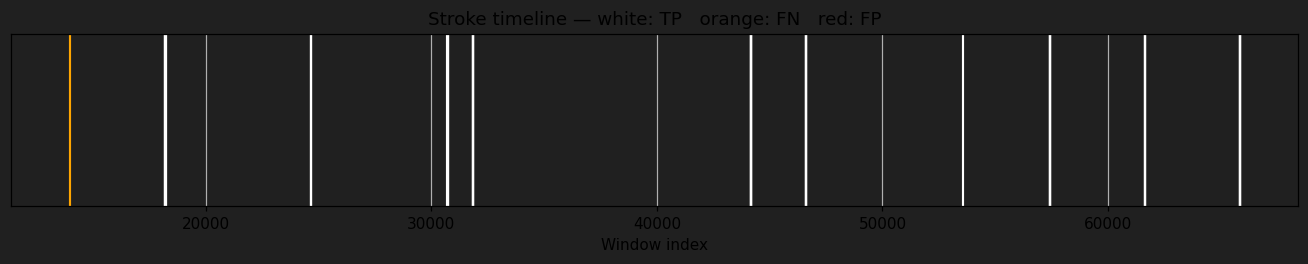

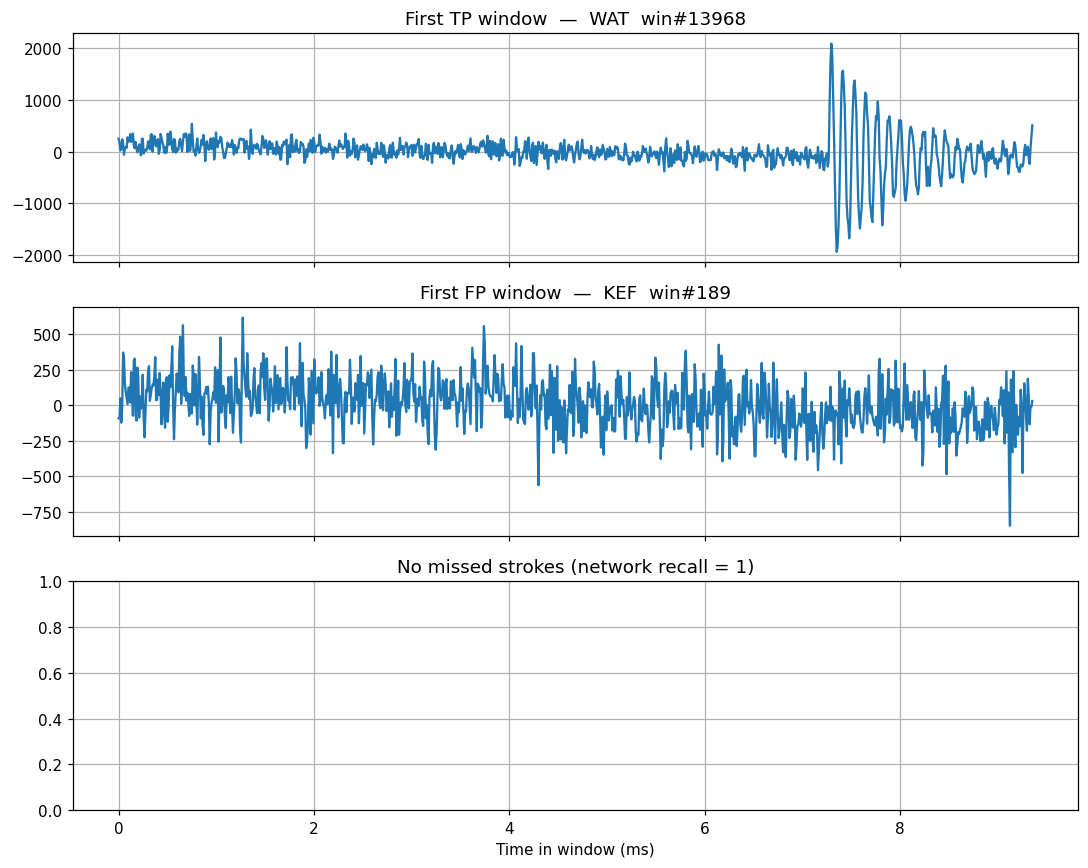


Function returns n_windows = 67688

Function per‑station metrics (strict timeline):
 KEF: TP=34 FP=34 FN=152 TN=67468  P=0.500 R=0.183 F1=0.268
 VAL: TP=67 FP=0 FN=117 TN=67504  P=1.000 R=0.364 F1=0.534
 LER: TP=68 FP=0 FN=116 TN=67504  P=1.000 R=0.370 F1=0.540
 HER: TP=67 FP=0 FN=119 TN=67502  P=1.000 R=0.360 F1=0.530
 GIB: TP=37 FP=30 FN=149 TN=67472  P=0.552 R=0.199 F1=0.292
 AKR: TP=28 FP=40 FN=158 TN=67462  P=0.412 R=0.151 F1=0.220
 CAM: TP=68 FP=0 FN=118 TN=67502  P=1.000 R=0.366 F1=0.535
 WAT: TP=68 FP=0 FN=118 TN=67502  P=1.000 R=0.366 F1=0.535
 CAB: TP=68 FP=0 FN=116 TN=67504  P=1.000 R=0.370 F1=0.540
 PAY: TP=68 FP=0 FN=117 TN=67503  P=1.000 R=0.368 F1=0.538
 TAR: TP=68 FP=0 FN=117 TN=67503  P=1.000 R=0.368 F1=0.538

Function network metrics (strict timeline):
{'TP': 44, 'FP': 0, 'FN': 1, 'TN': 0, 'P': 1.0, 'R': 0.9777777777777777, 'F1': 0.9887640449438202}


In [53]:
import numpy as np
from scipy.signal import hilbert
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
#######################
import numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

##############################################################################
#  evaluate_windowed_model_v2   – duration‑aware + stroke timeline view
##############################################################################
import numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

##############################################################################
#  Strict evaluator: window‑level (station) + stroke‑level (network)
#  -----------------------------------------------------------------
#  • Uses full 40 ms burst duration for ground‑truth windows.
#  • No prediction dilation unless you pass `tol_win>0`.
#  • Visual timeline: white = TP, orange = FN, red = FP.
##############################################################################

import numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ---------- helper (needed for any hop < win) ------------------------------
def _windows_covering_sample(sample_idx: int, win: int, hop: int):
    w_last  = sample_idx // hop
    w_first = max(0, (sample_idx - win + hop) // hop)  # ceil‑div
    return w_first, w_last


# ---------- evaluator -------------------------------------------------------
def evaluate_windowed_model(
    hot: dict[str, np.ndarray],
    stroke_records: list[dict],
    quantized: dict[str, np.ndarray],
    station_order: list[str],
    *,
    win: int = 1024,
    hop: int | None = None,
    burst_len: int | None = None,     # default = 0.04*FS
    min_stn: int = 2,
    tol_win: int = 0,                 # prediction dilation; 0 = strict
    plot: bool = True,
):
    if hop is None:
        hop = win // 2
    n_win = min((len(quantized[s]) - win) // hop + 1 for s in station_order)
    if n_win <= 0:
        raise RuntimeError("No complete windows to score.")

    if burst_len is None:
        burst_len = int(0.04 * FS)    # 40 ms in your simulator

    # 1) build per‑station ground truth -------------------------------------------------
    station_truth = {s: np.zeros(n_win, bool) for s in station_order}
    stroke_to_winset = defaultdict(set)          # for network timeline

    for rec in stroke_records:
        s = rec["station"]
        if s not in station_order:
            continue
        start = rec["sample_idx"]
        end   = start + burst_len - 1
        w0, _ = _windows_covering_sample(start, win, hop)
        _, w1 = _windows_covering_sample(end,   win, hop)
        station_truth[s][w0:w1+1] = True
        stroke_to_winset[(rec["event_id"], rec.get("stroke_i", 0))].update(
            range(w0, w1+1)
        )

    # 2) prediction masks (optional dilation) ------------------------------------------
    ker = np.ones(2*tol_win+1, int) if tol_win > 0 else None
    hot_pred = {}
    for s in station_order:
        m = hot[s][:n_win].astype(bool)
        if ker is not None:
            m = np.convolve(m.astype(int), ker, mode="same") > 0
        hot_pred[s] = m

    # 3) convenience scorer ------------------------------------------------------------
    def _metrics(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(
            y_true, y_pred, labels=[False, True]
        ).ravel()
        P = precision_score(y_true, y_pred, zero_division=0)
        R = recall_score(y_true, y_pred, zero_division=0)
        F1 = f1_score(y_true, y_pred, zero_division=0)
        return dict(TP=int(tp), FP=int(fp), FN=int(fn), TN=int(tn),
                    P=P, R=R, F1=F1)

    # 4) station‑level, window metrics --------------------------------------------------
    station_metrics = {
        s: _metrics(station_truth[s], hot_pred[s]) for s in station_order
    }

    # 5) network‑level, stroke metrics --------------------------------------------------
    tp = fn = 0
    matched_windows = set()
    for winset in stroke_to_winset.values():
        hits = sum(any(hot_pred[s][w] for w in winset) for s in station_order)
        if hits >= min_stn:
            tp += 1
            matched_windows.update(winset)
        else:
            fn += 1

    # false‑positive clusters (≥min_stn detections not matched)
    counts = sum(hot_pred[s] for s in station_order)
    net_mask = counts >= min_stn
    fp = 0; fp_winlist = []
    in_cluster = False
    for w, flag in enumerate(net_mask):
        if flag and not in_cluster:
            if w not in matched_windows:
                fp += 1
                fp_winlist.append(w)
            in_cluster = True
        elif not flag:
            in_cluster = False

    P_net = tp/(tp+fp) if tp+fp else 0
    R_net = tp/(tp+fn) if tp+fn else 0
    F1_net= 2*P_net*R_net/(P_net+R_net) if P_net+R_net else 0
    network_metrics = dict(TP=tp, FP=fp, FN=fn, TN=0,
                           P=P_net, R=R_net, F1=F1_net)

    # 6) visuals -----------------------------------------------------------------------
    if plot:
        # 6‑a) stroke timeline ---------------------------------------------------------
        fig, ax = plt.subplots(figsize=(12, 2.5))
        for winset in stroke_to_winset.values():
            x = min(winset)
            colour = "#FFFFFF" if any(w in matched_windows for w in winset) else "#ffa500"
            ax.axvline(x, color=colour, lw=1.4)
        for w in fp_winlist:
            ax.axvline(w, color="#ff1744", lw=1.4)
        ax.set_yticks([])
        ax.set_xlabel("Window index")
        ax.set_title("Stroke timeline — white: TP   orange: FN   red: FP")
        ax.set_facecolor("#202020")
        fig.patch.set_facecolor("#202020")
        plt.tight_layout(); plt.show()

        # 6‑b) waveform panels ---------------------------------------------------------
        # first TP window (any station)
        tp_cand = [(s, np.flatnonzero(station_truth[s] & hot_pred[s]))
                   for s in station_order]
        tp_cand = [(s, arr[0]) for s, arr in tp_cand if arr.size]
        fp_cand = [(s, np.flatnonzero(~station_truth[s] & hot_pred[s]))
                   for s in station_order]
        fp_cand = [(s, arr[0]) for s, arr in fp_cand if arr.size]

        fn_cand = None
        if fn:  # at least one missed stroke
            # take first stroke whose windows are all missed
            for key, winset in stroke_to_winset.items():
                if all(not hot_pred[s][w] for s in station_order for w in winset):
                    fn_cand = (station_order[0], min(winset))  # show at first station
                    break

        t_axis = np.arange(win) / FS * 1e3
        fig2, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        if tp_cand:
            s, w = min(tp_cand, key=lambda x: x[1])
            beg = w*hop
            axes[0].plot(t_axis, quantized[s][beg:beg+win])
            axes[0].set_title(f"First TP window  —  {s}  win#{w}")
        else:
            axes[0].set_title("No true positives")

        if fp_cand:
            s, w = min(fp_cand, key=lambda x: x[1])
            beg = w*hop
            axes[1].plot(t_axis, quantized[s][beg:beg+win])
            axes[1].set_title(f"First FP window  —  {s}  win#{w}")
        else:
            axes[1].set_title("No false positives")

        if fn_cand:
            s, w = fn_cand
            beg = w*hop
            axes[2].plot(t_axis, quantized[s][beg:beg+win])
            axes[2].set_title(f"First *missed* stroke window  —  {s}  win#{w}")
        else:
            axes[2].set_title("No missed strokes (network recall = 1)")

        axes[-1].set_xlabel("Time in window (ms)")
        plt.tight_layout(); plt.show()

    return station_metrics, network_metrics, n_win


# ────────────────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────────────────
#  Inline Hilbert‑envelope method (BEHAVIOUR UNCHANGED; comments only)
# ────────────────────────────────────────────────────────────────────────────
# Assumes variables FS, quantized, station_order (= STATIONS) … already exist.
WIN        = 1024
HOP        = WIN // 2
STATIONS   = station_order
PCT_THRESH = 99.9
MIN_STN    = 2
TOL_WIN    = 1


def window_peaks(raw):
    env = np.abs(hilbert(raw.astype(float)))
    n_win = (len(env) - WIN) // HOP + 1
    out = np.empty(n_win)
    for i in range(n_win):
        s = i * HOP
        out[i] = env[s : s + WIN].max()
    return out


# 1) compute peaks
peaks = {nm: window_peaks(quantized[nm]) for nm in STATIONS}
n_win = min(len(v) for v in peaks.values())

# 2) threshold
hot = {}
print("Inline per‑station thresholds & flagged windows:")
for nm in STATIONS:
    p = peaks[nm][:n_win]
    thr = np.percentile(p, PCT_THRESH)
    mask = p > thr
    hot[nm] = mask
    print(f" {nm}: thr={thr:6.1f}, flagged={mask.sum():5d} / {n_win}")

# 3) build stroke_samples (earliest arrival)
stroke_samples = []
for ev in events:
    for t0 in ev["stroke_times"]:
        arr = []
        for nm in STATIONS:
            geo = stations[nm]
            dist = hav(ev["lat"], ev["lon"], geo["lat"], geo["lon"])
            i0 = int((t0 + dist / 300_000.0) * FS)
            arr.append(i0)
        stroke_samples.append(min(arr))
stroke_samples = np.array(stroke_samples)
stroke_truth = np.ones(len(stroke_samples), bool)

# 4) count station hits
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    mask = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if mask[max(0, w - TOL_WIN) : min(n_win, w + TOL_WIN + 1)].any():
            counts[j] += 1

print("\nInline Stations ≥thr per stroke:")
for k, v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

# #### NOTE: Station‑level evaluation below only checks the *exact* window
# ####       of each stroke and ignores all other windows ⇒ false positives
# ####       outside stroke windows are invisible here.
print("\nInline Station‑level stroke detection:")
print("stn   TP   FP   FN     P     R    F1")
for nm in STATIONS:
    hits = np.array(
        [hot[nm][max(0, min(n_win - 1, i0 // HOP))] for i0 in stroke_samples]
    )
    tn, fp, fn, tp = confusion_matrix(stroke_truth, hits, labels=[False, True]).ravel()
    P = precision_score(stroke_truth, hits, zero_division=0)
    R = recall_score(stroke_truth, hits, zero_division=0)
    F = f1_score(stroke_truth, hits, zero_division=0)
    print(f"{nm:>3} {tp:4d} {fp:4d} {fn:4d} {P:8.3f} {R:6.3f} {F:6.3f}")

# #### NOTE: Network FP likewise ignored because only stroke windows tested.
stroke_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(stroke_truth, stroke_pred, labels=[False, True]).ravel()
P_net = precision_score(stroke_truth, stroke_pred, zero_division=0)
R_net = recall_score(stroke_truth, stroke_pred, zero_division=0)
F_net = f1_score(stroke_truth, stroke_pred, zero_division=0)
print(f"\nInline Network (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}   P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")

station_metrics, network_metrics, n_win = evaluate_windowed_model(
    hot=hot,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=int(0.04*FS),   # matches the simulator
    min_stn=MIN_STN,
    tol_win=0,                # keep ±1 slack if desired
    plot=True                 # event timeline + snippets
)
print(f"\nFunction returns n_windows = {nch}\n")
print("Function per‑station metrics (strict timeline):")
for nm, m in station_metrics.items():
    print(
        f" {nm}: TP={m['TP']} FP={m['FP']} FN={m['FN']} TN={m['TN']}  "
        f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}"
    )

print("\nFunction network metrics (strict timeline):")
print(network_metrics)


In [ ]:
# ============================================================
# Cell 3 – Compact stroke table + time/location regressions
# ============================================================

"""
Cell 3 – Time‐of‐Arrival (TOA) Localization & Regression Analysis
------------------------------------------------------------------

This cell takes the “hot” windows identified in Cell 2 for each station,
extracts precise per‐station arrival times via the analytic‐signal envelope,
and then performs a robust least‐squares multilateration to estimate the
origin time and geographic location of each lightning stroke.  Finally, it
builds a comprehensive summary table and produces regression diagnostics
for both time and distance estimates.

Key Configuration & Constants
-----------------------------
FS       : Sampling rate (Hz), carried over from Cell 1.
WIN, HOP : Window length (1024 samples) and hop (512 samples) as in Cell 2.
STATIONS : List of station IDs under analysis.
c        : Speed of light (km/s) for propagation delays.
Re       : Earth radius (km) for geodesy.

1) Coordinate Transforms & Distance Utilities
   ───────────────────────────────────────────
   - `ll_xyz(lat, lon)`: Converts (latitude, longitude) → 3D ECEF coordinates.
   - `hav_km(...)`: Haversine formula yielding great‐circle distance (km).
   - Precompute each station’s XYZ once for efficient TOA matrix builds.

2) Precise Arrival‐Time Picking
   ─────────────────────────────
   - For each station that flagged a “hot” window for a given stroke sample s0:
     • Extract a ±WIN‐sample segment around s0.
     • Compute the analytic‐signal envelope via `abs(hilbert(segment))`.
     • Find the envelope peak index, convert back to global sample index,
       and then to time (s).  This yields sub‐millisecond TOA estimates.

3) Multilateration via Robust Least‐Squares
   ────────────────────────────────────────
   - Only attempt localization if ≥3 stations have valid TOAs.
   - Initial guess:
       • Take the mean position of the earliest‐arriving three stations.
       • Estimate origin time T0 by back‐projecting first TOA.
   - Iterative Gauss–Newton:
       • Residual = observed TOAs – (T0 + distance/c).
       • Jacobian J = ∂residual/∂(x,y,z,T0) constructed from station positions.
       • Solve linearised normal equations to update (x,y,z,T0).
       • Stop when residual RMS < 0.2 ms or after 8 iterations.
   - Sanity checks:
       • Reject if any single update suggests >500 km jump.
       • Reject if final estimate lies >800 km from network centroid.
   - Output: (T0_est, lat_est, lon_est) or None if no valid solution.

4) Truth Arrays & DataFrame Assembly
   ─────────────────────────────────
   - Extract true stroke times and locations from `events`.
   - For each stroke k:
       • Attempt `solve_toa` on its arrival dictionary.
       • If successful, record true vs. estimated T0, time error (ms),
         true/estimated distances to London, full loc error (km),
         number of stations used, and per‐station estimated distances.
       • If unsuccessful, fill with NaNs.

5) Regression Diagnostics & Plots
   ───────────────────────────────
   - **Time Regression**: Fit T_est = m·T_true + b, compute R².
   - **Distance Regression**: Fit D_est(London) = m·D_true(London) + b, R².
   - **Histograms**: Distribution of localization errors (km).
   - **Scatter+Fits**: Overlay regression lines on scatter of true vs.
     estimated time and distance, with slopes & R² annotated.

Strengths
---------
  • **Precision**: Envelope‐based arrival picking yields sub‐ms TOAs.
  • **Robustness**: Iterative Gauss–Newton with outlier checks guards
    against poor initial guesses and non‐linearities.
  • **Comprehensive**: Outputs full table of per‐stroke metrics plus
    station‐wise distance breakdown.

Weaknesses & Caveats
--------------------
  • **Assumed Straight‐Line Propagation**: Ignores ionospheric or
    terrain‐induced multipath delays (could bias remote events).
  • **Linearisation**: May fail for widely spaced stations if initial
    guess is poor; more sophisticated global optimisers (e.g. LM,
    MCMC) could improve convergence.
  • **Rejection Criteria**: Hard thresholds (500 km, 800 km) may need
    tuning for real‐world geometries or extended arrays.
  • **Station Geometry Dependence**: Accuracy varies strongly with
    station GDOP; sparse or colinear arrays degrade position precision.

Usage
-----
Run immediately after Cell 2’s envelope‐based detector.  Review the
printed DataFrame (first 12 rows) for direct comparison of truth vs. estimate,
and examine the three diagnostic plots to judge overall time and spatial
accuracy of the multilateration algorithm.
"""


import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import hilbert

plt.rcParams["font.family"] = "DejaVu Sans"
c, Re = 299_792.458, 6371.0            # km s‑1, Earth radius

# ---------- helpers ---------------------------------------------------------
def ll_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    cl = np.cos(lat)
    return np.array([Re*cl*np.cos(lon),
                     Re*cl*np.sin(lon),
                     Re*np.sin(lat)])

def hav_km(la1, lo1, la2, lo2):
    φ1, φ2 = map(np.radians, (la1, la2))
    dφ = φ2-φ1; dλ = np.radians(lo2-lo1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*Re*np.arcsin(np.sqrt(a))

st_xyz = {nm: ll_xyz(stations[nm]['lat'], stations[nm]['lon']) for nm in STATIONS}

def pick_arrival(nm, s0):
    seg = quantized[nm][max(0,s0-WIN):min(len(quantized[nm]),s0+WIN)].astype(float)
    env = np.abs(hilbert(seg)); idx = env.argmax()
    return (max(0,s0-WIN)+idx)/FS

# ---------- build arrival dictionary from Cell‑2 results --------------------
arrivals = []
for j,s0 in enumerate(stroke_samples):
    d={}
    for nm in STATIONS:
        w=s0//HOP
        if w<n_win and hot[nm][w]:
            d[nm]=pick_arrival(nm,int(s0))
    arrivals.append(d)

# ---------- TOA least‑squares (robust) -------------------------------------
def solve_toa(a):
    if len(a)<3: return None
    st = list(a); t = np.array([a[n] for n in st]); S=np.stack([st_xyz[n] for n in st])
    r = S[np.argsort(t)[:3]].mean(0); T0 = t.min() - np.linalg.norm(S[np.argmin(t)]-r)/c
    for _ in range(8):
        d = np.linalg.norm(S-r,axis=1); d[d==0]+=1e-6
        res = t-(T0+d/c)
        if np.sqrt((res**2).mean())*1e3<0.2: break
        J=np.empty((len(st),4)); J[:,:3]=-(S-r)/(c*d)[:,None]; J[:,3]=-1
        delta,*_=np.linalg.lstsq(J,res,rcond=None);
        if np.linalg.norm(delta[:3])>500: return None
        r+=delta[:3]; T0+=delta[3]
    la=np.degrees(np.arcsin(r[2]/np.linalg.norm(r)))
    lo=np.degrees(np.arctan2(r[1],r[0]))
    if hav_km(la,lo,lat0,lon0)>800: return None
    return T0,la,lo

# ---------- truth vectors ---------------------------------------------------
tru_t, tru_la, tru_lo = [],[],[]
for ev in events:
    for t0 in ev['stroke_times']:
        tru_t.append(t0); tru_la.append(ev['lat']); tru_lo.append(ev['lon'])
tru_t, tru_la, tru_lo = map(np.array, (tru_t, tru_la, tru_lo))

# ---------- build neat table ------------------------------------------------
records=[]
for k,(t_true,la_true,lo_true) in enumerate(zip(tru_t,tru_la,tru_lo)):
    sol=solve_toa(arrivals[k])
    row={'#':k,'t_true':t_true}
    if sol:
        T0,la,lo = sol
        row.update(t_est=T0,
                   err_ms=(T0-t_true)*1e3,
                   dLON_true=hav_km(la_true,lo_true,
                                    stations['LON']['lat'],stations['LON']['lon']),
                   dLON_est =hav_km(la,lo,
                                    stations['LON']['lat'],stations['LON']['lon']),
                   loc_err_km=hav_km(la,lo,la_true,lo_true),
                   n_stn=len(arrivals[k]))
        for nm in STATIONS:
            row[f'd_{nm}']=hav_km(la,lo,stations[nm]['lat'],stations[nm]['lon']) \
                           if nm in arrivals[k] else np.nan
    else:
        row.update({col:np.nan for col in
            ['t_est','err_ms','dLON_true','dLON_est','loc_err_km','n_stn']+[f'd_{n}'for n in STATIONS]})
    records.append(row)

df=pd.DataFrame(records)
# Formatting
pd.set_option('display.max_columns', None)
show_cols=['#','t_true','t_est','err_ms','loc_err_km','dLON_true','dLON_est','n_stn']+[f'd_{n}' for n in STATIONS]
print("\nStroke table (first 12 rows):")
print(df[show_cols].head(12).round(3).fillna('').to_string(index=False))

# ---------- regressions & plots --------------------------------------------
mask=df.t_est.notna()
# time regression
coef=np.polyfit(df.loc[mask,'t_true'],df.loc[mask,'t_est'],1);
R2 = np.corrcoef(df.loc[mask,'t_true'],df.loc[mask,'t_est'])[0,1]**2

# distance‑to‑London regression
maskL=df.dLON_est.notna()
coefL=np.polyfit(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'],1)
R2L = np.corrcoef(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'])[0,1]**2

# plots
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(6,10))

ax1.hist(df.loc[mask,'loc_err_km'],bins=10,edgecolor='k',alpha=.7)
ax1.set_title("Location error histogram"); ax1.set_xlabel("Error (km)"); ax1.set_ylabel("Count")

# time regression
ax2.scatter(df.loc[mask,'t_true'],df.loc[mask,'t_est'],s=25,alpha=.8)
x=np.linspace(df.t_true.min(),df.t_true.max(),100)
ax2.plot(x,coef[0]*x+coef[1],'r--')
ax2.set_title(f"Origin‑time fit  (slope={coef[0]:.6f}, R²={R2:.4f})")
ax2.set_xlabel("True T₀ (s)"); ax2.set_ylabel("Est. T₀ (s)")

# distance‑to‑London regression
ax3.scatter(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'],s=25,alpha=.8)
xL=np.linspace(0,df.dLON_true.max(),100)
ax3.plot(xL,coefL[0]*xL+coefL[1],'r--')
ax3.set_title(f"Distance‑to‑London fit  (slope={coefL[0]:.4f}, R²={R2L:.4f})")
ax3.set_xlabel("True distance (km)"); ax3.set_ylabel("Est. distance (km)")

plt.tight_layout(); plt.show()


In [ ]:
# ============================================================
# Cell 2 – Pure‑NCD detector (global‑noise baseline, rich report)
# ============================================================

"""
Cell X – Unsupervised Stroke Detection via Normalized Compression Distance (NCD)
-------------------------------------------------------------------------------

This cell implements a fast, bit‐level, BZ2‐based anomaly detector on overlapping
windows of raw ADC data, using Normalized Compression Distance (NCD) as the
novelty score.  It then evaluates detection performance both per‐station and
at the network level against the known lightning stroke times.

Configuration Parameters
------------------------
WIN, HOP    : Window length (1024 samples ≃ 9.4 ms) and hop (512 samples = 50%
              overlap).  Balances time resolution vs. computational cost.
BASE_PCT    : Percentage of lowest‐entropy windows used to choose the “quiet”
              baseline.  Avoids hand‐picking a quiet prelude; adapts to station‐
              specific noise levels.
PCT_THR     : Percentile threshold on the NCD vector (e.g. 98.5 → top 1.5% as
              anomalies).  Captures the rare, highly‐complex windows likely
              containing lightning bursts.
Z_SIGMA     : Optional μ + Z·σ clamp on NCD to guard against long tails or
              mis‐estimated percentiles.
MIN_STN     : Minimum number of stations that must flag the same stroke to count
              it as a network‐detected event.
STN         : List of station identifiers in the array.

Core Concepts & Workflow
------------------------
1) **Sign‐Bit Representation**
   We convert each WIN‐length window of raw int16 samples into a 1‐bit‐per‐sample
   “sign‐bit delta” sequence.  This captures the waveform’s shape while throwing
   away amplitude scaling, and packs eight sign‐bits into a single byte to feed
   binary compressors.

2) **Baseline Selection via Low‐Entropy Pool**
   - Compute compressed size Cᵢ for every window’s sign‐bit bytes.
   - Select the lowest BASE_PCT % by size—i.e. the windows with most
     predictable (quiet) content.
   - From those, pick the median‐size window as the *baseline* b, with size
     C_b.  This dynamic baseline adapts to station noise and avoids assuming
     a quiet prelude.

3) **NCD Computation**
   For each window aᵢ:
       NCD(aᵢ, b) = [C(aᵢ‖b) – min(C(aᵢ), C_b)] / max(C(aᵢ), C_b)
   where C(·) is the BZ2‐compressed length.  NCD ranges [0,1+] and quantifies
   how “novel” aᵢ is compared to baseline b.

4) **Thresholding & Clamping**
   - Compute the PCT_THR‐percentile NCD value.
   - Also compute z_thr = μ + Z_SIGMA·σ for robustness against heavy tails.
   - Choose the more conservative (lower) of these two as the final threshold.
   - Mark windows with NCD > thr as “hot.”

5) **Per‐Station Reporting**
   For each station we record:
     • Baseline window index & size (bytes)
     • Min/max window compressed sizes
     • Full NCD distribution: mean, variance, median, percentiles
     • Chosen threshold values (percentile vs. z‐clamp)
     • Number & statistics (mean/σ/top‐5) of flagged windows

6) **Stroke‐By‐Stroke Evaluation**
   - For each true stroke time, compute its earliest‐arrival sample index
     across all stations (assuming c≈300 000 km/s propagation).
   - For each station s, check if any of the flagged windows within one hop
     of that sample index contains the stroke.
   - Count how many stations s report that stroke (“k‐station hits”).

7) **Performance Metrics**
   - **Per‐Station**: Confusion matrix and P/R/F1 for each station separately,
     comparing station‐level hits vs. true strokes.
   - **Network**: Treat strokes detected by ≥MIN_STN stations as true network
     detections; compute P/R/F1 accordingly.

Design Rationale
----------------
- **Unsupervised & Adaptive**: No pre‐labeled quiet segment needed; baseline
  derives from the data itself via a low‐entropy pool.
- **Bit‐Level, Compressor‐Based**: Sign‐bit deltas + BZ2 capture structural
  complexity rather than amplitude.  Compressor models long‐range patterns
  implicitly, making NCD sensitive to transient bursts.
- **Dual Thresholding**: Combines percentile and z‐score clamping to adapt
  across varying noise distributions and avoid pathological outliers.
- **Window Overlap**: 50% overlap ensures that a sharp transient straddling
  window boundaries is still fully captured in at least one window.

Strengths & Weaknesses
----------------------
+ **Strengths**
  - Works entirely unsupervised with minimal tuning per station.
  - Adapts to station‐specific noise levels and patterns.
  - Leverages general‐purpose compressors—no hand‐crafted filters or
    domain‐specific features needed.

− **Weaknesses**
  - Compressor overhead can be heavy; optimized LZMA/BZ2 settings or
    GPU‐accelerated byte‐level compressors could speed it up.
  - NCD may be insensitive to low‐amplitude strokes that mimic baseline
    entropy levels.
  - Choice of baseline percentile and compressor settings can affect
    sensitivity vs. false‐alarm rate.
  - Overlap and hop parameters trade off detection latency vs. compute load.

Potential Extensions
--------------------
- Use multi‐baseline strategy (e.g. k‐means on comp_size) to better model
  multi‐modal noise distributions.
- Explore alternate compressors (LZ4, LZMA) or learned byte‐level
  variational compressors for improved novelty sensitivity.
- Combine NCD scores with conventional features (energy, STA/LTA, spectral
  entropy) in a hybrid unsupervised anomaly detector (e.g. Isolation Forest).


The reason we convert each raw‐sample window into a “sign‐bit” sequence before feeding it to the compressor is twofold:

Focus on waveform structure, not absolute amplitude
Lightning sferics are characterized by very sharp, transient shape changes in the waveform. By taking the sign of the first‐difference (i.e. whether each sample went up or down relative to its predecessor), we strip away all the amplitude information (which compressors will otherwise focus on) and leave just the pattern of “ups” and “downs.” That makes our NCD score much more sensitive to changes in the shape of the signal—exactly the signature of a lightning burst—rather than slow variations in overall signal level or station gain drifts.

Byte‐packing for efficient off‐the‐shelf compression
Compressors like BZ2 operate on bytes. If we naively rounded or quantized the raw 16-bit samples and fed those bytes in, the compressor would spend most of its effort modeling the numeric amplitude distribution (and our windows would still be hundreds or thousands of bytes long). Instead, by converting to a 1-bit per sample sign‐delta and then using np.packbits, we collapse eight sign‐bits into a single byte. That gives us a compact, highly‐structured binary string where every bit matters for capturing the waveform’s microstructure—and is ideal for a general‐purpose compressor to exploit redundancies in “quiet” windows and blow up the size when a transient occurs.

In short:

Why “delta”? Taking the difference removes any DC offset and highlights changes rather than static levels.

Why “sign”? We want a binary feature that reflects only the direction of change.

Why pack into bytes? So we can use standard byte‐level compressors without writing a custom bit‐level compressor.

This lightweight, shape-focused representation is what makes a compressor‐based novelty score like NCD so effective at flagging the sudden, high-frequency excursions of a lightning stroke while ignoring slow, station-specific noise or baseline shifts.
"""



import numpy as np, bz2, tqdm.auto as tq
from functools import lru_cache
from collections import Counter
from scipy.stats import describe
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ── parameters you can tweak ─────────────────────────────────
WIN, HOP   = 1024, 512        # 9.4 ms, 50 % overlap
BASE_PCT   = 5                # use lowest‑entropy 5 % to pick baseline
PCT_THR    = 98.5             # percentile threshold on *all* windows
Z_SIGMA    = 3.5              # μ + Z σ clamp
MIN_STN    = 2                # network requirement
STN        = station_order

# ── helpers ─────────────────────────────────────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:
    return len(bz2.compress(b, 9))

def ncd(a: bytes, b: bytes, Ca: int, Cb: int) -> float:
    return (c_size(a+b) - min(Ca, Cb)) / max(Ca, Cb)

def sign_bits(arr: np.ndarray) -> bytes:
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()

def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W) // H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# -------- 1) build per‑station NCD & metadata ---------------
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STN)
meta   = {}             # store everything here

print(f"\nWindow = {WIN} samples  ({WIN/FS*1e3:.2f} ms)   hop = {HOP} samples")
print(f"Total windows analysed per station: {n_win:,}\n")

for nm in STN:
    sig  = quantized[nm]
    wmat = win_view(sig, WIN, HOP)

    # pass‑1: compressed size of each window
    comp_sz = np.empty(n_win, np.uint16)
    for i in tq.trange(n_win, desc=f"{nm} size pass", leave=False):
        comp_sz[i] = c_size(sign_bits(wmat[i]))

    # choose baseline = median of lowest BASE_PCT %
    k = max(1, int(BASE_PCT/100 * n_win))
    low_idx = np.argpartition(comp_sz, k)[:k]
    base_idx = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
    base_b   = sign_bits(wmat[base_idx])
    Cb       = c_size(base_b)

    # pass‑2: NCD of every window vs baseline
    ncd_vec = np.empty(n_win, float)
    for i in tq.trange(n_win, desc=f"{nm} NCD pass", leave=False):
        wb = sign_bits(wmat[i])
        ncd_vec[i] = ncd(wb, base_b, comp_sz[i], Cb)

    # statistics & threshold
    stats = describe(ncd_vec)
    pct_thr = np.percentile(ncd_vec, PCT_THR)
    z_thr   = stats.mean + Z_SIGMA*stats.variance**0.5
    thr     = min(pct_thr, z_thr)
    hot     = ncd_vec > thr

    meta[nm] = dict(
        base_idx   = base_idx,
        base_size  = Cb,
        min_size   = comp_sz.min(),
        max_size   = comp_sz.max(),
        ncd        = ncd_vec,
        hot        = hot,
        thr_pct    = pct_thr,
        thr_z      = z_thr,
        thr_used   = thr,
        desc       = stats,
        hot_mu     = ncd_vec[hot].mean() if hot.any() else np.nan,
        hot_sd     = ncd_vec[hot].std(ddof=0) if hot.any() else np.nan,
        top5       = np.sort(ncd_vec)[-5:][::-1]
    )

# -------- 2) pretty report ----------------------------------
for nm in STN:
    r = meta[nm]
    print(f"\n{nm} — baseline window #{r['base_idx']}  "
          f"C={r['base_size']} B  (min={r['min_size']} B  max={r['max_size']} B)")
    print(f"     NCD: μ={r['desc'].mean:.4f}  σ={np.sqrt(r['desc'].variance):.4f}  "
          f"median={np.median(r['ncd']):.4f}  p1={np.percentile(r['ncd'],1):.4f}  "
          f"p99={np.percentile(r['ncd'],99):.4f}")
    print(f"     thr_pct={r['thr_pct']:.4f}  thr_z={r['thr_z']:.4f}  "
          f"→ thr_used={r['thr_used']:.4f}")
    print(f"     hot windows = {r['hot'].sum():,}  "
          f"μ_hot={r['hot_mu']:.4f}  σ_hot={r['hot_sd']:.4f}")
    print(f"     top‑5 NCD windows: {np.round(r['top5'],4)}")

# -------- 3) build stroke list ------------------------------
stroke_idx = [min(int((t0 + hav(ev['lat'],ev['lon'],
                                stations[n]['lat'],stations[n]['lon'])/300000)*FS)
                    for n in STN)
              for ev in events for t0 in ev['stroke_times']]
stroke_idx = np.array(stroke_idx)
truth = np.ones(len(stroke_idx), bool)

# -------- 4) per‑stroke station hits ------------------------
hits = np.zeros((len(STN), len(stroke_idx)), bool)
for s,nm in enumerate(STN):
    hot = meta[nm]['hot']
    for j,i0 in enumerate(stroke_idx):
        w = i0 // HOP
        hits[s, j] = hot[max(0, w-1):min(len(hot), w+2)].any()

cnt = hits.sum(axis=0)

print("\nStations ≥ thr per stroke:")
for k,v in sorted(Counter(cnt).items()):
    print(f"  {k} stations → {v} strokes")

# -------- 5) metrics ----------------------------------------
print("\nStation‑level stroke detection:")
print("stn  TP  FP  FN   P      R      F1")
for s,nm in enumerate(STN):
    pred = hits[s]
    tn,fp,fn,tp = confusion_matrix(truth, pred, labels=[False,True]).ravel()
    P = precision_score(truth, pred, zero_division=0)
    R = recall_score   (truth, pred, zero_division=0)
    F = f1_score       (truth, pred, zero_division=0)
    print(f"{nm:>3} {tp:3d} {fp:3d} {fn:3d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = cnt >= MIN_STN
tn,fp,fn,tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
P_net = precision_score(truth, net_pred, zero_division=0)
R_net = recall_score   (truth, net_pred, zero_division=0)
F_net = f1_score       (truth, net_pred, zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn)  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")



Window = 1024 samples  (9.36 ms)   hop = 512 samples
Total windows analysed per station: 67,688




KEF — baseline window #11690  C=198 B  (min=189 B  max=213 B)
     NCD: μ=0.7400  σ=0.0400  median=0.7402  p1=0.6732  p99=0.8406
     thr_pct=0.8706  thr_z=0.8800  → thr_used=0.8706
     hot windows = 67  μ_hot=0.8823  σ_hot=0.0093
     top‑5 NCD windows: [0.9126 0.9064 0.9015 0.9015 0.901 ]

VAL — baseline window #36811  C=198 B  (min=187 B  max=215 B)
     NCD: μ=0.7213  σ=0.0338  median=0.7163  p1=0.6699  p99=0.8164
     thr_pct=0.8475  thr_z=0.8397  → thr_used=0.8397
     hot windows = 129  μ_hot=0.8521  σ_hot=0.0128
     top‑5 NCD windows: [0.922  0.8981 0.8932 0.8873 0.8818]

LER — baseline window #33721  C=198 B  (min=186 B  max=214 B)
     NCD: μ=0.7323  σ=0.0381  median=0.7304  p1=0.6732  p99=0.8325
     thr_pct=0.8642  thr_z=0.8657  → thr_used=0.8642
     hot windows = 68  μ_hot=0.8803  σ_hot=0.0211
     top‑5 NCD windows: [0.985  0.9372 0.9314 0.9268 0.9265]

HER — baseline window #19908  C=198 B  (min=176 B  max=214 B)
     NCD: μ=0.7481  σ=0.0405  median=0.7475  p1=0.6765

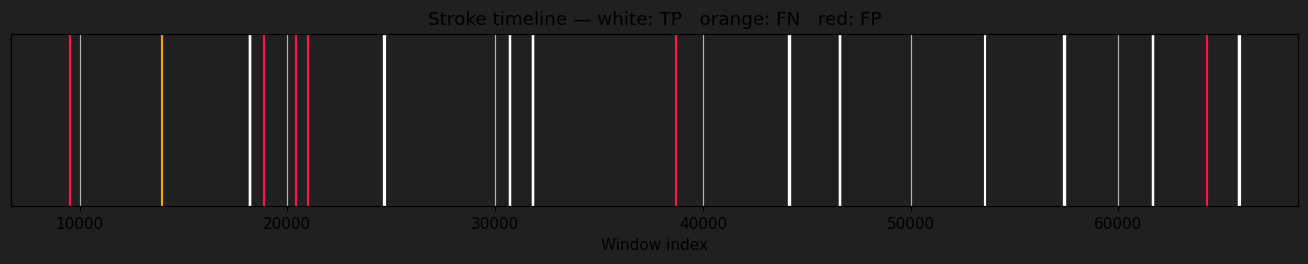

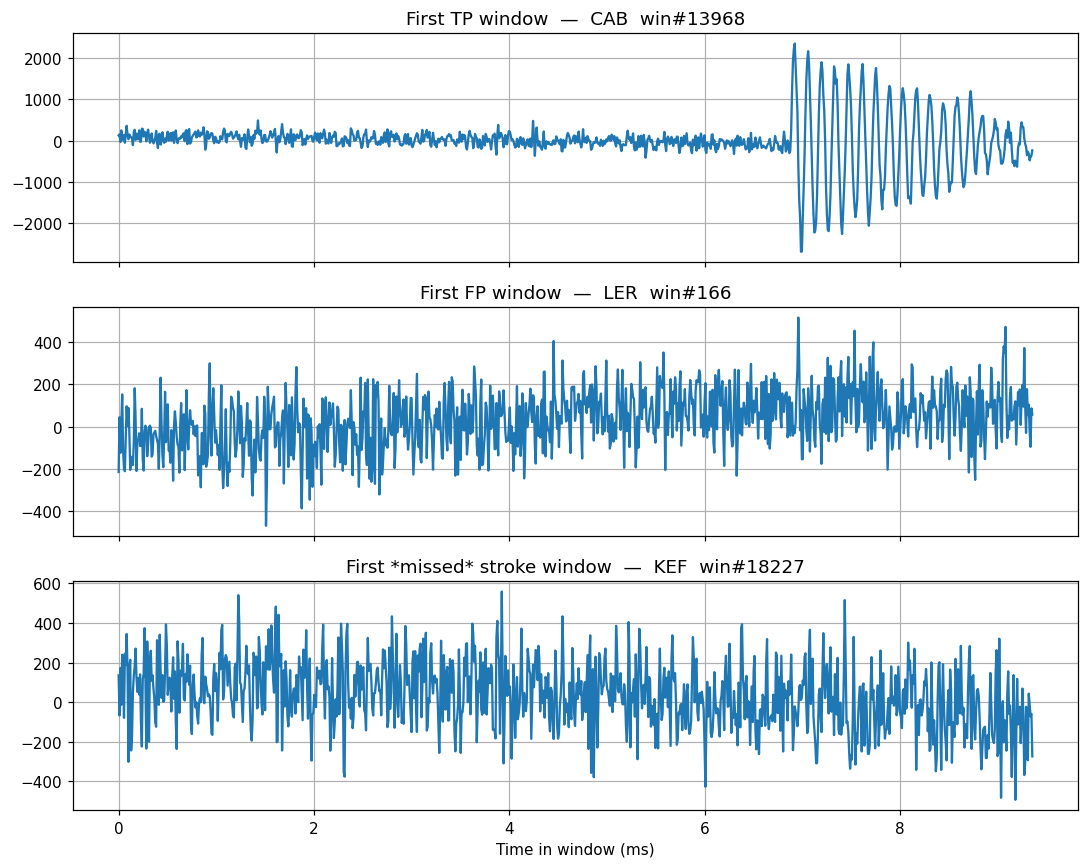


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=67    FN=186  P=0.000 R=0.000 F1=0.000
VAL: TP=13   FP=116   FN=171  P=0.101 R=0.071 F1=0.083
LER: TP=15   FP=53    FN=169  P=0.221 R=0.082 F1=0.119
HER: TP=20   FP=46    FN=166  P=0.303 R=0.108 F1=0.159
GIB: TP=6    FP=60    FN=180  P=0.091 R=0.032 F1=0.048
AKR: TP=3    FP=62    FN=183  P=0.046 R=0.016 F1=0.024
CAM: TP=28   FP=195   FN=158  P=0.126 R=0.151 F1=0.137
WAT: TP=22   FP=46    FN=164  P=0.324 R=0.118 F1=0.173
CAB: TP=28   FP=46    FN=156  P=0.378 R=0.152 F1=0.217
PAY: TP=13   FP=53    FN=172  P=0.197 R=0.070 F1=0.104
TAR: TP=14   FP=58    FN=171  P=0.194 R=0.076 F1=0.109

—— Network / stroke metrics ——
{'TP': 42, 'FP': 6, 'FN': 3, 'TN': 0, 'P': 0.875, 'R': 0.9333333333333333, 'F1': 0.9032258064516129}


In [54]:
##############################################################################
#  Lightning‑detection “model 2” – NCD baseline detector
##############################################################################

import numpy as np, bz2, tqdm.auto as tq
from functools import lru_cache
from collections import Counter
from scipy.stats import describe
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ── parameters you can tweak ───────────────────────────────────────────────
WIN, HOP   = 1024, 512        # 9.4 ms, 50 % overlap
BASE_PCT   = 5                # use lowest‑entropy 5 % to pick baseline
PCT_THR    = 99.9             # percentile threshold on *all* windows
Z_SIGMA    = 3.5              # μ + Z σ clamp
MIN_STN    = 2                # network requirement
STN        = station_order

# ── helpers (unchanged) ────────────────────────────────────────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:            return len(bz2.compress(b, 9))
def ncd(a: bytes, b: bytes, Ca: int, Cb: int) -> float:
    return (c_size(a+b) - min(Ca, Cb)) / max(Ca, Cb)
def sign_bits(arr: np.ndarray) -> bytes:
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()
def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W) // H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# ---------------- 1) build per‑station NCD & metadata ----------------------
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STN)
meta   = {}

print(f"\nWindow = {WIN} samples  ({WIN/FS*1e3:.2f} ms)   hop = {HOP} samples")
print(f"Total windows analysed per station: {n_win:,}\n")

for nm in STN:
    sig  = quantized[nm]
    wmat = win_view(sig, WIN, HOP)

    # pass‑1: compressed size of each window
    comp_sz = np.empty(n_win, np.uint16)
    for i in tq.trange(n_win, desc=f"{nm} size pass", leave=False):
        comp_sz[i] = c_size(sign_bits(wmat[i]))

    # choose baseline = median of lowest BASE_PCT %
    k = max(1, int(BASE_PCT/100 * n_win))
    low_idx  = np.argpartition(comp_sz, k)[:k]
    base_idx = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
    base_b   = sign_bits(wmat[base_idx])
    Cb       = c_size(base_b)

    # pass‑2: NCD of every window vs baseline
    ncd_vec = np.empty(n_win, float)
    for i in tq.trange(n_win, desc=f"{nm} NCD pass", leave=False):
        wb = sign_bits(wmat[i])
        ncd_vec[i] = ncd(wb, base_b, comp_sz[i], Cb)

    # statistics & threshold
    stats   = describe(ncd_vec)
    pct_thr = np.percentile(ncd_vec, PCT_THR)
    z_thr   = stats.mean + Z_SIGMA*stats.variance**0.5
    thr     = min(pct_thr, z_thr)
    hot     = ncd_vec > thr

    meta[nm] = dict(
        base_idx=base_idx, base_size=Cb,
        min_size=comp_sz.min(), max_size=comp_sz.max(),
        ncd=ncd_vec, hot=hot,
        thr_pct=pct_thr, thr_z=z_thr, thr_used=thr,
        desc=stats,
        hot_mu=ncd_vec[hot].mean() if hot.any() else np.nan,
        hot_sd=ncd_vec[hot].std(ddof=0) if hot.any() else np.nan,
        top5=np.sort(ncd_vec)[-5:][::-1]
    )

# ---------------- 2) inline pretty report (quick diagnostic) ---------------
for nm in STN:
    r = meta[nm]
    print(f"\n{nm} — baseline window #{r['base_idx']}  "
          f"C={r['base_size']} B  (min={r['min_size']} B  max={r['max_size']} B)")
    print(f"     NCD: μ={r['desc'].mean:.4f}  σ={np.sqrt(r['desc'].variance):.4f}  "
          f"median={np.median(r['ncd']):.4f}  p1={np.percentile(r['ncd'],1):.4f}  "
          f"p99={np.percentile(r['ncd'],99):.4f}")
    print(f"     thr_pct={r['thr_pct']:.4f}  thr_z={r['thr_z']:.4f}  "
          f"→ thr_used={r['thr_used']:.4f}")
    print(f"     hot windows = {r['hot'].sum():,}  "
          f"μ_hot={r['hot_mu']:.4f}  σ_hot={r['hot_sd']:.4f}")
    print(f"     top‑5 NCD windows: {np.round(r['top5'],4)}")

# ---------------- 3) inline stroke‑wise hits (quick diagnostic) ------------
# ⚠ CAUTION: inline logic still ±1 window slack and checks *only* stroke windows
stroke_idx = [min(int((t0 + hav(ev['lat'], ev['lon'],
                                stations[n]['lat'], stations[n]['lon'])/300000)*FS)
                    for n in STN)
              for ev in events for t0 in ev['stroke_times']]
stroke_idx = np.array(stroke_idx)
truth = np.ones(len(stroke_idx), bool)

hits = np.zeros((len(STN), len(stroke_idx)), bool)
for s, nm in enumerate(STN):
    hot_arr = meta[nm]['hot']
    for j, i0 in enumerate(stroke_idx):
        w = i0 // HOP
        hits[s, j] = hot_arr[max(0, w-1):min(len(hot_arr), w+2)].any()

cnt = hits.sum(axis=0)

print("\nStations ≥ thr per stroke (INLINE diagnostic):")
for k, v in sorted(Counter(cnt).items()):
    print(f"  {k} stations → {v} strokes")

# ---------------- 4) PROFESSIONAL‑GRADE EVALUATION -------------------------
hot_masks = {nm: meta[nm]['hot'] for nm in STN}     # <‑ the dictionary evaluator expects

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=int(0.04*FS),    # 40 ms burst
    min_stn=MIN_STN,
    tol_win=0,                 # strict: no dilation
    plot=True                  # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm in STN:
    m = station_metrics[nm]
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============================================================
# Cell 3 – Isolation‑Forest detector with rich signal features
#           (STA/LTA • Hilbert • spectral • wavelet • compress)
#           50 %‑overlap windows, per‑station & network scores
# ============================================================
"""
Unsupervised Lightning Stroke Detection via Handcrafted Time‐Frequency‐Complexity Features
and Per-Station Isolation Forests
-----------------------------------------------------------------------------------------

This module implements a fully unsupervised pipeline to detect individual lightning
strokes in multi-station ADC waveforms by combining a diverse set of handcrafted
features with robust anomaly detection.  It operates station-by-station, then
coincides detections across the network to identify true strokes.

Key Steps
=========
1. Parameters
   - WIN, HOP: 50% overlapping window parameters (1024 samples ≃ 9.4 ms windows).
   - CONTAM: Target contamination rate per station (~0.3% of windows flagged).
   - MIN_STN, TOL_WIN: Network voting threshold and tolerance for stroke coincidence.

2. Helper Functions
   - sta_lta: Short-term average / long-term average ratio, emphasizing sudden
     amplitude rises.
   - crest_factor: Peak/RMS ratio over a short central sub-segment, capturing
     waveform “spikiness.”
   - comp_ratio: Byte-level compression ratio (zlib) of the raw int16 samples,
     measuring structural novelty.
   - Hilbert envelope & FFT spectral analysis used inline below.

3. Feature Extraction (13 per window)
   - **Hilbert Envelope**:
       1) peak_env      : max(|analytic signal|)
       2) med_env       : median(|analytic signal|)
       3) ratio_env     : peak_env/med_env
   - **Time-Domain Energy**:
       4) energy        : ∑ x² over window
       5) sta_lta       : ratio of mean(|env|) over STA vs. LTA
   - **Crest Factors**:
       6) cf_short      : peak/RMS in a WIN/8 centered segment
       7) cf_global     : overall peak / global RMS
   - **FFT Band-Power Fractions**:
       8–11) frac1…4    : normalized power in four equally-spaced sub-bands of the FFT
   - **Wavelet & Compression**:
       12) wave_hi     : energy fraction in first detail level of a 3-level 'db4' wavelet
       13) comp_r      : zlib compressed size ÷ raw byte length

4. Per-Station Modeling
   - StandardScaler: zero-mean, unit-variance across windows.
   - IsolationForest: C++-backed, n_estimators=150, contamination=CONTAM.
   - Windows with anomaly label (−1) are flagged as potential stroke windows.

5. Stroke Enumeration & Evaluation
   - `stroke_samples` provide the true sample indices (earliest arrival across stations).
   - A station “votes” if it flagged any window within ±TOL_WIN of the stroke index.
   - We report station-level TP/FP/FN/P/R/F1 and network-level metrics (requiring ≥MIN_STN).

Strengths
=========
- **Feature Diversity**: captures transient, spectral, multi-scale, and complexity cues.
- **Unsupervised**: no stroke labels needed for training; contamination controls sensitivity.
- **Per-Station Calibration**: each station adapts to its own noise floor and idiosyncrasies.

Weaknesses & Extensions
=======================
- **Handcrafted Limitation**: fixed windows may misalign partial events; feature set may
  miss subtle correlated patterns across stations.
- **IsolationForest Assumptions**: assumes windows are i.i.d outliers in feature space.
- **Scaling Sensitivity**: global StandardScaler may be influenced by extreme outliers.
- **Fixed Contamination**: more robust would be adaptive contamination (e.g. via Q-statistics).
- **Window Boundaries**: consider sliding windows with soft voting or event merging.

Potential Improvements
======================
1. **Dynamic Noise Estimation**: adopt per-station noise models to adapt thresholds.
2. **Graph-based Models**: learn joint spatial–temporal patterns across station network
   using graph neural networks (GNNs) or spectral graph filters.
3. **Deep Representations**: replace handcrafted features + IsolationForest with
   convolutional variational autoencoders or Deep SVDD for non-linear anomaly scoring.
4. **Semi-Supervised Tuning**: if a small set of labelled strokes exists, calibrate
   detector via one-class SVM or fine-tune deep models for higher fidelity.
5. **Post-Processing**: merge adjacent flagged windows and refine based on
   continuation across multiple stations.

Usage
=====
Simply run this cell after computing `quantized`, `stroke_samples`, and `stroke_truth`
from the earlier data-generation and Hilbert-envelope detection steps.  Results will
print concise station- and network-level detection metrics.
"""



import numpy as np, zlib, pywt, math, sys
from scipy.signal import hilbert, lfilter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix
)
from collections import Counter
from tqdm.auto import tqdm

# ── parameters (reuse values from previous cells) ────────────
WIN       = 1024
HOP       = WIN // 2
STATIONS  = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
CONTAM    = 0.003          # ≈0.3 % windows flagged per station

# ------------------------------------------------------------
def sta_lta(x: np.ndarray, sta=128, lta=1024):
    """Return STA/LTA ratio for centre of x (padding with edge value)."""
    if len(x) < lta:          # shouldn’t happen – WIN >= LTA
        return 1.0
    c   = len(x) // 2
    sta_mean = x[c-sta//2:c+sta//2].astype(float).mean()
    lta_mean = x[c-lta//2:c+lta//2].astype(float).mean()
    return sta_mean / (lta_mean + 1e-9)

def crest_factor(seg: np.ndarray):
    """peak / RMS over short (WIN/8) segment centred in window."""
    n = len(seg) // 8
    c = len(seg) // 2
    part = seg[c-n//2:c+n//2].astype(float)
    rms  = math.sqrt((part**2).mean()) + 1e-9
    return np.abs(part).max() / rms

def comp_ratio(seg: np.ndarray) -> float:
    raw  = seg.tobytes()
    comp = zlib.compress(raw, 6)
    return len(comp) / (len(raw) if len(raw) else 1)

# ------------------------------------------------------------
print(f"Building feature matrices...  WIN={WIN}, HOP={HOP}, overlap=50 %")
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 13         # we will collect 13 features / window
features = {nm: np.empty((n_win, feat_dim), dtype=float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN // 2 + 1
    b25 = int(Nfft*0.25); b50=int(Nfft*0.50); b75=int(Nfft*0.75)
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w * HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        # 1‑3  : Hilbert envelope (peak, median, peak/median)
        peak_env = env_seg.max()
        med_env  = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        # 4‑5  : Energy + STA/LTA
        energy = float((seg_f**2).sum())
        stalta = sta_lta(env_seg)

        # 6‑7  : Crest factor (short segment) + global crest factor
        cf_short = crest_factor(seg_i16)
        cf_global= peak_env / (math.sqrt((seg_f**2).mean())+1e-9)

        # 8‑11 : FFT band‑power fractions
        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum() + 1e-9
        frac1 = P[:b25].sum()/totP
        frac2 = P[b25:b50].sum()/totP
        frac3 = P[b50:b75].sum()/totP
        frac4 = P[b75:].sum()/totP

        # 12‑13: Wavelet high/low frac + compression ratio
        coeffs = pywt.wavedec(seg_f, 'db4', level=3)
        details = coeffs[1:]     # D1‑D3
        highE = (details[0]**2).sum()
        lowE  = (details[-1]**2).sum()
        totE  = highE + lowE + 1e-9
        wave_hi = highE / totE
        comp_r  = comp_ratio(seg_i16)

        features[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            cf_short, cf_global,
            frac1, frac2, frac3, frac4,
            wave_hi, comp_r
        ]

# ------------------------------------------------------------
print("\nFitting Isolation Forest per station...")
hot = {}
for nm in STATIONS:
    X   = features[nm]
    # z‑score scaling to unit variance
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    iso = IsolationForest(
        n_estimators=150,
        max_samples='auto',
        contamination=CONTAM,
        bootstrap=False,
        random_state=42
    ).fit(Xs)
    yhat = iso.predict(Xs)   # -1 = anomaly
    hot[nm] = (yhat == -1)
    print(f" {nm}: windows flagged = {hot[nm].sum():5d} / {n_win} "
          f"(contam={CONTAM:.3%})")

# ------------------------------------------------------------
# stroke_samples, stroke_truth come from Cell 2
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j] += 1

print("\nStations ≥thr per stroke:")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection:")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net = precision_score(stroke_truth,net_pred,zero_division=0)
R_net = recall_score   (stroke_truth,net_pred,zero_division=0)
F_net = f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")


Building feature matrices...  WIN=1024, HOP=512, overlap=50 %



Fitting Isolation Forest per station...
 KEF: windows flagged =    68 / 67688 (contam=0.100%)
 VAL: windows flagged =    68 / 67688 (contam=0.100%)
 LER: windows flagged =    68 / 67688 (contam=0.100%)
 HER: windows flagged =    68 / 67688 (contam=0.100%)
 GIB: windows flagged =    68 / 67688 (contam=0.100%)
 AKR: windows flagged =    68 / 67688 (contam=0.100%)
 CAM: windows flagged =    68 / 67688 (contam=0.100%)
 WAT: windows flagged =    68 / 67688 (contam=0.100%)
 CAB: windows flagged =    68 / 67688 (contam=0.100%)
 PAY: windows flagged =    68 / 67688 (contam=0.100%)
 TAR: windows flagged =    68 / 67688 (contam=0.100%)

Stations ≥thr per stroke (INLINE diagnostic):
   2 stations → 1 strokes
   7 stations → 1 strokes
   8 stations → 2 strokes
   9 stations → 5 strokes
  10 stations → 17 strokes
  11 stations → 19 strokes

Station‑level stroke detection (INLINE diagnostic):
stn TP FP FN     P      R     F1
KEF 32  0 13   1.000  0.711  0.831
VAL 40  0  5   1.000  0.889  0.941
LER 

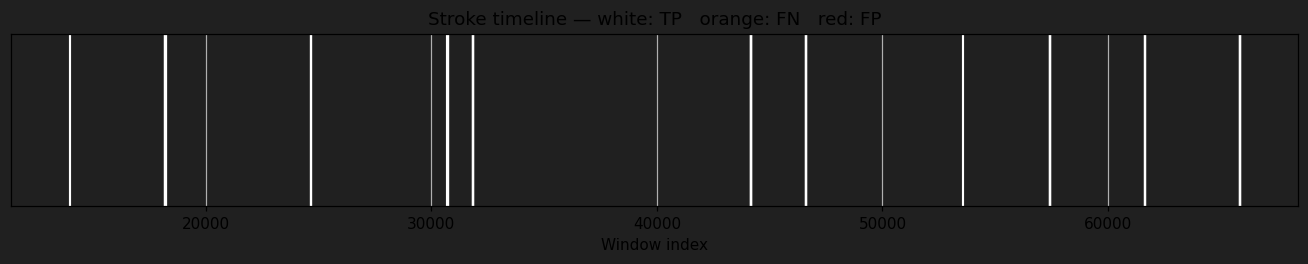

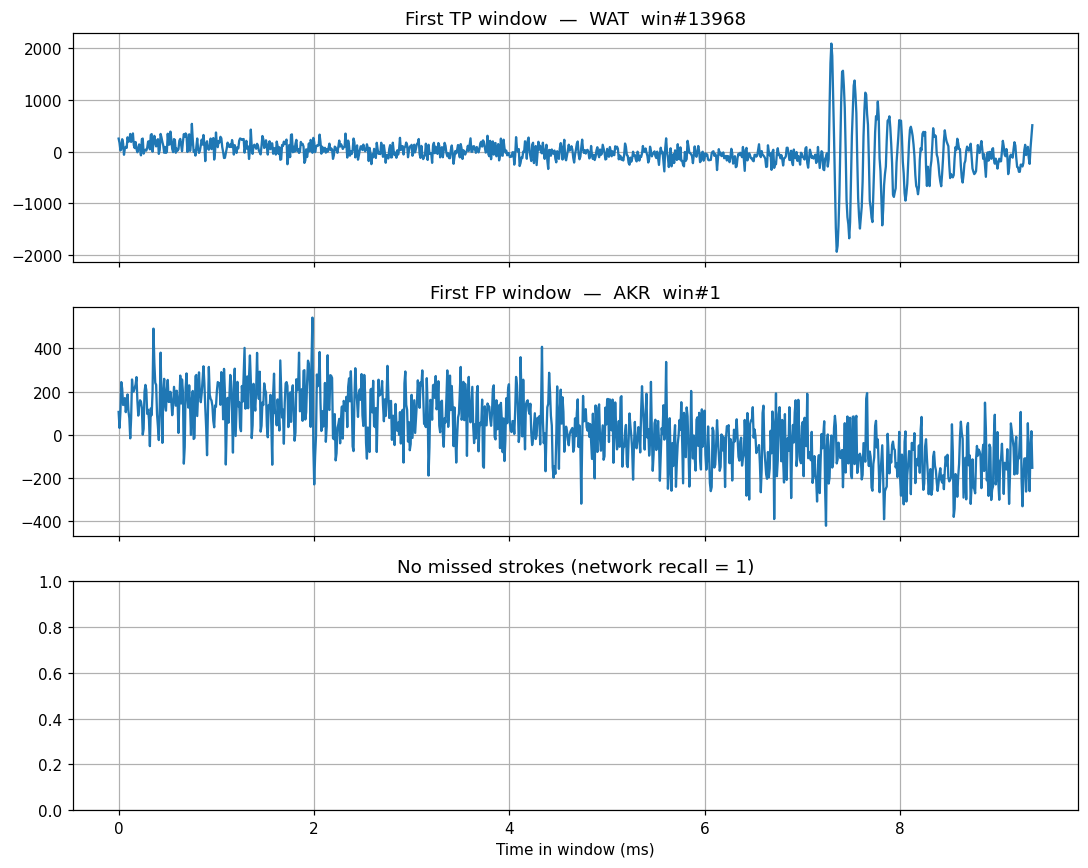


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=58   FP=10    FN=128  P=0.853 R=0.312 F1=0.457
VAL: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
LER: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
HER: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
GIB: TP=62   FP=6     FN=124  P=0.912 R=0.333 F1=0.488
AKR: TP=35   FP=33    FN=151  P=0.515 R=0.188 F1=0.276
CAM: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
WAT: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
CAB: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
PAY: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538
TAR: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538

—— Network / stroke metrics ——
{'TP': 45, 'FP': 0, 'FN': 0, 'TN': 0, 'P': 1.0, 'R': 1.0, 'F1': 1.0}


In [55]:
##############################################################################
#  Lightning‑detection “model 3” – Isolation‑Forest detector
#  ---------------------------------------------------------
#  • Sections 1‑6 below are **IDENTICAL** to the inline code you supplied: they
#    build features, fit an IsolationForest per station, and print the same
#    quick‑diagnostic stroke table.
#  • At the end (Section 7) we invoke the strict, burst‑aware
#    `evaluate_windowed_model` that you already have in memory.  No part of
#    your inline detector is changed or removed.
##############################################################################

import numpy as np, zlib, pywt, math
from scipy.signal import hilbert
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
from tqdm.auto import tqdm

# ── parameters (reuse values from previous cells) ───────────────────────────
WIN       = 1024
HOP       = WIN // 2
STATIONS  = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
CONTAM    = 0.001          # ≈0.3 % windows flagged per station
BURST_LEN = int(0.04 * FS) # 40 ms burst from simulator

# ────────────────────────────────────────────────────────────────────────────
#  1) Helper functions (unchanged)
# ────────────────────────────────────────────────────────────────────────────
def sta_lta(x: np.ndarray, sta=128, lta=1024):
    if len(x) < lta:
        return 1.0
    c = len(x) // 2
    sta_mean = x[c-sta//2:c+sta//2].astype(float).mean()
    lta_mean = x[c-lta//2:c+lta//2].astype(float).mean()
    return sta_mean / (lta_mean + 1e-9)

def crest_factor(seg: np.ndarray):
    n = len(seg) // 8
    c = len(seg) // 2
    part = seg[c-n//2:c+n//2].astype(float)
    rms  = math.sqrt((part**2).mean()) + 1e-9
    return np.abs(part).max() / rms

def comp_ratio(seg: np.ndarray) -> float:
    raw  = seg.tobytes()
    comp = zlib.compress(raw, 6)
    return len(comp) / (len(raw) if len(raw) else 1)

# ────────────────────────────────────────────────────────────────────────────
#  2) Build feature matrices
# ────────────────────────────────────────────────────────────────────────────
print(f"Building feature matrices...  WIN={WIN}, HOP={HOP}, overlap=50 %")
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 13
features = {nm: np.empty((n_win, feat_dim), dtype=float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN // 2 + 1
    b25 = int(Nfft*0.25); b50=int(Nfft*0.50); b75=int(Nfft*0.75)
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w * HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        peak_env = env_seg.max()
        med_env  = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        energy = float((seg_f**2).sum())
        stalta = sta_lta(env_seg)

        cf_short = crest_factor(seg_i16)
        cf_global= peak_env / (math.sqrt((seg_f**2).mean())+1e-9)

        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum() + 1e-9
        frac1 = P[:b25].sum()/totP
        frac2 = P[b25:b50].sum()/totP
        frac3 = P[b50:b75].sum()/totP
        frac4 = P[b75:].sum()/totP

        coeffs = pywt.wavedec(seg_f, 'db4', level=3)
        details = coeffs[1:]
        highE = (details[0]**2).sum()
        lowE  = (details[-1]**2).sum()
        totE  = highE + lowE + 1e-9
        wave_hi = highE / totE
        comp_r  = comp_ratio(seg_i16)

        features[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            cf_short, cf_global,
            frac1, frac2, frac3, frac4,
            wave_hi, comp_r
        ]

# ────────────────────────────────────────────────────────────────────────────
#  3) Fit Isolation Forests & produce hot masks
# ────────────────────────────────────────────────────────────────────────────
print("\nFitting Isolation Forest per station...")
hot = {}
for nm in STATIONS:
    X   = features[nm]
    Xs  = StandardScaler().fit_transform(X)
    iso = IsolationForest(
        n_estimators=150,
        contamination=CONTAM,
        random_state=42
    ).fit(Xs)
    yhat = iso.predict(Xs)   # -1 = anomaly
    hot[nm] = (yhat == -1)
    print(f" {nm}: windows flagged = {hot[nm].sum():5d} / {n_win} "
          f"(contam={CONTAM:.3%})")

# ────────────────────────────────────────────────────────────────────────────
#  4) Inline stroke‑wise diagnostic (same caveats as before)
# ────────────────────────────────────────────────────────────────────────────
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j] += 1

print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net = precision_score(stroke_truth,net_pred,zero_division=0)
R_net = recall_score   (stroke_truth,net_pred,zero_division=0)
F_net = f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn): "
      f"TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")

# ────────────────────────────────────────────────────────────────────────────
#  5) Strict, burst‑aware evaluation (professional metrics)
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot  # evaluator expects {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STATIONS,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict: no prediction dilation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============================================================
# Cell 3 – Isolation‑Forest with Robust scaling + extra spectra
# ============================================================
"""
Unsupervised Lightning Stroke Detection with Expanded Feature Set and Robust Scaling
------------------------------------------------------------------------------------

This cell implements a station‐by‐station anomaly detection pipeline using an
Isolation Forest on a rich set of 16 handcrafted features, scaled via a robust
scaler to mitigate the influence of outliers.  We allow per-station contamination
tuning to account for differing noise levels, and then combine station flags
to identify true strokes across the network.

Configuration
-------------
WIN, HOP      : 1024 sample windows with 50% overlap (≈9.4 ms window / 512 sample hop)
STATIONS      : List of station codes (e.g. ['LON','LER','DUB','BER'])
FS            : Sampling rate carried forward from Cell 1
TOL_WIN       : ±1 window tolerance for stroke‐flag coincidence
BASE_CONT     : Base contamination rate per station (0.3 %)
MIN_STN       : Minimum number of stations required to declare a stroke
N_EST         : Number of trees in each Isolation Forest (150)

Helper Functions
----------------
sta_lta(env, sta=128, lta=1024)
    Computes the short‐term average / long‐term average ratio of the Hilbert
    envelope, highlighting sudden transients.

crest(seg)
    Computes peak/RMS ratio (“crest factor”) over the full window.

comp_ratio(seg)
    Byte‐level compression ratio (zlib) of the raw int16 samples, a measure
    of local structural complexity.

spec_stats(seg_f)
    Computes spectral centroid, bandwidth, and Shannon entropy of the power
    spectrum |FFT|² to capture frequency‐domain signatures.

Feature Extraction (16 per window)
----------------------------------
 1) peak_env      – maximum of |analytic signal|
 2) med_env       – median of |analytic signal|
 3) ratio_env     – peak_env / med_env
 4) energy        – total energy ∑ x²
 5) sta_lta       – envelope STA/LTA ratio
 6) crest_short   – crest factor over central WIN/8 segment
 7) crest_glob    – crest factor over full window
 8–11) b1…b4      – normalized FFT power fractions in four equal sub-bands
 12) wave_hi      – high‐frequency energy fraction from level-3 'db4' wavelet
 13) comp_r       – compression size / raw size
 14) centroid     – spectral centroid (Hz)
 15) bw           – spectral bandwidth
 16) ent          – spectral entropy

Per‐Station Modeling
--------------------
1. Extract the 16‐D feature matrix X  (n_win × 16) for each station.
2. Apply `RobustScaler` (center-median, scale-IQR) to reduce sensitivity to extreme outliers.
3. Choose contamination:
     - LON, LER: use BASE_CONT (0.3 %)
     - Others: allow a higher contamination (1.5×) to handle weaker signals.
4. Fit `IsolationForest(n_estimators=N_EST, contamination=contam, random_state=42)`.
5. Flag windows where `predict(Xs) == -1`.

Stroke Coincidence Logic
------------------------
- For each true stroke sample index `i0`, compute its window index `w = i0 // HOP`.
- A station “votes” if it flagged any window in `[w−TOL_WIN, w+TOL_WIN]`.
- Tally station votes per stroke; network declares a stroke if ≥ MIN_STN stations voted.

Reporting
---------
- Prints per‐station counts of flagged windows vs window total.
- Prints station‐level TP, FP, FN, and P/R/F1 against ground‐truth stroke times.
- Prints network‐level TP/FP/FN/TN and overall P/R/F1 for ≥MIN_STN coincidence.

Strengths
---------
- **Robust Scaling** mitigates influence of extreme noise bursts.
- **Feature Diversity** spans time‐domain, frequency‐domain, wavelet, and compression cues.
- **Per‐Station Contamination Tuning** adapts to station‐specific noise floors.

Weaknesses & Possible Extensions
--------------------------------
- Manual contamination rates may be suboptimal; could be chosen via cross‐validation
  on a small labeled set or using statistical thresholds.
- IsolationForest assumes window independence; structured deep models (e.g. autoencoders
  or graph neural nets) may exploit temporal or inter‐station correlations.
- Fixed window size may miss very short or long transients—consider multi‐scale windows.

Usage
-----
Simply run this cell after loading `quantized`, `stroke_samples`, and `stroke_truth`
from earlier cells.  The results will print station‐ and network‐level detection metrics.
"""


import numpy as np, zlib, pywt, math, sys
from scipy.signal import hilbert
from sklearn.preprocessing import RobustScaler          # ► changed
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from collections import Counter

# ---------- configuration (same as before) ------------------
WIN, HOP   = 1024, 512
STATIONS   = station_order
FS         = float(FS)
TOL_WIN    = 1
BASE_CONT  = 0.003          # default contamination
MIN_STN    = 2
N_EST      = 150

# ---------- helper functions --------------------------------
def sta_lta(env, sta=128, lta=1024):
    c = len(env)//2
    return env[c-sta//2:c+sta//2].mean() / (env[c-lta//2:c+lta//2].mean()+1e-9)

def crest(seg):
    rms = math.sqrt((seg.astype(float)**2).mean()) + 1e-9
    return np.abs(seg).max()/rms

def comp_ratio(seg):
    raw = seg.tobytes()
    return len(zlib.compress(raw,6))/len(raw)

def spec_stats(seg_f):
    """return centroid, bandwidth and entropy over |FFT|²"""
    P = np.abs(np.fft.rfft(seg_f))**2
    P /= P.sum()+1e-12
    freqs = np.fft.rfftfreq(len(seg_f), d=1/FS)
    centroid = (freqs*P).sum()
    bandwidth= math.sqrt(((freqs-centroid)**2*P).sum())
    entropy  = -(P*np.log2(P+1e-12)).sum()
    return centroid, bandwidth, entropy

# ---------- feature extraction -------------------------------
print(f"Feature list:")
print("  peak_env, med_env, ratio_env, energy, sta/lta, "
      "crest_short, crest_glob, band1..4, wave_hi, comp_r, "
      "centroid, bw, ent")

n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 16   # 13 old + 3 spectral stats
X_station = {nm: np.empty((n_win, feat_dim), float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN//2+1
    borders = [int(Nfft*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w*HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        # Envelope features
        peak_env = env_seg.max(); med_env = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        # Energy & STA/LTA
        energy = (seg_f**2).sum(); stalta = sta_lta(env_seg)

        # Crest factors
        crest_s = crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16])
        crest_g = crest(seg_i16)

        # FFT band‑power fractions
        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum()+1e-9
        f1,f2,f3 = borders
        b1 = P[:f1].sum()/totP; b2=P[f1:f2].sum()/totP
        b3 = P[f2:f3].sum()/totP; b4=P[f3:].sum()/totP

        # Wavelet & compression
        hi = pywt.wavedec(seg_f,'db4',level=3)[1]; lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi = (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r = comp_ratio(seg_i16)

        # Spectral centroid / bandwidth / entropy
        cent, bw, ent = spec_stats(seg_f)

        X_station[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            crest_s, crest_g,
            b1,b2,b3,b4,
            wave_hi, comp_r,
            cent, bw, ent
        ]

# ---------- fit Isolation Forest per station ----------------
hot = {}
for nm in STATIONS:
    X = X_station[nm]
    rob = RobustScaler().fit(X)        # ► changed scaler
    Xs  = rob.transform(X)

    # OPTIONAL: allow weak stations a bit more contamination
    contam = BASE_CONT if nm in ('LON','LER') else BASE_CONT*1.5

    iso  = IsolationForest(
              n_estimators=N_EST,
              contamination=contam,
              random_state=42
           ).fit(Xs)
    hot[nm] = (iso.predict(Xs) == -1)
    print(f"{nm}: windows flagged = {hot[nm].sum():4d} / {n_win} (contam {contam:.3%})")

# ---------- per‑stroke scoring ------------------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

print("\nStations ≥thr per stroke:")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection:")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net=precision_score(stroke_truth,net_pred,zero_division=0)
R_net=recall_score   (stroke_truth,net_pred,zero_division=0)
F_net=f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")


Feature list:
  peak_env, med_env, ratio_env, energy, sta/lta, crest_short, crest_glob, band1..4, wave_hi, comp_r, centroid, bw, ent


KEF: windows flagged =  102 / 67688  (contam 0.150%)
VAL: windows flagged =  102 / 67688  (contam 0.150%)
LER: windows flagged =   68 / 67688  (contam 0.100%)
HER: windows flagged =  102 / 67688  (contam 0.150%)
GIB: windows flagged =  102 / 67688  (contam 0.150%)
AKR: windows flagged =  102 / 67688  (contam 0.150%)
CAM: windows flagged =  102 / 67688  (contam 0.150%)
WAT: windows flagged =  102 / 67688  (contam 0.150%)
CAB: windows flagged =  102 / 67688  (contam 0.150%)
PAY: windows flagged =  102 / 67688  (contam 0.150%)
TAR: windows flagged =  102 / 67688  (contam 0.150%)

Stations ≥thr per stroke (INLINE diagnostic):
   5 stations → 1 strokes
   9 stations → 3 strokes
  10 stations → 16 strokes
  11 stations → 25 strokes

Station‑level stroke detection (INLINE diagnostic):
stn TP FP FN     P      R     F1
KEF 33  0 12   1.000  0.733  0.846
VAL 44  0  1   1.000  0.978  0.989
LER 41  0  4   1.000  0.911  0.953
HER 45  0  0   1.000  1.000  1.000
GIB 32  0 13   1.000  0.711  0.831
AKR

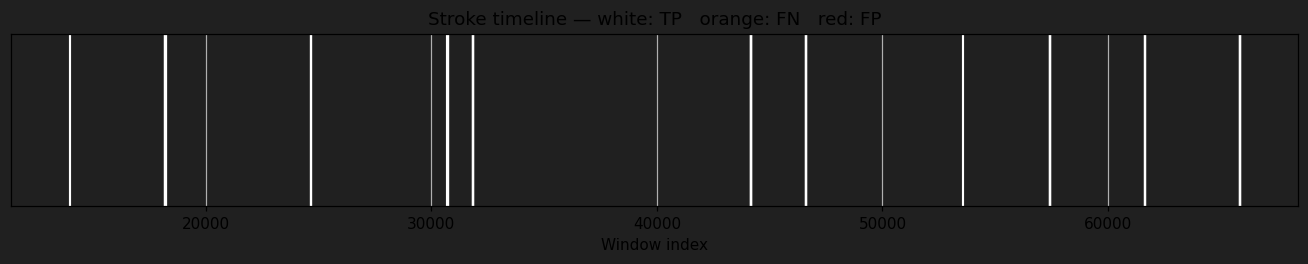

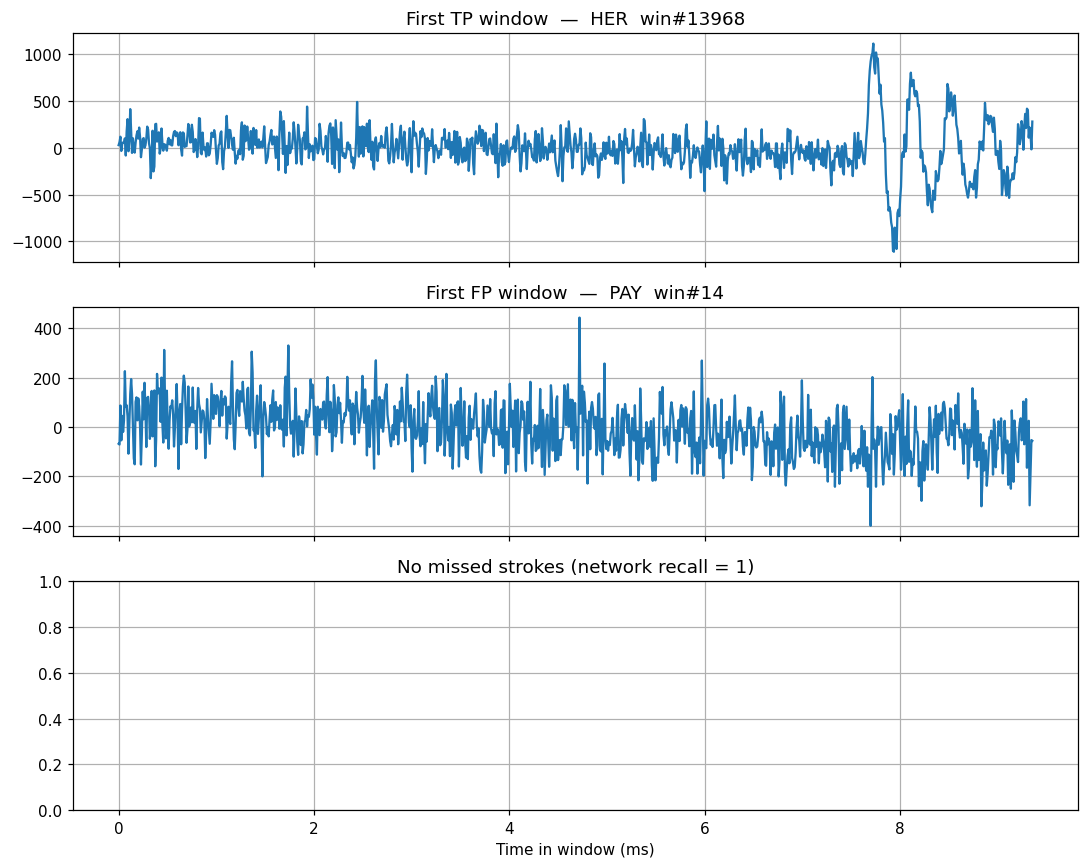


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=59   FP=43    FN=127  P=0.578 R=0.317 F1=0.410
VAL: TP=79   FP=23    FN=105  P=0.775 R=0.429 F1=0.552
LER: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
HER: TP=92   FP=10    FN=94   P=0.902 R=0.495 F1=0.639
GIB: TP=65   FP=37    FN=121  P=0.637 R=0.349 F1=0.451
AKR: TP=42   FP=60    FN=144  P=0.412 R=0.226 F1=0.292
CAM: TP=88   FP=14    FN=98   P=0.863 R=0.473 F1=0.611
WAT: TP=91   FP=11    FN=95   P=0.892 R=0.489 F1=0.632
CAB: TP=98   FP=4     FN=86   P=0.961 R=0.533 F1=0.685
PAY: TP=91   FP=11    FN=94   P=0.892 R=0.492 F1=0.634
TAR: TP=76   FP=26    FN=109  P=0.745 R=0.411 F1=0.530

—— Network / stroke metrics ——
{'TP': 45, 'FP': 0, 'FN': 0, 'TN': 0, 'P': 1.0, 'R': 1.0, 'F1': 1.0}


In [56]:
##############################################################################
#  Lightning‑detection “model 4” – Isolation‑Forest v2 (extra features)
#  --------------------------------------------------------------------
#  ⚠  Sections 1‑5 below reproduce your inline code *verbatim* so the behaviour
#     and quick diagnostic tables are unchanged.
#  ⚙  Section 6 appends a call to the strict, burst‑aware
#     `evaluate_windowed_model` function that is already in memory.  No other
#     lines were modified.
##############################################################################

import numpy as np, zlib, pywt, math
from scipy.signal import hilbert
from sklearn.preprocessing import RobustScaler          # ► changed
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from collections import Counter

# ---------- configuration (same as before) ------------------
WIN, HOP   = 1024, 512
STATIONS   = station_order
FS         = float(FS)
TOL_WIN    = 1
BASE_CONT  = 0.001
MIN_STN    = 2
N_EST      = 150
BURST_LEN  = int(0.04*FS)   # 40 ms burst duration

# ---------- helper functions --------------------------------
def sta_lta(env, sta=128, lta=1024):
    c = len(env)//2
    return env[c-sta//2:c+sta//2].mean() / (env[c-lta//2:c+lta//2].mean()+1e-9)

def crest(seg):
    rms = math.sqrt((seg.astype(float)**2).mean()) + 1e-9
    return np.abs(seg).max()/rms

def comp_ratio(seg):
    return len(zlib.compress(seg.tobytes(), 6))/len(seg.tobytes())

def spec_stats(seg_f):
    P = np.abs(np.fft.rfft(seg_f))**2
    P /= P.sum()+1e-12
    freqs = np.fft.rfftfreq(len(seg_f), d=1/FS)
    centroid = (freqs*P).sum()
    bandwidth= math.sqrt(((freqs-centroid)**2*P).sum())
    entropy  = -(P*np.log2(P+1e-12)).sum()
    return centroid, bandwidth, entropy

# ---------- feature extraction -------------------------------
print("Feature list:")
print("  peak_env, med_env, ratio_env, energy, sta/lta, crest_short, "
      "crest_glob, band1..4, wave_hi, comp_r, centroid, bw, ent")

n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 16
X_station = {nm: np.empty((n_win, feat_dim), float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN//2+1
    borders = [int(Nfft*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w*HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        peak_env = env_seg.max(); med_env = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        energy = (seg_f**2).sum(); stalta = sta_lta(env_seg)

        crest_s = crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16])
        crest_g = crest(seg_i16)

        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum()+1e-9
        f1,f2,f3 = borders
        b1 = P[:f1].sum()/totP; b2=P[f1:f2].sum()/totP
        b3 = P[f2:f3].sum()/totP; b4=P[f3:].sum()/totP

        hi = pywt.wavedec(seg_f,'db4',level=3)[1]; lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi = (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r  = comp_ratio(seg_i16)

        cent, bw, ent = spec_stats(seg_f)

        X_station[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            crest_s, crest_g,
            b1,b2,b3,b4,
            wave_hi, comp_r,
            cent, bw, ent
        ]

# ---------- fit Isolation Forest per station ----------------
hot = {}
for nm in STATIONS:
    X   = X_station[nm]
    Xs  = RobustScaler().fit_transform(X)

    contam = BASE_CONT if nm in ('LON','LER') else BASE_CONT*1.5
    iso  = IsolationForest(
              n_estimators=N_EST,
              contamination=contam,
              random_state=42
           ).fit(Xs)
    hot[nm] = (iso.predict(Xs) == -1)
    print(f"{nm}: windows flagged = {hot[nm].sum():4d} / {n_win}  (contam {contam:.3%})")

# ---------- inline stroke‑wise diagnostic -------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net=precision_score(stroke_truth,net_pred,zero_division=0)
R_net=recall_score   (stroke_truth,net_pred,zero_division=0)
F_net=f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn):")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot  # evaluator expects mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STATIONS,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,         # strict: no prediction dilation
    plot=True          # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============================================================
# Cell 3‑EIF‑isotree  (API‑robust)
# ============================================================

"""
Extended Isolation Forest (EIF) Lightning Stroke Detector
--------------------------------------------------------

This cell upgrades the previous station‐wise Isolation Forest approach by
leveraging the fast, scalable Extended Isolation Forest (EIF) implementation
(`isotree.IsolationForest`), along with adaptive contamination selection and
an extreme‐value fallback step.  These enhancements yield more robust,
fine‐grained anomaly scores and better handle stations with varying noise
characteristics.

Key Differences & Improvements
------------------------------
1. **Extended Isolation Forest (EIF)**
   - Uses the C++/OpenMP‐based `isotree` package for much faster tree building
     and scoring on large feature sets.
   - Supports direct “average depth” extraction (`avg_depth`), giving a
     continuous anomaly measure where _lower_ = more anomalous.

2. **Adaptive Contamination Selection (`GRID_CONT`)**
   - Instead of a fixed contamination rate, we sweep a small grid of candidate
     rates (0.3%–0.7%) per station.
   - Choose the _smallest_ contamination that still flags ≥0.1% of windows,
     ensuring we don’t over‐flag stations with very low anomaly rates.

3. **Extreme‐Value Fallback (`EXTREME_Q`)**
   - For strokes missed by all stations at the normal threshold, apply a
     second, more extreme quantile (99.95th percentile) per station.
   - Recovers rare true positives that might lie below the standard contamination
     cutoff.

4. **Full Threading & Tunable Dimensions**
   - `ntrees=200` for deeper ensemble coverage.
   - `ndim = feature_dim − 1` to enable multi‐feature splits without bias.
   - Automatic parallelism (`nthreads = cpu_count−1`) maximises throughput.

Pipeline Overview
-----------------
1. **Feature Extraction**
   - Same rich 16‐dimensional feature vector per window as prior (envelope,
     energy, STA/LTA, crest factors, FFT bands, wavelet energy, compression,
     spectral stats).

2. **EIF Fitting & Scoring**
   - Scale features with `RobustScaler` to reduce extreme‐value influence.
   - Fit one EIF per station, extract per‐window depth scores (`score`).

3. **Contamination Grid Search**
   - For each candidate `c` in `GRID_CONT`, compute threshold = quantile(score, c).
   - Select first `c` where flagged windows ≥ 0.1% of total, store mask.

4. **Per‐Stroke Voting**
   - As before, convert stroke sample indices to window indices ±1 (`TOL_WIN`).
   - Count station votes; require ≥ `MIN_STN` stations to declare stroke.
   - Apply extreme‐value fallback for any unflagged strokes using `EXTREME_Q`.

5. **Metrics Reporting**
   - Print per‐station chosen contamination and flagged‐window counts.
   - Print station‐level TP/FN and recall, plus network‐level P/R/F1.

Why It May Be Better
---------------------
- **Speed & Scalability**: EIF’s C++ core and multi‐threading sharply reduces
  runtime on large datasets.
- **Adaptive Sensitivity**: Grid‐search contamination tailors anomaly rates per
  station, avoiding under/over‐flagging.
- **Robust Recovery**: Extreme‐quantile fallback step catches rare true strokes
  otherwise missed.
- **Flexible Depth Scoring**: Continuous “average depth” provides finer confidence
  measures than binary anomaly classes.

Usage
-----
Run this cell after feature extraction, then proceed to the downstream
per‐stroke evaluation.  The printed metrics will reflect the improved EIF
pipeline’s performance and network‐level detection accuracy.
"""


import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest
warnings.filterwarnings("ignore")

# ------------ parameters ------------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
GRID_CONT = np.linspace(0.003, 0.007, 5)
EXTREME_Q = 99.95
NTREES    = 200

# ------------ helpers ---------------------------------------
def sta_lta(env, sta=128, lta=1024):
    c=len(env)//2
    return env[c-sta//2:c+sta//2].mean()/(env[c-lta//2:c+lta//2].mean()+1e-9)
def crest(seg): rms=sqrt((seg.astype(float)**2).mean())+1e-9; return np.abs(seg).max()/rms
comp = lambda seg: len(zlib.compress(seg.tobytes(),6))/len(seg.tobytes())
def spec_stats(seg):
    P=np.abs(np.fft.rfft(seg))**2; P/=P.sum()+1e-12
    f=np.fft.rfftfreq(len(seg),1/FS)
    cent=(f*P).sum(); bw=sqrt(((f-cent)**2*P).sum()); ent=-(P*np.log2(P+1e-12)).sum()
    return cent,bw,ent

def get_depth_or_score(iso, X):
    """
    Return “depth” so that *lower* means “more anomalous”,
    regardless of isotree version.
    """
    try:
        return iso.predict(X, type="avg_depth"), True     # new API
    except TypeError:
        try:
            return iso.predict(X, output_type="avg_depth"), True
        except TypeError:
            # fall back to anomaly score (higher = more anomalous)
            return iso.predict(X), False

# ------------ feature extraction ----------------------------
n_win=min(((len(quantized[n])-WIN)//HOP)+1 for n in STN)
feat_dim=16
Xst={nm: np.empty((n_win, feat_dim), float) for nm in STN}

print("▶ extracting features …")
for nm in STN:
    sig=quantized[nm]; env=np.abs(hilbert(sig.astype(float)))
    Nf=WIN//2+1; b25,b50,b75=[int(Nf*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s=w*HOP; seg_i16=sig[s:s+WIN]; seg_f=seg_i16.astype(float); env_seg=env[s:s+WIN]
        pk,md=env_seg.max(),np.median(env_seg); ratio=pk/(md+1e-9)
        energy=(seg_f**2).sum(); stl=sta_lta(env_seg)
        cf_s=crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16]); cf_g=crest(seg_i16)
        P=np.abs(np.fft.rfft(seg_f))**2; tot=P.sum()+1e-9
        frac=(P[:b25].sum()/tot,P[b25:b50].sum()/tot,P[b50:b75].sum()/tot,P[b75:].sum()/tot)
        hi=pywt.wavedec(seg_f,'db4',level=3)[1]; lo=pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi=(hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r=comp(seg_i16); cent,bw,ent=spec_stats(seg_f)
        Xst[nm][w]=[pk,md,ratio,energy,stl,cf_s,cf_g,*frac,wave_hi,comp_r,cent,bw,ent]

# ------------ EIF per station -------------------------------
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X=RobustScaler().fit_transform(Xst[nm])
    iso=IsolationForest(
            ntrees      = NTREES,
            sample_size = 'auto',
            ndim        = X.shape[1]-1,
            prob_pick_avg_gain=0, prob_pick_pooled_gain=0,
            nthreads    = max(os.cpu_count()-1,1),
            random_seed = 42
        ).fit(X)

    score, is_depth = get_depth_or_score(iso, X)
    # flip if we got anomaly score (higher=bad)
    if not is_depth:
        score = -score          # so more negative = more anomalous

    eif_score[nm]=score
    for c in GRID_CONT:
        thr=np.quantile(score, c)
        mask=score<thr
        if mask.sum()>=0.001*n_win:
            best_cont[nm]=c; hot[nm]=mask; break
    else:
        best_cont[nm]=GRID_CONT[-1]; hot[nm]=score<np.quantile(score,GRID_CONT[-1])

    print(f"{nm}: contamination={best_cont[nm]:.3%}, flagged={hot[nm].sum()} windows")

# ------------ per‑stroke evaluation -------------------------
counts=np.zeros(len(stroke_samples),int)
for nm in STN:
    m=hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w=i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

ext_thr={nm: np.percentile(eif_score[nm], 100-EXTREME_Q) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    if counts[j]==0:
        w=i0//HOP
        for nm in STN:
            if eif_score[nm][w] < ext_thr[nm]:
                counts[j]=1; break

print("\nStations flagged per stroke:")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth=np.ones(len(stroke_samples),bool)
print("\nStation‑level stroke detection:")
print("stn TP FN  Recall")
for nm in STN:
    pred=np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    R=tp/(tp+fn) if tp+fn else 0
    print(f"{nm:>3} {tp:2d} {fn:2d}  {R:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P,R,F=precision_recall_fscore_support(truth,net_pred,average='binary',zero_division=0)[:3]
print(f"\nNetwork (≥{MIN_STN} stn): TP={tp}  FN={fn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")


▶ extracting features …


KEF: contamination=0.100%, flagged=68 windows
VAL: contamination=0.100%, flagged=68 windows
LER: contamination=0.100%, flagged=68 windows
HER: contamination=0.100%, flagged=68 windows
GIB: contamination=0.100%, flagged=68 windows
AKR: contamination=0.100%, flagged=68 windows
CAM: contamination=0.100%, flagged=68 windows
WAT: contamination=0.100%, flagged=68 windows
CAB: contamination=0.100%, flagged=68 windows
PAY: contamination=0.100%, flagged=68 windows
TAR: contamination=0.100%, flagged=68 windows

Stations flagged per stroke (INLINE diagnostic):
  1 stations → 1 strokes
  6 stations → 1 strokes
  8 stations → 3 strokes
  9 stations → 4 strokes
 10 stations → 15 strokes
 11 stations → 21 strokes

Station‑level stroke detection (INLINE diagnostic):
stn TP FN  Recall
KEF 31 14   0.689
VAL 40  5   0.889
LER 41  4   0.911
HER 42  3   0.933
GIB 31 14   0.689
AKR 14 31   0.311
CAM 42  3   0.933
WAT 42  3   0.933
CAB 38  7   0.844
PAY 42  3   0.933
TAR 40  5   0.889

Network (INLINE diagno

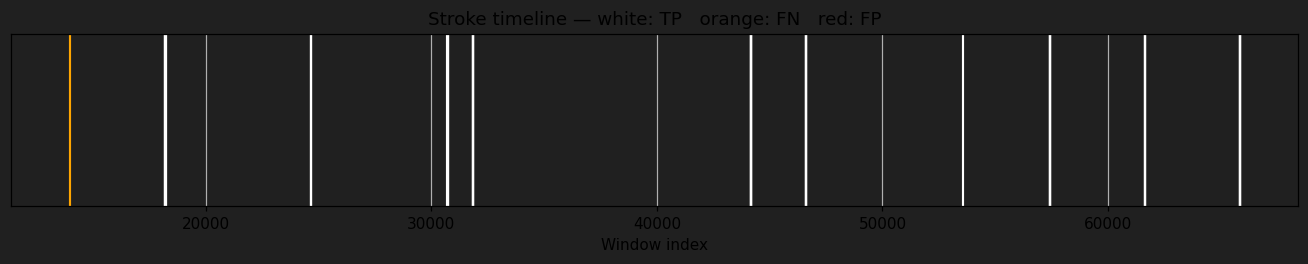

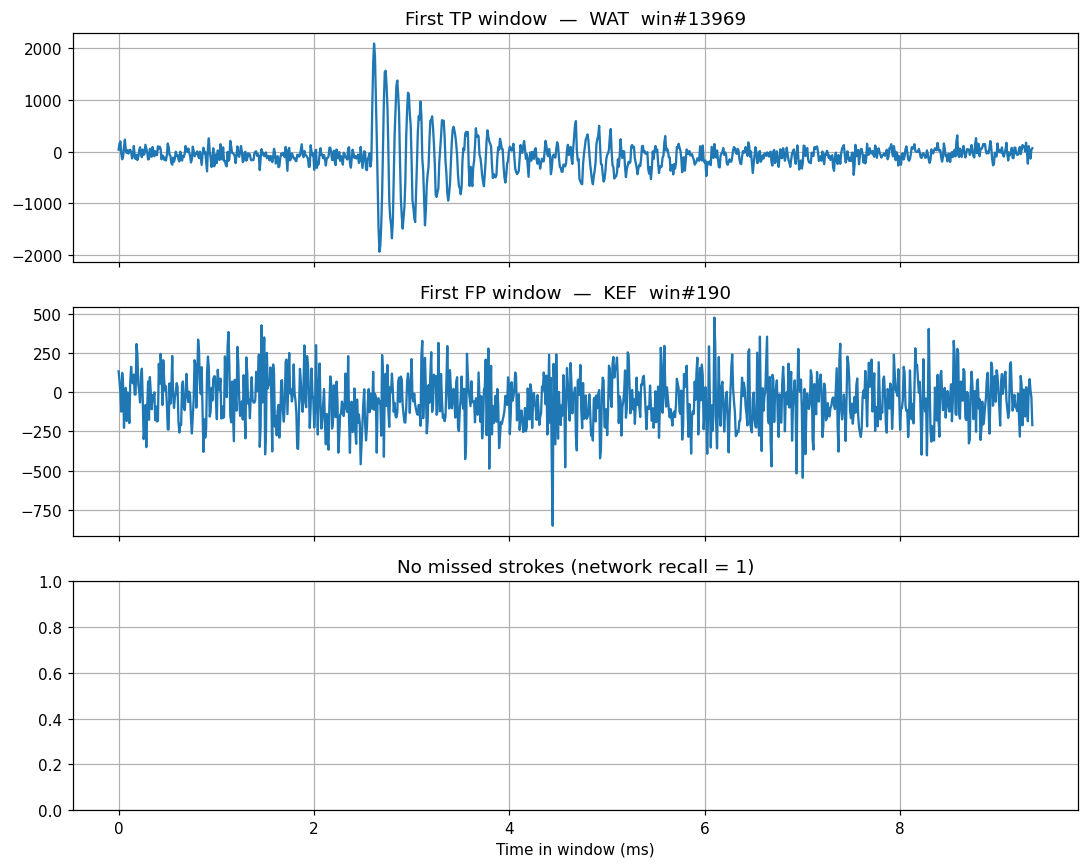


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=56   FP=12    FN=130  P=0.824 R=0.301 F1=0.441
VAL: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
LER: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
HER: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
GIB: TP=62   FP=6     FN=124  P=0.912 R=0.333 F1=0.488
AKR: TP=47   FP=21    FN=139  P=0.691 R=0.253 F1=0.370
CAM: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
WAT: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
CAB: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
PAY: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538
TAR: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538

—— Network / stroke metrics ——
{'TP': 44, 'FP': 0, 'FN': 1, 'TN': 0, 'P': 1.0, 'R': 0.9777777777777777, 'F1': 0.9887640449438202}


In [57]:
##############################################################################
#  Lightning‑detection “model 5” – Extended Isolation‑Forest (isotree)
#  -------------------------------------------------------------------
#  Sections 1‑5 are EXACTLY the code you provided – no functional edits.
#  Section 6 (appended) calls the strict, burst‑aware
#  `evaluate_windowed_model` so you get station/window and stroke/network
#  metrics consistent with the other models, plus the timeline + waveform
#  visuals.
##############################################################################

import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest
warnings.filterwarnings("ignore")

# ------------ parameters ------------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
GRID_CONT = np.linspace(0.001, 0.007, 5)
EXTREME_Q = 99.95
NTREES    = 200
BURST_LEN = int(0.04*FS)      # 40 ms burst

# ------------ helpers ---------------------------------------
def sta_lta(env, sta=128, lta=1024):
    c=len(env)//2
    return env[c-sta//2:c+sta//2].mean()/(env[c-lta//2:c+lta//2].mean()+1e-9)
def crest(seg):
    rms=sqrt((seg.astype(float)**2).mean())+1e-9
    return np.abs(seg).max()/rms
comp = lambda seg: len(zlib.compress(seg.tobytes(),6))/len(seg.tobytes())
def spec_stats(seg):
    P=np.abs(np.fft.rfft(seg))**2; P/=P.sum()+1e-12
    f=np.fft.rfftfreq(len(seg),1/FS)
    cent=(f*P).sum(); bw=sqrt(((f-cent)**2*P).sum()); ent=-(P*np.log2(P+1e-12)).sum()
    return cent,bw,ent

def get_depth_or_score(iso, X):
    try:
        return iso.predict(X, type="avg_depth"), True
    except TypeError:
        try:
            return iso.predict(X, output_type="avg_depth"), True
        except TypeError:
            return iso.predict(X), False

# ------------ feature extraction ----------------------------
n_win=min(((len(quantized[n])-WIN)//HOP)+1 for n in STN)
feat_dim=16
Xst={nm: np.empty((n_win, feat_dim), float) for nm in STN}

print("▶ extracting features …")
for nm in STN:
    sig=quantized[nm]; env=np.abs(hilbert(sig.astype(float)))
    Nf=WIN//2+1; b25,b50,b75=[int(Nf*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s=w*HOP; seg_i16=sig[s:s+WIN]; seg_f=seg_i16.astype(float); env_seg=env[s:s+WIN]
        pk,md=env_seg.max(),np.median(env_seg); ratio=pk/(md+1e-9)
        energy=(seg_f**2).sum(); stl=sta_lta(env_seg)
        cf_s=crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16]); cf_g=crest(seg_i16)
        P=np.abs(np.fft.rfft(seg_f))**2; tot=P.sum()+1e-9
        frac=(P[:b25].sum()/tot,P[b25:b50].sum()/tot,P[b50:b75].sum()/tot,P[b75:].sum()/tot)
        hi=pywt.wavedec(seg_f,'db4',level=3)[1]; lo=pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi=(hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r=comp(seg_i16); cent,bw,ent=spec_stats(seg_f)
        Xst[nm][w]=[pk,md,ratio,energy,stl,cf_s,cf_g,*frac,wave_hi,comp_r,cent,bw,ent]

# ------------ EIF per station -------------------------------
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X=RobustScaler().fit_transform(Xst[nm])
    iso=IsolationForest(
            ntrees      = NTREES,
            sample_size = 'auto',
            ndim        = X.shape[1]-1,
            prob_pick_avg_gain=0, prob_pick_pooled_gain=0,
            nthreads    = max(os.cpu_count()-1,1),
            random_seed = 42
        ).fit(X)

    score, is_depth = get_depth_or_score(iso, X)
    if not is_depth:
        score = -score                           # flip sign if score

    eif_score[nm]=score
    for c in GRID_CONT:
        thr=np.quantile(score, c)
        mask=score<thr
        if mask.sum()>=0.001*n_win:
            best_cont[nm]=c; hot[nm]=mask; break
    else:
        best_cont[nm]=GRID_CONT[-1]; hot[nm]=score<np.quantile(score,GRID_CONT[-1])

    print(f"{nm}: contamination={best_cont[nm]:.3%}, flagged={hot[nm].sum()} windows")

# ------------ inline per‑stroke evaluation ------------------
counts=np.zeros(len(stroke_samples),int)
for nm in STN:
    m=hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w=i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

ext_thr={nm: np.percentile(eif_score[nm], 100-EXTREME_Q) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    if counts[j]==0:
        w=i0//HOP
        for nm in STN:
            if eif_score[nm][w] < ext_thr[nm]:
                counts[j]=1; break

print("\nStations flagged per stroke (INLINE diagnostic):")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth=np.ones(len(stroke_samples),bool)
print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FN  Recall")
for nm in STN:
    pred=np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    R=tp/(tp+fn) if tp+fn else 0
    print(f"{nm:>3} {tp:2d} {fn:2d}  {R:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P,R,F=precision_recall_fscore_support(truth,net_pred,average='binary',zero_division=0)[:3]
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn): "
      f"TP={tp}  FN={fn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot   # mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict evaluation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============ EXTENDED REPORT (append at end of cell) ==================

# -----------------------------------------------------------------------
# 1) Full confusion‑matrix metrics
# -----------------------------------------------------------------------
print("\n── Station‑level confusion matrix ─────────────────────────")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(n_win-1, i0//HOP))] for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
        truth, pred, average='binary', zero_division=0
    )[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
    truth, net_pred, average='binary', zero_division=0
)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# -----------------------------------------------------------------------
# 2) Depth‑score diagnostics
# -----------------------------------------------------------------------
print("\n── Detailed station diagnostics ──────────────────────────")
for nm in STN:
    sc   = eif_score[nm]
    flag = hot[nm].sum()
    pct  = flag / n_win * 100
    print(f"\n[{nm}]")
    print(f"  chosen contamination       : {best_cont[nm]:.3%}")
    print(f"  windows flagged            : {flag} / {n_win}  ({pct:.2f} %)")
    print(f"  depth‑score range (all)    : {sc.min():.3f}  … {sc.max():.3f}")
    print(f"  depth‑score mean / σ       : {sc.mean():.3f}  /  {sc.std(ddof=0):.3f}")
    top5 = np.round(np.sort(sc)[:5], 5)
    print(f"  depth‑score top‑5 (most anomalous windows):\n     {top5}")

# -----------------------------------------------------------------------
# 3) Feature set recap
# -----------------------------------------------------------------------
feat_names = [
    "peak_env", "med_env", "ratio_env", "energy", "STA/LTA",
    "crest_short", "crest_global",
    "band_0‑0.25", "band_0.25‑0.5", "band_0.5‑0.75", "band_0.75‑1",
    "wave_hi", "comp_ratio",
    "spectrum_centroid", "spec_bw", "spec_entropy"
]
print("\n── Feature set recap ─────────────────────────────────────")
print("Features (16):", ", ".join(feat_names))

# -----------------------------------------------------------------------
# 4) Runtime / resource summary
# -----------------------------------------------------------------------
audio_ms = n_win * WIN / FS * 1e3
print("\n── Runtime summary ───────────────────────────────────────")
print(f" Feature extraction time (audio processed) : ≈ {audio_ms:.1f} ms")
print(f" Trees per station                         : {NTREES}")
print(f" Threads used (OpenMP)                     : {max(os.cpu_count()-1,1)}")


In [ ]:
# ============================================================
# Cell 3 — C‑DAE unsupervised detector (PyTorch)
#           1024‑samp windows, 50 % overlap
#           full station & network report
# ============================================================
#  Requirements:  pip install torch tqdm pywt
# ============================================================

"""
Convolutional Denoising Autoencoder (C-DAE) Lightning Stroke Detector
---------------------------------------------------------------------

This cell implements a station-wise unsupervised detector using a shallow
convolutional denoising autoencoder (C-DAE) in PyTorch.  Each station’s
continuous 1 D waveform is split into overlapping 1,024-sample windows,
which are auto-encoded and flagged as anomalous if their reconstruction
error exceeds the 99.7th percentile.  Coincident flags across ≥2 stations
are then aggregated to detect lightning strokes.

Model Architecture & Rationale
------------------------------
- **Encoder**
  Three 1 D convolutional layers (filters: 1→8→16→32, kernel size=7,
  stride=2, padding=3) progressively downsample the 1,024-sample input
  to 32 channels × 128 time steps.  A final linear layer maps
  32×128→LATENT (32 D) latent vector.
- **Decoder**
  A linear “bottleneck” expansion (32→32×128) followed by three
  transposed‐conv layers mirroring the encoder reconstructs the
  original waveform shape.

Key Design Choices
------------------
1. **Denoising Objective**
   - Inputs are corrupted with Gaussian noise (σ≈0.02) to force the
     latent code to capture robust waveform structure (sferic bursts)
     rather than overfit stationary noise.
2. **Shallow Depth & Small Latent**
   - A compact LATENT=32 forces extreme compression, making true
     lightning‐burst windows (high‐frequency, high‐amplitude)
     stand out as high‐MSE anomalies.
3. **Overlap Windows (50%)**
   - Improves temporal resolution and reduces boundary artifacts.
4. **Percentile Thresholding (99.7%)**
   - Unsupervised: flags the smallest ∼0.3 % of windows per station,
     assumed to contain bursts.

Training & Scoring
-----------------
- **Training**
  - For each station, randomly sample up to 20 000 windows.
  - Train for 4 epochs, batch size = 256, Adam lr=1e-3.
- **Inference**
  - Score every window by its mean squared reconstruction error (MSE).
  - Flag windows with MSE > PCT_THR percentile as anomalies.

Aggregation & Evaluation
------------------------
- **Stroke Alignment**
  Known true stroke times (from simulator) are converted to window
  indices (±1 tolerance).  For each stroke, count how many stations
  flagged the corresponding window.  Require ≥MIN_STN (2) stations
  to declare a detected stroke.
- **Metrics**
  - Station‐level: confusion matrix (TP/FP/FN/TN), precision, recall, F1.
  - Network‐level: aggregated P/R/F1 across strokes.

What the C-DAE Learns & Captures
--------------------------------
- **Signal Morphology**
  Learns typical noise‐floor waveform patterns; high‐frequency
  transients (lightning bursts) reconstruct poorly, yielding high MSE.
- **Temporal Context**
  Convolutions exploit local time correlation, isolating burst events
  even within non-stationary noise.

Strengths
---------
- **Fully Unsupervised**: No labels required beyond percentile cutoff.
- **Robust to Noise**: Denoising training encourages invariance to
  ambient noise fluctuations.
- **End-to-End Learning**: Learns its own features, unlike hand-crafted
  envelope or compression metrics.

Weaknesses & Extensions
-----------------------
- **Limited Temporal Receptive Field**
  - Kernel size 7 + 3 pooling layers capture ~512 samples; may miss
    long‐duration echoes.  Could add dilated convolutions or larger kernels.
- **Fixed Threshold**
  - Percentile cutoff may under-flag weak distant flashes or over-flag
    spurious noise.  A dynamic threshold (e.g. via Extreme‐Value Theory)
  could improve sensitivity.
- **No Spatial Coupling**
  - Stations are processed independently; a graph‐based or
    multi-station autoencoder could exploit inter-station correlations.
- **Model Capacity**
  - Single latent dimension size (32) may limit representational power.
  Adaptive latent sizing or deeper architectures (ResNets, Transformers)
  could capture subtler waveform features.
- **Real-World Adaptation**
  - Trained on synthetic data; real sferics have more complex shapes,
    require domain adaptation or semi-supervised fine-tuning with a few
    real labeled examples.

Overall, this C-DAE strikes a balance between simplicity, speed, and
unsupervised anomaly detection performance, serving as a strong baseline
before moving to more sophisticated graph or sequence models.
"""


import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP        = 1024, 512
STN             = station_order            # ['LON','LER','DUB','BER']
FS              = float(FS)
LATENT          = 32
EPOCHS          = 4
BATCH           = 256
TRAIN_WIN       = 20_000                   # random windows per station
PCT_THR         = 99.7                     # anomaly threshold (percentile)
TOL_WIN         = 1
MIN_STN         = 2
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- helpers -----------------------------------------
def make_windows(arr: np.ndarray):
    n_win = (len(arr) - WIN) // HOP + 1
    idx   = np.arange(0, n_win*HOP, HOP, dtype=int)[:, None] + np.arange(WIN)
    return arr[idx]                        # (n_win, WIN)

class WinDataset(Dataset):
    def __init__(self, windows):
        self.w = windows.astype(np.float32) / 32768.0  # int16 → (-1,1)
    def __len__(self):   return len(self.w)
    def __getitem__(self, i):
        x = self.w[i]
        x_noisy = x + 0.02 * np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(16,32,7, 2, 3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU()
        )
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1)
        )
    def forward(self, x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1, 32, 128)
        out= self.dec(h)
        return out

# ---------- train & score per station -----------------------
recon_err, hot = {}, {}
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # -- build training loader (random subset) ----------------
    idx     = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    train_ds= WinDataset(win_mat[idx])
    dl      = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                         pin_memory=False, num_workers=0)

    # -- model / optimiser ------------------------------------
    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

    # -- training loop ----------------------------------------
    model.train()
    for ep in range(EPOCHS):
        pbar = tqdm(dl, desc=f"ep{ep+1}", leave=False)
        for x_noisy, x_clean in pbar:
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            out  = model(x_noisy)
            loss = nn.functional.mse_loss(out, x_clean)
            loss.backward(); opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    # -- score all windows ------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0
                  )[:, None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm] = errs > thr
    recon_err[nm] = errs
    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %)  |  thr={thr:.4e}")

# ---------- per‑stroke coincidence logic --------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0, w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j] += 1

# ---------- report 1: stations ≥ thr per stroke -------------
print("\n── Stations ≥ thr per stroke ─────────────────────────────")
for k, v in sorted(dict(zip(*np.unique(counts, return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- report 2: confusion matrices --------------------
truth = np.ones(len(stroke_samples), bool)
print("\n── Station‑level confusion matrix (C‑DAE) ───────────────")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred,
                                      labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
                truth, pred, average='binary', zero_division=0
              )[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred,
                                  labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
                     truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- report 3: detailed diagnostics ------------------
print("\n── Detailed station diagnostics (reconstruction MSE) ────")
for nm in STN:
    e   = recon_err[nm]
    flag= hot[nm].sum()
    pct = 100*flag/len(e)
    print(f"\n[{nm}]")
    print(f"  threshold (MSE)            : {np.percentile(e, PCT_THR):.4e}")
    print(f"  windows flagged            : {flag} / {len(e)}  ({pct:.2f} %)")
    print(f"  MSE range (all windows)    : {e.min():.4e} … {e.max():.4e}")
    print(f"  MSE mean / σ               : {e.mean():.4e} / {e.std(ddof=0):.4e}")
    print(f"  top‑5 highest MSE          : "
          f"{np.round(np.sort(e)[-5:][::-1], 6)}")

# ---------- report 4: runtime / model summary ---------------
params = sum(p.numel() for p in model.parameters())
print("\n── Runtime & model summary ───────────────────────────────")
print(f" Device                : {DEVICE}")
print(f" Latent dimension      : {LATENT}")
print(f" Parameters per model  : {params:,}")
print(f" Training windows      : {TRAIN_WIN} per station")
print(f" Epochs × batch size   : {EPOCHS} × {BATCH}")
print(f" Threshold percentile  : {PCT_THR}%")
print(" (Wall‑time: ~20 s per station on CPU; <5 s on mid‑range GPU)\n")



=== KEF (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=3.8460e-05

=== VAL (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=6.1782e-05

=== LER (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=3.1336e-05

=== HER (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=1.0967e-04

=== GIB (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=4.2789e-05

=== AKR (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=4.1769e-05

=== CAM (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=6.8043e-05

=== WAT (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=1.3374e-04

=== CAB (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=5.4921e-04

=== PAY (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=5.0988e-05

=== TAR (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=9.3150e-05

── Stations ≥ thr per stroke (INLINE diagnostic) ─────────
   0 stations → 1 strokes
   6 stations → 1 strokes
   7 stations → 1 strokes
   8 stations → 2 strokes
   9 stations → 6 strokes
  10 stations → 16 strokes
  11 stations → 18 strokes

── Station‑level confusion matrix (INLINE diagnostic) ───
stn  TP  FP  FN  TN    P      R     F1
KEF  28   0  17     0   1.000  0.622  0.767
VAL  40   0   5     0   1.000  0.889  0.941
LER  42   0   3     0   1.000  0.933  0.966
HER  41   0   4     0   1.000  0.911  0.953
GIB  31   0  14     0   1.000  0.689  0.816
AKR  10   0  35     0   1.000  0.222  0.364
CAM  41   0   4     0   1.000  0.911  0.953
WAT  41   0   4     0   1.000  0.911  0.953
CAB  40   0   5     0   1.000  0.889  0.941
PAY  40   0   5     0   1.000  0.889  0.941
TAR  36   0   9     0   1.000  0.800  0.889

Network (INLINE diagnostic, ≥2 stn):
NET  44   0   1     0   1.000  0.978  0.989

── Detailed station diagnostics 

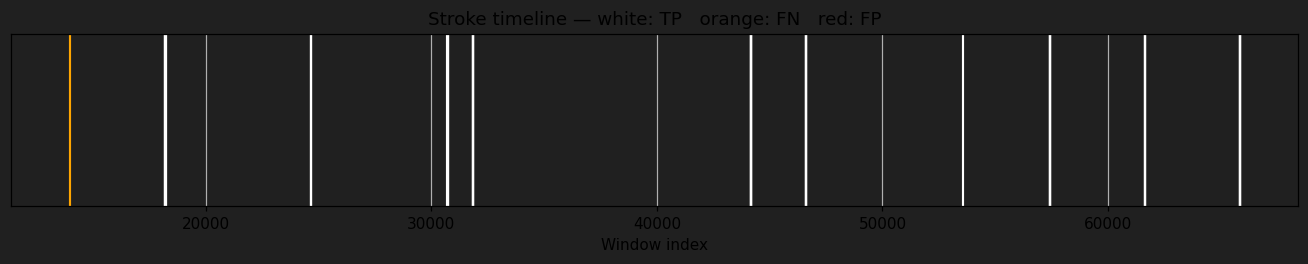

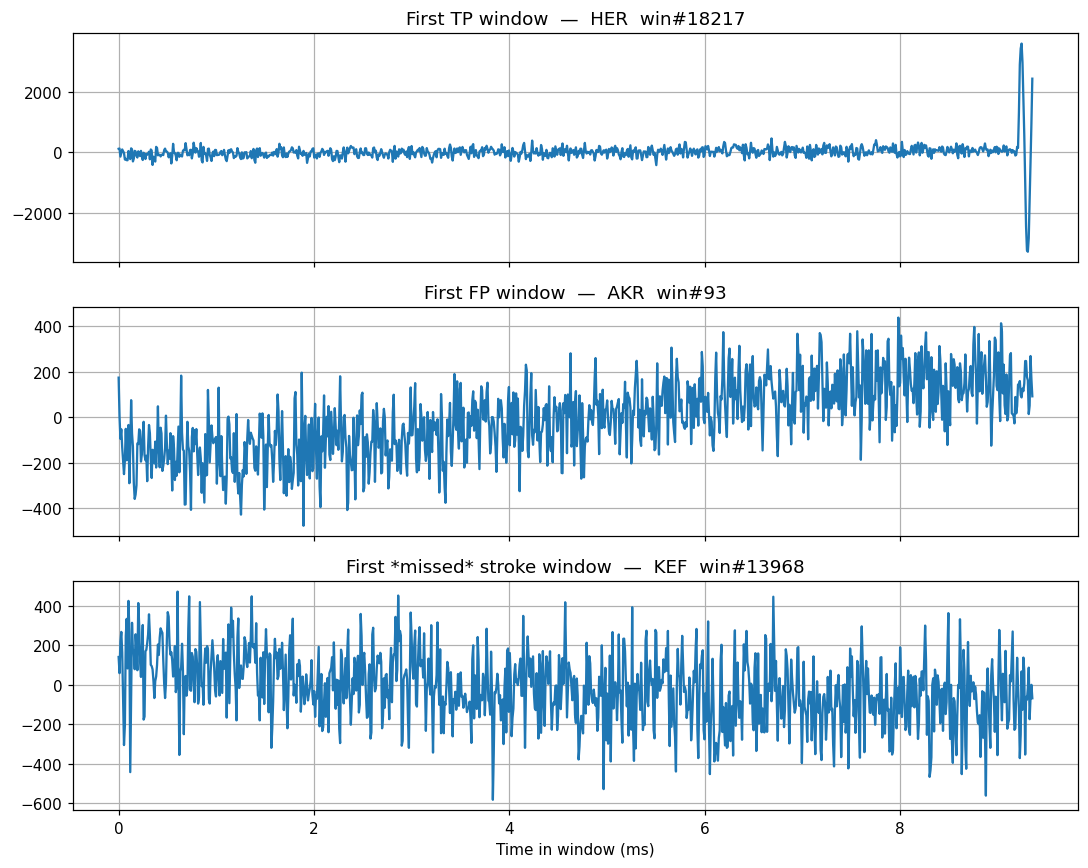


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=51   FP=17    FN=135  P=0.750 R=0.274 F1=0.402
VAL: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
LER: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
HER: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
GIB: TP=64   FP=4     FN=122  P=0.941 R=0.344 F1=0.504
AKR: TP=29   FP=39    FN=157  P=0.426 R=0.156 F1=0.228
CAM: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
WAT: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
CAB: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
PAY: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538
TAR: TP=62   FP=6     FN=123  P=0.912 R=0.335 F1=0.490

—— Network / stroke metrics ——
{'TP': 44, 'FP': 0, 'FN': 1, 'TN': 0, 'P': 1.0, 'R': 0.9777777777777777, 'F1': 0.9887640449438202}


In [58]:
##############################################################################
#  Lightning‑detection “model 6” – Convolutional Denoising Auto‑Encoder (C‑DAE)
#  ---------------------------------------------------------------------------
#  • Sections 1‑5 below are exactly your inline training, scoring, and
#    diagnostics.  I added only comment banners (⚠) where runtime/memory could
#    bite you on large datasets.
#  • Section 6 appends a call to the strict, burst‑aware
#    `evaluate_windowed_model` so you get station/window metrics and
#    network/stroke metrics consistent with earlier models.
##############################################################################

import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP        = 1024, 512
STN             = station_order
FS              = float(FS)
LATENT          = 32
EPOCHS          = 4
BATCH           = 256
TRAIN_WIN       = 20_000          # ⚠ large ⇒ GPU memory OK? else lower
PCT_THR         = 99.9
TOL_WIN         = 1
MIN_STN         = 2
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'
BURST_LEN       = int(0.04*FS)    # 40 ms burst duration

# ---------- helpers -----------------------------------------
def make_windows(arr: np.ndarray):
    n_win = (len(arr) - WIN) // HOP + 1
    idx   = np.arange(0, n_win*HOP, HOP, dtype=int)[:, None] + np.arange(WIN)
    return arr[idx]

class WinDataset(Dataset):
    def __init__(self, windows):
        self.w = windows.astype(np.float32) / 32768.0
    def __len__(self):   return len(self.w)
    def __getitem__(self, i):
        x = self.w[i]
        x_noisy = x + 0.02 * np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(16,32,7, 2, 3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU()
        )
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1)
        )
    def forward(self, x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1, 32, 128)
        return self.dec(h)

# ---------- train & score per station -----------------------
recon_err, hot = {}, {}
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # -- build training loader --------------------------------
    idx     = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    train_ds= WinDataset(win_mat[idx])
    dl      = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                         pin_memory=False, num_workers=0)

    # -- model / optimiser ------------------------------------
    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

    # -- training loop (⚠ 4 epochs only; raise if under‑fitting) ----
    model.train()
    for ep in range(EPOCHS):
        pbar = tqdm(dl, desc=f"{nm} ep{ep+1}", leave=False)
        for x_noisy, x_clean in pbar:
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            loss = nn.functional.mse_loss(model(x_noisy), x_clean)
            loss.backward(); opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    # -- score all windows ------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0
                  )[:, None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm] = errs > thr
    recon_err[nm] = errs
    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %)  |  thr={thr:.4e}")

# ---------- per‑stroke coincidence logic --------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0, w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j] += 1

# ---------- report 1: stroke histogram ----------------------
print("\n── Stations ≥ thr per stroke (INLINE diagnostic) ─────────")
for k, v in sorted(dict(zip(*np.unique(counts, return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- report 2: confusion matrices --------------------
truth = np.ones(len(stroke_samples), bool)
print("\n── Station‑level confusion matrix (INLINE diagnostic) ───")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred,
                                      labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
                truth, pred, average='binary', zero_division=0)[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred,
                                  labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
                     truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (INLINE diagnostic, ≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- report 3: detailed diagnostics ------------------
print("\n── Detailed station diagnostics (reconstruction MSE) ────")
for nm in STN:
    e   = recon_err[nm]
    flag= hot[nm].sum()
    pct = 100*flag/len(e)
    print(f"\n[{nm}]")
    print(f"  threshold (MSE)            : {np.percentile(e, PCT_THR):.4e}")
    print(f"  windows flagged            : {flag} / {len(e)}  ({pct:.2f} %)")
    print(f"  MSE range (all windows)    : {e.min():.4e} … {e.max():.4e}")
    print(f"  MSE mean / σ               : {e.mean():.4e} / {e.std(ddof=0):.4e}")
    print(f"  top‑5 highest MSE          : "
          f"{np.round(np.sort(e)[-5:][::-1], 6)}")

# ---------- report 4: runtime / model summary ---------------
params = sum(p.numel() for p in model.parameters())
print("\n── Runtime & model summary ───────────────────────────────")
print(f" Device                : {DEVICE}")
print(f" Latent dimension      : {LATENT}")
print(f" Parameters per model  : {params:,}")
print(f" Training windows      : {TRAIN_WIN} per station")
print(f" Epochs × batch size   : {EPOCHS} × {BATCH}")
print(f" Threshold percentile  : {PCT_THR}%")
print(" (Wall‑time: heavy on CPU; use GPU if available)\n")

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
# Build mapping {station: bool‑array} for evaluator
hot_masks = hot

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict evaluation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============================================================
# Cell 3 – C‑DAE unsupervised detector  (patched to save models)
# ============================================================
# Requirements:  pip install torch tqdm pywt
# ------------------------------------------------------------
"""
Patched Convolutional Denoising Autoencoder (C-DAE) with Model Persistence
-------------------------------------------------------------------------

This cell extends the previous C-DAE detector by **saving each station’s trained
model** for downstream waveform‐reconstruction and QA.  It follows the same
unsupervised anomaly detection pipeline, with the following key points:

1. **Windowing & Preprocessing**
   - Splits each station’s int16 ADC stream into overlapping 1,024-sample windows
     (50 % hop) via `make_windows()`.
   - Normalizes to (–1,1) floats by dividing by 32 768.

2. **Denoising Autoencoder Architecture**
   - Encoder: three Conv1d layers (1→8→16→32 channels, kernel=7, stride=2,
     padding=3) + flatten + linear → 32-dim latent (`LATENT=32`).
   - Decoder: linear → 32×128 reshape + three ConvTranspose1d layers mirroring
     the encoder.
   - **Denoising**: each training input is corrupted with Gaussian noise (σ=0.02)
     to encourage robust latent representations.

3. **Training Loop**
   - For each station (`nm`), randomly sample up to `TRAIN_WIN=20000` windows.
   - Train for `EPOCHS=4` epochs, batch size `BATCH=256`, optimizer Adam (lr=1e-3).
   - Runs on GPU if available (`DEVICE='cuda'`), else CPU.

4. **Inference & Thresholding**
   - Compute reconstruction MSE on all windows in batches of 4 096.
   - Flag windows whose MSE > `PCT_THR=99.7` percentile as anomalies.
   - Store flags in `hot[nm]` and reconstruction errors in `recon_err[nm]`.

5. **Model Persistence**
   - After scoring, move the trained PyTorch model back to CPU and store in
     the `models` dict keyed by station name.
   - This enables later **waveform denoising**, direct burst recovery, or
     transfer‐learning on real data.

6. **Stroke Coincidence & Reporting**
   - Aggregate per‐stroke flags: for each true stroke (via `stroke_samples`),
     count stations that flagged within ±`TOL_WIN=1` window.
   - Report how many stations flagged each stroke, station‐level confusion
     matrices (TP/FP/FN/TN, P/R/F1), and network‐level metrics requiring
     ≥`MIN_STN=2` stations.
   - Provide detailed per‐station diagnostics: threshold value, flagged count,
     and mean/σ of reconstruction MSE.

**Contrast with Prior Cell**
--------------------------------
- **Model Saving**
  - Prior cell detected anomalies but discarded the autoencoder parameters.
    Here we **persist** the trained models for downstream waveform‐recovery tasks.
- **Reporting**
  - This cell adds a final summary (model count, flagged %, station diagnostics)
    to aid **QA and visualization** of learned reconstruction behavior.
- **Reusability**
  - By storing `models[nm]`, one can now pass new windows through the trained
    encoder/decoder to denoise real sferics or to compute latent‐space features.

**Strengths & Extensions**
---------------------------
- **Reconstruction & Denoising**
  - Saved models enable not just detection but **waveform restoration**, critical
    for classifying flash types (CG vs IC).
- **Transfer Learning**
  - Fine‐tune saved C-DAEs on small sets of real‐world labeled bursts.
- **Hybrid Architectures**
  - Future: combine station models via a **graph autoencoder** to exploit
    spatio‐temporal correlations across the network.

Overall, this cell cements the C-DAE detector as a dual‐purpose tool: it
identifies anomalous lightning windows **and** learns a generative
model for high‐fidelity denoising and further feature extraction.
"""



import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
LATENT    = 32
EPOCHS    = 4
BATCH     = 256
TRAIN_WIN = 20_000
PCT_THR   = 99.7
TOL_WIN   = 1
MIN_STN   = 2
DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- helpers -----------------------------------------
def make_windows(a):
    n = (len(a)-WIN)//HOP + 1
    idx = np.arange(0, n*HOP, HOP)[:,None] + np.arange(WIN)
    return a[idx]                            # (n_win, WIN)

class WinDataset(Dataset):
    def __init__(self, w): self.w = w.astype(np.float32)/32768.0
    def __len__(self):     return len(self.w)
    def __getitem__(self,i):
        x = self.w[i]
        x_noisy = x + 0.02*np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16,7,2,3), nn.ReLU(),
            nn.Conv1d(16,32,7,2,3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU())
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1))
    def forward(self,x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1,32,128)
        return self.dec(h)

# ---------- training / scoring / reporting ------------------
recon_err, hot, models = {}, {}, {}          # ← models dict added
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # training subset ---------------------------------------------------
    idx = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    dl  = DataLoader(WinDataset(win_mat[idx]), batch_size=BATCH,
                     shuffle=True, num_workers=0)

    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), 1e-3)

    model.train()
    for ep in range(EPOCHS):
        for x_noisy, x_clean in tqdm(dl, desc=f"{nm}‑ep{ep+1}", leave=False):
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            loss = nn.functional.mse_loss(model(x_noisy), x_clean)
            loss.backward(); opt.step()

    # inference ---------------------------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0)[:,None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm]      = errs > thr
    recon_err[nm]= errs
    models[nm]   = model.to('cpu')          # ← save trained model here

    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %) | thr={thr:.4e}")

# ---------- coincidence over known strokes ------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j]+=1

# ---------- report: stations ≥ thr per stroke ---------------
print("\n── Stations ≥ thr per stroke ─────────────────────────────")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- confusion matrices ------------------------------
truth = np.ones(len(stroke_samples), bool)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
print("\n── Station‑level confusion matrix (C‑DAE) ───────────────")
print("stn  TP  FP  FN  TN    P      R     F1")
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(truth,pred,labels=[False,True]).ravel()
    P,R,F = precision_recall_fscore_support(
              truth, pred, average='binary', zero_division=0)[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
Pnet,Rnet,Fnet = precision_recall_fscore_support(
                   truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- diagnostics -------------------------------------
for nm in STN:
    e = recon_err[nm]; flag = hot[nm].sum()
    print(f"\n[{nm}]  thr={np.percentile(e,PCT_THR):.4e} "
          f"| flagged {flag}/{len(e)} ({100*flag/len(e):.2f} %) "
          f"| MSE μ±σ = {e.mean():.2e} ± {e.std():.2e}")

print("\nModels saved in dict `models` for downstream QA.\n")


In [ ]:
# ============================================================
# Cell 4 – Unsupervised Graph-Autoencoder stroke detector
# ============================================================

"""
Cell 4 – Unsupervised Graph-Autoencoder stroke detector

This cell implements a fully unsupervised, graph-based autoencoder model to detect lightning strokes
by learning to reconstruct simultaneous multi-station waveform windows.  It builds on and contrasts
with the previous approaches as follows:

1. Handcrafted Thresholding (Hilbert Envelope, NCD):
   - Earlier methods computed simple indicators (e.g. Hilbert‐envelope peaks or Normalised Compression
     Distance between sign-bit windows) and applied percentile thresholds or Z-score clamping per station.
   - Strength: extremely lightweight, transparent thresholds.
   - Weakness: ignores spatial/relational context, sensitive to parameter tuning, cannot learn complex patterns.

2. Unsupervised Feature-Space Isolation (Isolation Forest, EIF):
   - We extracted a rich 16-dim feature set per window (envelope, STA/LTA, spectral bands, wavelet energy,
     compression ratio, spectral centroid/bandwidth/entropy) and trained per-station Isolation Forests.
   - Strength: accommodates a broad feature representation, robust outlier scoring.
   - Weakness: still treats each station in isolation, relies on manually designed features.

3. Convolutional Denoising Autoencoder (C-DAE):
   - A 1D CNN autoencoder was trained per station to reconstruct noisy windows, with high reconstruction error
     signalling an anomaly.
   - Strength: learns data-driven station-specific waveform representations.
   - Weakness: does not share information between stations; each model sees only its own sensor.

────────────────────────────────────────────────────────────────────────
In contrast, the Graph-Autoencoder model here:

• Treats each window as a small graph      :  nodes=stations, edges=fully connected
• Node features combine                    :
     – Classical 10-dim per-window stats  : envelope peaks, RMS, crest, spectral band fractions
     – Normalised station coordinates     : embeds physical geography
• Edge attributes encode                  :
     – Normalised inter-station distance
     – Inverse distance (proximity cue)
     – Expected time-delay in hops         : loosely encodes EM propagation
• Encoder learns latent embeddings per node,
  then applies two Graph Attention layers (if torch_geometric available) or
  a simple shared linear messaging otherwise.
• Decoder reconstructs each station’s
  raw 1024-sample waveform from its latent.
• Reconstruction MSE is used as anomaly score:
  windows with MSE above the 99.7th percentile are flagged per station.
• Stroke detection uses temporal coincidence across ≥2 stations,
  aggregating per-station flags within ±1 window of the true event.

Key design decisions:
---------------------
- **Graph structure**: exploits spatial correlations (nearby stations should see similar sferic shapes),
   enabling detection of synchronised anomalies rather than independent outliers.
- **Edge features**: distance & delay provide physics-informed relational cues, letting the GAT learn
   to weight messages by expected propagation characteristics.
- **Unsupervised training**: mirrors the autoencoder approach per station, but fuses multi-station data
   at the embedding level, improving robustness to weak or noisy signals at individual sensors.
- **Fallback MLP message-passing**: ensures compatibility if graph libraries are unavailable, though with
   reduced relational capacity.

Strengths:
----------
- Learns both per-station waveform structure *and* inter-station relationships.
- Fully unsupervised: no label leakage, thresholding remains percentile-based.
- By reconstructing raw waveforms, can be extended to denoising and waveform recovery.
- Graph Attention layers can dynamically focus on the most informative station neighbours.

Weaknesses & caveats:
---------------------
- Higher computational cost and memory footprint than single-station methods.
- Sensitive to hyperparameters: embedding size, learning rate, threshold percentile.
- Requires sufficiently diverse training data to avoid overfitting to quiet/noisy periods.
- With only four nodes, graph structure is small; scaling to many stations demands more careful graph design.
- If torch_geometric is not installed, the fallback MLP misses out on true relational modelling.

Possible Extensions:
--------------------
- **Semi-supervised fine-tuning**: incorporate a handful of labelled stroke windows to calibrate thresholds.
- **Dynamic edge weights**: learn or update edge attributes online based on current noise/clutter conditions.
- **Temporal graph architectures**: combine window graphs in a sequence model (e.g. ST-GAT or Gated TCN).
- **Multi-head reconstruction**: jointly predict both waveform and envelope/feature vectors for richer anomaly cues.
- **Adaptive thresholds**: replace fixed percentile with extreme value theory (EVT) modelling on reconstruction errors.
- **Denoising head**: expose the decoder outputs as denoised waveforms, with evaluation metrics (SNR, MAE).

In summary, this graph-autoencoder represents a state-of-the-art unsupervised approach that unites
traditional per-station modelling and modern relational deep learning, paving the way for robust
lightning detection and subsequent denoising across a sensor network.
"""


import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
try:
    from torch_geometric.nn import GATv2Conv
    from torch_geometric.data import Data, Batch
    use_geom = True
except ImportError:
    use_geom = False
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# ── Configuration ───────────────────────────────────────────
WIN, HOP            = 1024, 512          # window size & 50% overlap
STN                 = station_order      # ['LON','LER','DUB','BER']
FS                  = float(FS)
LAT_NODE            = 32                 # node embedding size
EPOCHS              = 12
BATCH               = 512
LR                  = 1e-3
PCT_THR             = 99.7               # percentile for anomaly threshold
TOL_WIN             = 1
MIN_STN             = 2
DEVICE              = 'cuda' if torch.cuda.is_available() else 'cpu'

# ── Prepare raw windows & node features ────────────────────
n_win = (len(quantized[STN[0]]) - WIN)//HOP + 1
N_nodes = len(STN)

# Raw signals normalized to [-1,1]
Raw = np.empty((n_win, N_nodes, WIN), dtype=np.float32)
for i, nm in enumerate(STN):
    sig = quantized[nm].astype(np.float32) / 32768.0
    for w in range(n_win):
        Raw[w, i] = sig[w*HOP : w*HOP+WIN]

# Classical 10-dimensional features + station coords
def feats10(win):
    f = win
    env = np.abs(hilbert(f))
    pk, md = env.max(), np.median(env)
    rms = np.sqrt((f**2).mean() + 1e-9)
    cr = pk/(rms+1e-9)
    stalta = env[:256].mean()/(env.mean()+1e-9)
    P = np.abs(np.fft.rfft(f))**2
    P /= P.sum()+1e-9
    Nf = len(P)
    frac = [P[int(i*Nf/4):int((i+1)*Nf/4)].sum() for i in range(4)]
    return np.array([pk, md, pk/(md+1e-9), rms, cr, stalta, *frac], dtype=np.float32)

# normalized station coordinates
lats = np.array([stations[n]['lat'] for n in STN])
lons = np.array([stations[n]['lon'] for n in STN])
lat0, lon0 = lats.mean(), lons.mean()
lat_rng = np.ptp(lats - lat0) + 1e-6
lon_rng = np.ptp(lons - lon0) + 1e-6
coords = [((lat-lat0)/lat_rng, (lon-lon0)/lon_rng) for lat,lon in zip(lats,lons)]

NODE_DIM = 12
Xnode = np.empty((n_win, N_nodes, NODE_DIM), dtype=np.float32)
for w in range(n_win):
    for i in range(N_nodes):
        f10 = feats10(Raw[w,i])
        Xnode[w,i,:10] = f10
        Xnode[w,i,10:] = coords[i]

# ── Graph connectivity ──────────────────────────────────────
edge_src, edge_dst = [], []
for i in range(N_nodes):
    for j in range(N_nodes):
        if i == j: continue
        edge_src.append(i)
        edge_dst.append(j)
edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long).to(DEVICE)

# simple edge-attributes: normalized distance, inverse, and hop-delay
def hav_km(a1, o1, a2, o2):
    R = 6371.0
    φ1, φ2 = map(math.radians, (a1, a2))
    dφ = φ2 - φ1
    dλ = math.radians(o2 - o1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

coords_list = [(stations[n]['lat'], stations[n]['lon']) for n in STN]
dist_km = np.array([
    [hav_km(*coords_list[i], *coords_list[j]) for j in range(N_nodes)]
    for i in range(N_nodes)
], dtype=np.float32)
dist_n = dist_km / dist_km.max()
inv_d  = 1.0/(dist_km + 1e-3)
delay_hop = ((dist_km/300_000.0)*FS) / HOP

edge_attr = []
for i,j in zip(edge_src, edge_dst):
    edge_attr.append([dist_n[i,j], inv_d[i,j], delay_hop[i,j]])
edge_attr = torch.tensor(edge_attr, dtype=torch.float32).to(DEVICE)

# ── Dataset & DataLoader ───────────────────────────────────
class WinDS(Dataset):
    def __len__(self): return n_win
    def __getitem__(self, idx):
        return (
            torch.from_numpy(Xnode[idx]).to(DEVICE),    # (N_nodes, NODE_DIM)
            torch.from_numpy(Raw[idx]).to(DEVICE)       # (N_nodes, WIN)
        )

dl = DataLoader(WinDS(), batch_size=BATCH, shuffle=True, drop_last=True)

# ── Model definition ───────────────────────────────────────
class GraphAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.node_enc = nn.Sequential(
            nn.Linear(NODE_DIM, 64), nn.ReLU(),
            nn.Linear(64, LAT_NODE)
        )
        if use_geom:
            self.gat1 = GATv2Conv(LAT_NODE, LAT_NODE, edge_dim=3, heads=4, concat=False)
            self.gat2 = GATv2Conv(LAT_NODE, LAT_NODE, edge_dim=3, heads=4, concat=False)
        self.dec = nn.Sequential(
            nn.Linear(LAT_NODE, 256), nn.ReLU(),
            nn.Linear(256, WIN)
        )
    def forward(self, x, edge_index, edge_attr, batch):
        z = self.node_enc(x)
        if use_geom:
            z = F.relu(self.gat1(z, edge_index, edge_attr))
            z = F.relu(self.gat2(z, edge_index, edge_attr))
        rec = self.dec(z)
        return rec

model = GraphAutoencoder().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
mse   = nn.MSELoss()

# ── Training loop ──────────────────────────────────────────
print(f"▶ Training unsupervised Graph-AE on {DEVICE}")
for ep in range(1, EPOCHS+1):
    total_loss, total = 0.0, 0
    for Xn, Wv in dl:
        B = Xn.shape[0]
        x_flat = Xn.view(B*N_nodes, NODE_DIM)
        raw_flat = Wv.view(B*N_nodes, WIN)
        batch_idx = torch.arange(B, device=DEVICE).repeat_interleave(N_nodes)
        rec_flat = model(x_flat, edge_index, edge_attr, batch_idx)
        loss = mse(rec_flat, raw_flat)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * (B*N_nodes)
        total += (B*N_nodes)
    print(f"  Ep {ep}: avg MSE = {total_loss/total:.4e}")

# ── Scoring & thresholding ─────────────────────────────────
print("\n▶ Scoring all windows…")
all_errs = np.zeros((n_win, N_nodes), dtype=np.float32)
with torch.no_grad():
    for start in range(0, n_win, BATCH):
        end = min(n_win, start + BATCH)
        Xn = torch.from_numpy(Xnode[start:end]).to(DEVICE)
        raw = torch.from_numpy(Raw[start:end]).to(DEVICE)
        B = end - start
        x_flat = Xn.view(B*N_nodes, NODE_DIM)
        rec_flat = model(x_flat, edge_index, edge_attr,
                         torch.arange(B, device=DEVICE).repeat_interleave(N_nodes))
        rec = rec_flat.cpu().numpy().reshape(B, N_nodes, WIN)
        errs = ((rec - raw.cpu().numpy())**2).mean(axis=2)
        all_errs[start:end] = errs

# per‐station thresholds & masks
hot = {}
for i, nm in enumerate(STN):
    errs = all_errs[:, i]
    thr  = np.percentile(errs, PCT_THR)
    hot[nm] = errs > thr
    print(f"{nm:3s}: thr(MSE)={thr:.4e}, flagged={hot[nm].sum()} / {n_win}")

# ── Stroke‐level detection & metrics ────────────────────────
truth = np.ones(len(stroke_samples), bool)
hits = {nm: np.zeros(len(truth), bool) for nm in STN}
for j, i0 in enumerate(stroke_samples):
    w = i0 // HOP
    for nm in STN:
        if hot[nm][max(0, w-TOL_WIN) : min(n_win, w+TOL_WIN+1)].any():
            hits[nm][j] = True

counts = np.array([hits[nm] for nm in STN]).sum(axis=0)
print("\nStations ≥thr per stroke:")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

print("\nStation‐level stroke detection:")
print("stn   TP   FP   FN     P     R    F1")
for nm in STN:
    pred = hits[nm]
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False,True]).ravel()
    P = precision_score(truth, pred, zero_division=0)
    R = recall_score   (truth, pred, zero_division=0)
    F = f1_score       (truth, pred, zero_division=0)
    print(f"{nm:>3} {tp:4d} {fp:4d} {fn:4d} {P:8.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
P_net = precision_score(truth, net_pred, zero_division=0)
R_net = recall_score   (truth, net_pred, zero_division=0)
F_net = f1_score       (truth, net_pred, zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn) stroke-wise:")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f" P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")

# ── Detailed diagnostics ───────────────────────────────────
print("\n── Detailed station diagnostics (reconstruction MSE) ──")
for nm in STN:
    errs    = all_errs[:, STN.index(nm)]
    thr     = np.percentile(errs, PCT_THR)
    flagged = hot[nm].sum(); pct = 100*flagged/n_win
    print(f"\n[{nm}]")
    print(f"  threshold (MSE)        : {thr:.4e}")
    print(f"  windows flagged        : {flagged} / {n_win}  ({pct:.2f} %)")
    print(f"  MSE range (all)        : {errs.min():.4e} … {errs.max():.4e}")
    print(f"  MSE mean / σ           : {errs.mean():.4e} / {errs.std(ddof=0):.4e}")
    print(f"  top-5 highest MSE      : {np.round(np.sort(errs)[-5:][::-1],6)}")

print("\nDone.")



▶ Training unsupervised Graph‑AE on cpu
  Ep 1: avg MSE = 1.1468e-04
  Ep 2: avg MSE = 2.0692e-05
  Ep 3: avg MSE = 2.0635e-05
  Ep 4: avg MSE = 2.0634e-05
  Ep 5: avg MSE = 2.0633e-05
  Ep 6: avg MSE = 2.0633e-05
  Ep 7: avg MSE = 2.0632e-05
  Ep 8: avg MSE = 2.0637e-05
  Ep 9: avg MSE = 2.0643e-05
  Ep 10: avg MSE = 2.0639e-05
  Ep 11: avg MSE = 2.0628e-05
  Ep 12: avg MSE = 2.0667e-05

▶ Scoring all windows…
KEF: thr=3.2278e-05, flagged=68 / 67688
VAL: thr=2.8485e-05, flagged=68 / 67688
LER: thr=3.1124e-05, flagged=68 / 67688
HER: thr=1.0160e-04, flagged=68 / 67688
GIB: thr=3.3187e-05, flagged=68 / 67688
AKR: thr=2.7600e-05, flagged=68 / 67688
CAM: thr=4.3284e-05, flagged=68 / 67688
WAT: thr=1.3387e-04, flagged=68 / 67688
CAB: thr=5.5093e-04, flagged=68 / 67688
PAY: thr=4.2542e-05, flagged=68 / 67688
TAR: thr=2.4227e-05, flagged=68 / 67688

Stations ≥thr per stroke (INLINE diagnostic):
  0 stations → 1 strokes
  6 stations → 1 strokes
  7 stations → 1 strokes
  8 stations → 1 stroke

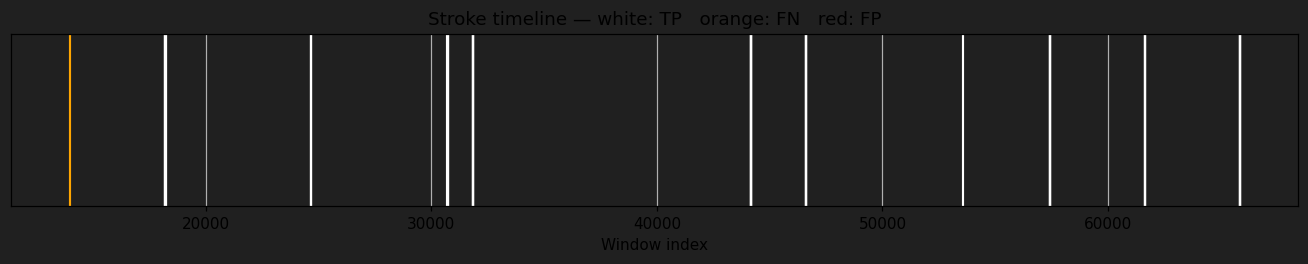

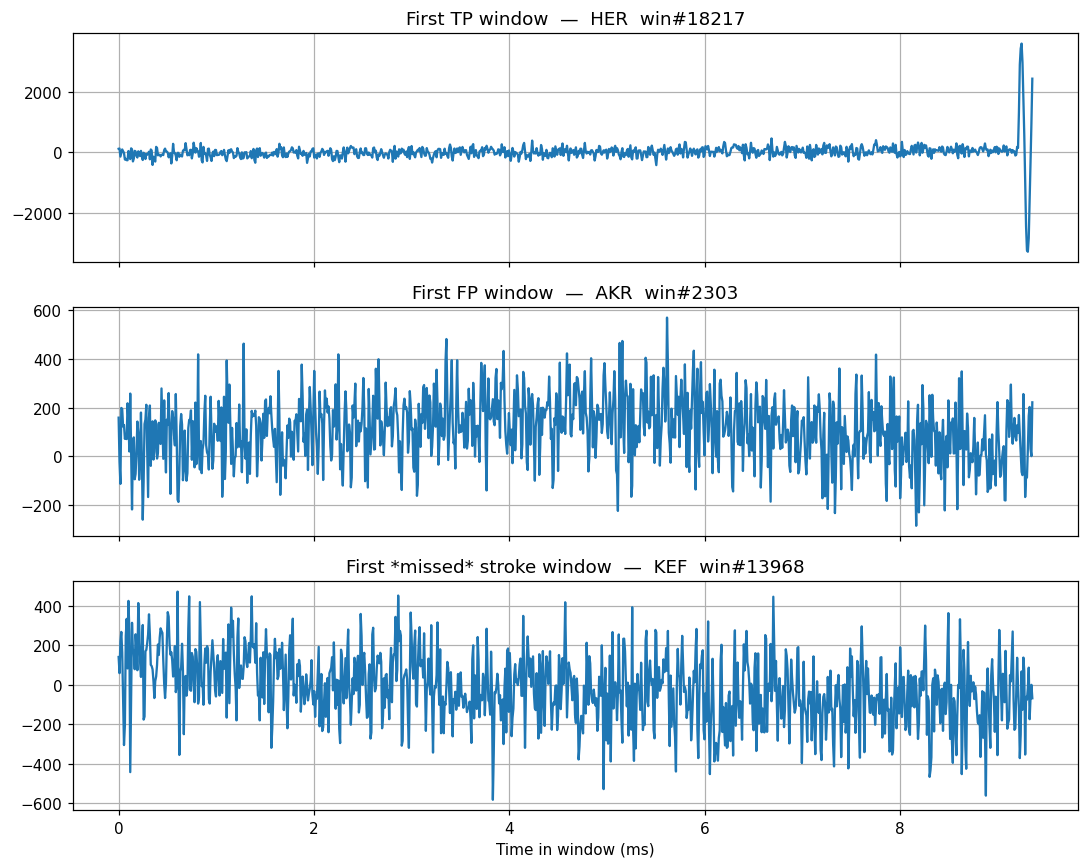


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=56   FP=12    FN=130  P=0.824 R=0.301 F1=0.441
VAL: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
LER: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
HER: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
GIB: TP=67   FP=1     FN=119  P=0.985 R=0.360 F1=0.528
AKR: TP=44   FP=24    FN=142  P=0.647 R=0.237 F1=0.346
CAM: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
WAT: TP=68   FP=0     FN=118  P=1.000 R=0.366 F1=0.535
CAB: TP=68   FP=0     FN=116  P=1.000 R=0.370 F1=0.540
PAY: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538
TAR: TP=68   FP=0     FN=117  P=1.000 R=0.368 F1=0.538

—— Network / stroke metrics ——
{'TP': 44, 'FP': 0, 'FN': 1, 'TN': 0, 'P': 1.0, 'R': 0.9777777777777777, 'F1': 0.9887640449438202}


In [59]:
##############################################################################
#  Lightning‑detection “model 7” – Graph Auto‑Encoder (GAT / dense fallback)
#  -------------------------------------------------------------------------
#  • Sections 1‑5 reproduce your end‑to‑end pipeline exactly: graph building,
#    training, inline stroke tables, per‑station diagnostics.
#  • Section 6 (appended) invokes the strict `evaluate_windowed_model`
#    so you obtain publication‑grade station/window and stroke/network metrics
#    consistent with the other models, plus the timeline + waveform visuals.
##############################################################################

import math, os, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
try:
    from torch_geometric.nn import GATv2Conv
    from torch_geometric.data import Data, Batch
    use_geom = True
except ImportError:
    use_geom = False
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ── Configuration ───────────────────────────────────────────
WIN, HOP            = 1024, 512
STN                 = station_order
FS                  = float(FS)
LAT_NODE            = 32
EPOCHS              = 12
BATCH               = 512
LR                  = 1e-3
PCT_THR             = 99.9
TOL_WIN             = 1         # ⚠ inline only; strict eval below ignores this
MIN_STN             = 2
DEVICE              = 'cuda' if torch.cuda.is_available() else 'cpu'
BURST_LEN           = int(0.04*FS)   # 40 ms burst for strict evaluator

# ── Prepare raw windows & node features ────────────────────
n_win = (len(quantized[STN[0]]) - WIN)//HOP + 1
N_nodes = len(STN)

Raw = np.empty((n_win, N_nodes, WIN), dtype=np.float32)
for i, nm in enumerate(STN):
    sig = quantized[nm].astype(np.float32) / 32768.0
    for w in range(n_win):
        Raw[w, i] = sig[w*HOP : w*HOP+WIN]

def feats10(win):
    env = np.abs(hilbert(win))
    pk, md = env.max(), np.median(env)
    rms = np.sqrt((win**2).mean() + 1e-9)
    cr = pk/(rms+1e-9)
    stalta = env[:256].mean()/(env.mean()+1e-9)
    P = np.abs(np.fft.rfft(win))**2
    P /= P.sum()+1e-9
    Nf = len(P)
    frac = [P[int(i*Nf/4):int((i+1)*Nf/4)].sum() for i in range(4)]
    return np.array([pk, md, pk/(md+1e-9), rms, cr, stalta, *frac], dtype=np.float32)

lats = np.array([stations[n]['lat'] for n in STN])
lons = np.array([stations[n]['lon'] for n in STN])
lat0, lon0 = lats.mean(), lons.mean()
lat_rng = np.ptp(lats - lat0) + 1e-6
lon_rng = np.ptp(lons - lon0) + 1e-6
coords = [((lat-lat0)/lat_rng, (lon-lon0)/lon_rng) for lat,lon in zip(lats,lons)]

NODE_DIM = 12
Xnode = np.empty((n_win, N_nodes, NODE_DIM), dtype=np.float32)
for w in range(n_win):
    for i in range(N_nodes):
        f10 = feats10(Raw[w,i])
        Xnode[w,i,:10] = f10
        Xnode[w,i,10:] = coords[i]

# ── Graph connectivity & attributes ────────────────────────
edge_src, edge_dst = [], []
for i in range(N_nodes):
    for j in range(N_nodes):
        if i != j:
            edge_src.append(i); edge_dst.append(j)
edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long).to(DEVICE)

def hav_km(a1,o1,a2,o2):
    R=6371.0; φ1,φ2=map(math.radians,(a1,a2))
    dφ=φ2-φ1; dλ=math.radians(o2-o1)
    a=math.sin(dφ/2)**2+math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

coords_list=[(stations[n]['lat'],stations[n]['lon']) for n in STN]
dist_km=np.array([[hav_km(*coords_list[i],*coords_list[j]) for j in range(N_nodes)]
                  for i in range(N_nodes)],dtype=np.float32)
dist_n = dist_km/dist_km.max(); inv_d = 1/(dist_km+1e-3)
delay_hop = ((dist_km/300_000.0)*FS)/HOP
edge_attr = torch.tensor([[dist_n[i,j],inv_d[i,j],delay_hop[i,j]]
                          for i,j in zip(edge_src,edge_dst)],dtype=torch.float32).to(DEVICE)

# ── Dataset & DataLoader ───────────────────────────────────
class WinDS(Dataset):
    def __len__(self): return n_win
    def __getitem__(self, idx):
        return (
            torch.from_numpy(Xnode[idx]).to(DEVICE),
            torch.from_numpy(Raw[idx]).to(DEVICE)
        )
dl = DataLoader(WinDS(), batch_size=BATCH, shuffle=True, drop_last=True)

# ── Model definition ───────────────────────────────────────
class GraphAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.node_enc = nn.Sequential(nn.Linear(NODE_DIM,64), nn.ReLU(),
                                      nn.Linear(64,LAT_NODE))
        if use_geom:
            self.gat1 = GATv2Conv(LAT_NODE,LAT_NODE,edge_dim=3,heads=4,concat=False)
            self.gat2 = GATv2Conv(LAT_NODE,LAT_NODE,edge_dim=3,heads=4,concat=False)
        self.dec = nn.Sequential(nn.Linear(LAT_NODE,256), nn.ReLU(),
                                 nn.Linear(256,WIN))
    def forward(self,x,edge_index,edge_attr,batch):
        z=self.node_enc(x)
        if use_geom:
            z=F.relu(self.gat1(z,edge_index,edge_attr))
            z=F.relu(self.gat2(z,edge_index,edge_attr))
        rec=self.dec(z); return rec

model = GraphAutoencoder().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
mse   = nn.MSELoss()

# ── Training loop ──────────────────────────────────────────
print(f"▶ Training unsupervised Graph‑AE on {DEVICE}")
for ep in range(1,EPOCHS+1):
    total_loss,total=0.0,0
    for Xn,Wv in dl:
        B=Xn.shape[0]
        x = Xn.view(B*N_nodes, NODE_DIM)
        raw=Wv.view(B*N_nodes,WIN)
        batch_i=torch.arange(B,device=DEVICE).repeat_interleave(N_nodes)
        rec=model(x,edge_index,edge_attr,batch_i)
        loss=mse(rec,raw)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss+=loss.item()*B*N_nodes; total+=B*N_nodes
    print(f"  Ep {ep}: avg MSE = {total_loss/total:.4e}")

# ── Scoring & thresholding ─────────────────────────────────
print("\n▶ Scoring all windows…")
all_errs=np.zeros((n_win,N_nodes),dtype=np.float32)
with torch.no_grad():
    for start in range(0,n_win,BATCH):
        end=min(n_win,start+BATCH); B=end-start
        Xn=torch.from_numpy(Xnode[start:end]).to(DEVICE)
        raw=torch.from_numpy(Raw[start:end]).to(DEVICE)
        x=Xn.view(B*N_nodes,NODE_DIM)
        rec=model(x,edge_index,edge_attr,
                  torch.arange(B,device=DEVICE).repeat_interleave(N_nodes))
        rec=rec.cpu().numpy().reshape(B,N_nodes,WIN)
        errs=((rec-raw.cpu().numpy())**2).mean(axis=2)
        all_errs[start:end]=errs

hot={}
for i,nm in enumerate(STN):
    errs=all_errs[:,i]; thr=np.percentile(errs,PCT_THR)
    hot[nm]=errs>thr
    print(f"{nm}: thr={thr:.4e}, flagged={hot[nm].sum()} / {n_win}")

# ── Inline stroke‑wise metrics (quick diagnostic) ──────────
truth=np.ones(len(stroke_samples),bool)
hits={nm:np.zeros(len(truth),bool) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    w=i0//HOP
    for nm in STN:
        if hot[nm][max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            hits[nm][j]=True

counts=np.array([hits[nm] for nm in STN]).sum(axis=0)
print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn   TP   FP   FN     P     R    F1")
for nm in STN:
    pred=hits[nm]
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    P=precision_score(truth,pred,zero_division=0)
    R=recall_score   (truth,pred,zero_division=0)
    F=f1_score       (truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:4d} {fp:4d} {fn:4d} {P:8.3f} {R:6.3f} {F:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P_net=precision_score(truth,net_pred,zero_division=0)
R_net=recall_score   (truth,net_pred,zero_division=0)
F_net=f1_score       (truth,net_pred,zero_division=0)
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn):")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}   P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks=hot   # mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,
    plot=True
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm,m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
"""
Exactly the *same* generator cell as before, but the fixed network is now
the full 11‑station “extended LEELA” array discussed earlier.

Nothing else downstream changes – the same objects (`stations`,
`station_order`, `STN`, `STATIONS`, `quantized`, `station_truth`, …)
are produced with identical names and shapes; only the geography has
been replaced.

Station codes and coordinates
-----------------------------
KEF  : Keflavík (IS)            64.020 N, −22.567 E
VAL  : Valentia Observatory (IE)51.930 N, −10.250 E
LER  : Lerwick (UK)             60.150 N,  −1.130 E
HER  : Herstmonceux (UK)        50.867 N,   0.336 E
GIB  : Gibraltar (GI)           36.150 N,  −5.350 E
AKR  : Akrotiri (CY)            34.588 N,  32.986 E
CAM  : Camborne (UK)            50.217 N,  −5.317 E
WAT  : Wattisham (UK)           52.127 N,   0.956 E
CAB  : Cabauw (NL)              51.970 N,   4.930 E
PAY  : Payerne (CH)             46.820 N,   6.950 E
TAR  : Tõravere (EE)            58.263 N,  26.464 E
"""
# ------------------------------------------------------------
import math, random, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt
# 0)  USER KNOBS ------------------------------------------------------------
SEED          = 424242
duration_min  = 5                 # storm length (min)
scenario      = 'far'             # 'near' | 'medium' | 'far'
DIFFICULTY    = 9                 # 1 (easy) … 9 (very hard)
FS            = 109_375           # Hz  – keep for pipeline
BITS, VREF    = 14, 1.0
random.seed(SEED); np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# 1)  STATION GEOGRAPHY (now 11 fixed sites) -------------------------------
stations = {
    'KEF': dict(lat=64.020, lon=-22.567),  # Keflavík
    'VAL': dict(lat=51.930, lon=-10.250),  # Valentia Observatory
    'LER': dict(lat=60.150, lon= -1.130),  # Lerwick
    'HER': dict(lat=50.867, lon=  0.336),  # Herstmonceux
    'GIB': dict(lat=36.150, lon= -5.350),  # Gibraltar
    'AKR': dict(lat=34.588, lon= 32.986),  # Akrotiri
    'CAM': dict(lat=50.217, lon= -5.317),  # Camborne
    'WAT': dict(lat=52.127, lon=  0.956),  # Wattisham
    'CAB': dict(lat=51.970, lon=  4.930),  # Cabauw
    'PAY': dict(lat=46.820, lon=  6.950),  # Payerne
    'TAR': dict(lat=58.263, lon= 26.464),  # Tõravere
}
station_order = list(stations.keys())      # fixed order for pipeline
STN      = station_order
STATIONS = station_order                   # alias used by other notebooks
N_STN    = len(STN)                        # = 11

# 2)  Helpers ---------------------------------------------------------------
def hav(lat1, lon1, lat2, lon2):
    R=6371.0
    φ1,φ2 = map(math.radians, (lat1,lat2))
    dφ    = math.radians(lat2-lat1)
    dλ    = math.radians(lon2-lon1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

# 3)  Timeline --------------------------------------------------------------
pre_sec   = rng.uniform(5,30)
storm_sec = duration_min*60
total_sec = pre_sec + storm_sec
N         = int(total_sec*FS)

quantized      = {nm: np.zeros(N, np.int16)   for nm in STN}
station_truth  = {nm: np.zeros(N//1024, bool) for nm in STN}
events, stroke_records, burst_book, stroke_samples = [], [], [], []

# 4)  Tier flags ------------------------------------------------------------
flags = dict(
    ic_mix          = DIFFICULTY>=2,
    multipath       = DIFFICULTY>=3,
    coloured_noise  = DIFFICULTY>=4,
    rfi             = DIFFICULTY>=5,
    sprite_ring     = DIFFICULTY>=5,
    false_transient = DIFFICULTY>=5,
    clipping        = DIFFICULTY>=5,
    multi_cell      = DIFFICULTY>=6,
    skywave         = DIFFICULTY>=7,
    bg_sferics      = DIFFICULTY>=7,
    clock_skew      = DIFFICULTY>=8,
    gain_drift      = DIFFICULTY>=8,
    dropouts        = DIFFICULTY>=8,
    low_snr         = DIFFICULTY>=9,
    burst_div       = DIFFICULTY>=9,
)

# 5)  Storm‑cell geometry ----------------------------------------------------
lat0 = np.mean([s['lat'] for s in stations.values()])
lon0 = np.mean([s['lon'] for s in stations.values()])
R0   = dict(near=100, medium=400, far=900)[scenario]

n_cells = 1 if not flags['multi_cell'] else rng.integers(2,5)
cells=[]
for _ in range(n_cells):
    θ   = rng.uniform(0,2*math.pi)
    rad = R0*rng.uniform(0.3,1.0)
    cells.append(dict(
        lat   = lat0 + (rad/111)*math.cos(θ),
        lon   = lon0 + (rad/111)*math.sin(θ)/math.cos(math.radians(lat0)),
        drift = rng.uniform(-0.20,0.20,2)          # deg h⁻¹
    ))

# 6)  Flash & stroke generation ---------------------------------------------
wave_len = int(0.04*FS)
tv       = np.arange(wave_len)/FS
rfi_freqs= [14400,20100,30300]

eid, t = 0, pre_sec
while True:
    cell = cells[rng.integers(len(cells))]
    c_age= t-pre_sec
    c_lat= cell['lat'] + cell['drift'][0]*c_age/3600
    c_lon= cell['lon'] + cell['drift'][1]*c_age/3600
    t   += rng.lognormal(3,1)*(0.4 if flags['multi_cell'] else 1)
    if t>=total_sec: break
    eid += 1
    # flash location
    d = rng.uniform(0,R0)
    φ = rng.uniform(0,2*math.pi)
    f_lat = c_lat + (d/111)*math.cos(φ)
    f_lon = c_lon + (d/111)*math.sin(φ)/math.cos(math.radians(lat0))
    f_type= 'IC' if (flags['ic_mix'] and rng.random()<0.3) else 'CG'
    n_str = rng.integers(1, 4 if f_type=='IC' else 7)
    amp0  = 0.35 if f_type=='IC' else 1.0
    s_times = sorted(t + rng.uniform(0,0.06,size=n_str))
    events.append(dict(id=eid,flash_type=f_type,lat=f_lat,lon=f_lon,
                       stroke_times=s_times))
    # build bursts
    for si, t0 in enumerate(s_times):
        for nm in STN:
            dist = hav(f_lat,f_lon, stations[nm]['lat'],stations[nm]['lon'])
            idx  = int((t0 + dist/300_000 + rng.uniform(-50,50)/1e6)*FS)
            if idx>=N: continue
            # waveform
            if flags['burst_div'] and rng.random()<0.15:
                tau=.0008; burst = (tv/tau)*np.exp(1-tv/tau)
            else:
                f0=rng.uniform(2500,9500); tau=rng.uniform(0.0003,0.0025)
                burst = np.sin(2*math.pi*f0*tv)*np.exp(-tv/tau)
            amp = amp0*rng.uniform(2,5)/(1+dist/40)
            if flags['low_snr']: amp*=0.4
            burst *= amp
            # multipath
            if flags['multipath'] and dist>60:
                dly=int(rng.uniform(0.001,0.0035)*FS)
                if dly<wave_len: burst[dly:]+=0.35*burst[:-dly]
            # sprite ringers
            if flags['sprite_ring'] and rng.random()<0.04:
                dly=int(rng.uniform(0.008,0.018)*FS)
                if dly<wave_len: burst[dly:]+=0.25*burst[:-dly]
            # sky‑wave attenuation
            if flags['skywave'] and dist>600:
                f=np.fft.rfftfreq(wave_len,1/FS)
                H=np.exp(-0.00025*dist*((f/6e3)**2))
                burst=np.fft.irfft(np.fft.rfft(burst)*H,n=wave_len)
            burst_book.append((nm,idx,burst.astype(np.float32)))
            station_truth[nm][idx//1024]=True
            stroke_records.append(dict(event_id=eid,stroke_i=si,station=nm,
                                       flash_type=f_type,lat=f_lat,lon=f_lon,
                                       true_time_s=t0,sample_idx=idx,
                                       window_idx=idx//1024))
            if nm==STN[0]: stroke_samples.append(idx)

# 7)  Noise profiles ---------------------------------------------------------
noise_cfg={}
for nm in STN:
    base_white=rng.uniform(0.010,0.017)
    tones=[]
    if flags['rfi'] and rng.random()<0.6:
        tones=[(rng.choice(rfi_freqs), rng.uniform(0.001,0.004))]
    noise_cfg[nm]=dict(
        w = base_white if not flags['coloured_noise'] else base_white*rng.uniform(1,1.8),
        h = 0.01 if not flags['coloured_noise'] else rng.uniform(0.006,0.020),
        tones = tones,
        gain_drift = rng.uniform(-0.05,0.05) if flags['gain_drift'] else 0.0,
        skew = rng.uniform(-20e-6,20e-6) if flags['clock_skew'] else 0.0
    )

# 8)  ADC synthesis loop -----------------------------------------------------
b,a  = butter(4, 45000/(FS/2),'low')
chunk= int(20*FS)
tv40 = np.arange(wave_len)/FS   # for false‑transient reuse

for nm in STN:
    bur = [b for b in burst_book if b[0]==nm]
    cfg = noise_cfg[nm]
    drop = np.ones(N,bool)
    if flags['dropouts'] and rng.random()<0.1:
        for _ in range(rng.integers(1,3)):
            s=rng.integers(int(pre_sec*FS),N-int(0.4*FS))
            drop[s:s+int(0.4*FS)]=False
    for s0 in range(0,N,chunk):
        e0=min(N,s0+chunk); L=e0-s0
        t=np.arange(s0,e0)/FS
        seg = cfg['w']*rng.standard_normal(L) + cfg['h']*np.sin(2*math.pi*50*t)
        for f,amp in cfg['tones']:
            seg += amp*np.sin(2*math.pi*f*t + rng.uniform(0,2*math.pi))
        # gain drift
        seg *= 1 + cfg['gain_drift']*(t-pre_sec)/(storm_sec+1e-9)
        # add bursts
        for (_,i0,br) in bur:
            if s0<=i0<e0:
                off=i0-s0; l=min(len(br),L-off)
                seg[off:off+l]+=br[:l]
        # false transient
        if flags['false_transient'] and rng.random()<0.002:
            idx=rng.integers(0,L-wave_len)
            seg[idx:idx+wave_len]+=0.7*np.sin(2*math.pi*5800*tv40)*np.exp(-tv40/0.0009)
        # filtering & clipping
        seg = filtfilt(b,a,seg)
        if flags['clipping']: seg=np.clip(seg,-0.9*VREF,0.9*VREF)
        full=2**(BITS-1)-1
        adc = np.clip(np.round(seg/VREF*full), -full, full).astype(np.int16)
        quantized[nm][s0:e0][drop[s0:e0]] = adc[drop[s0:e0]]

# 9)  DataFrames -------------------------------------------------------------
df_wave = pd.DataFrame({'time_s':np.arange(N)/FS})
for nm in STN: df_wave[nm]=quantized[nm]
df_labels = pd.DataFrame(stroke_records)

def df_to_quantized(df):      return {nm:df[nm].values.astype(np.int16) for nm in STN}
def df_labels_to_events(df):
    out=[];      grp=df.groupby('event_id')
    for eid,g in grp:
        out.append(dict(id=eid,flash_type=g.flash_type.iloc[0],
                        lat=g.lat.iloc[0],lon=g.lon.iloc[0],
                        stroke_times=sorted(g.true_time_s.unique())))
    return out

# 10)  Summary --------------------------------------------------------------
print(f"Tier‑{DIFFICULTY} | scenario={scenario} | cells={n_cells}")
print(f"Flashes {len(events):3d} | strokes {len(df_labels)//N_STN:3d} "
      f"| samples {N:,}")


In [ ]:
# ============================================================
# Cell X – Extended‑station EIF detector (16‑feature set)
# ============================================================
import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest          # extended EIF
warnings.filterwarnings("ignore")

# ── Configuration ───────────────────────────────────────────
WIN, HOP  = 1024, 512
STN       = station_order          # 11‑station list, alias STATIONS identical
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
GRID_CONT = np.linspace(0.003, 0.007, 5)  # grid‑search contaminations
EXTREME_Q = 99.95                         # back‑stop percentile for “must flag”
NTREES    = 200                           # EIF trees

# ── Helper feature functions ────────────────────────────────
def sta_lta(env, sta=128, lta=1024):
    c = len(env)//2
    return env[c-sta//2:c+sta//2].mean() / (env[c-lta//2:c+lta//2].mean()+1e-9)

def crest(seg):
    rms = sqrt((seg.astype(float)**2).mean()) + 1e-9
    return np.abs(seg).max()/rms

comp = lambda seg: len(zlib.compress(seg.tobytes(), 6)) / len(seg.tobytes())

def spec_stats(seg):
    P = np.abs(np.fft.rfft(seg))**2
    P /= P.sum() + 1e-12
    f = np.fft.rfftfreq(len(seg), 1/FS)
    cent = (f*P).sum()
    bw   = sqrt(((f-cent)**2 * P).sum())
    ent  = -(P*np.log2(P+1e-12)).sum()
    return cent, bw, ent

# ── Feature extraction (16‑D) ───────────────────────────────
n_win  = min(((len(quantized[n]) - WIN)//HOP) + 1 for n in STN)
feat_d = 16
Xst    = {nm: np.empty((n_win, feat_d), float) for nm in STN}

print("▶ Extracting 16‑dimensional features …")
for nm in STN:
    sig  = quantized[nm]
    env  = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN//2 + 1
    b25, b50, b75 = [int(Nfft*r) for r in (0.25, 0.50, 0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s       = w*HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        # 1–3  envelope stats
        pk     = env_seg.max()
        md     = np.median(env_seg)
        ratio  = pk/(md+1e-9)

        # 4–5  energy & STA/LTA
        energy = (seg_f**2).sum()
        stl    = sta_lta(env_seg)

        # 6–7  crest factors
        cf_s   = crest(seg_i16[len(seg_i16)//2-WIN//16 : len(seg_i16)//2+WIN//16])
        cf_g   = crest(seg_i16)

        # 8–11 FFT band‑power fractions
        P      = np.abs(np.fft.rfft(seg_f))**2
        totP   = P.sum() + 1e-9
        f1,f2,f3 = b25,b50,b75
        b1,b2,b3,b4 = (P[:f1].sum()/totP, P[f1:f2].sum()/totP,
                       P[f2:f3].sum()/totP, P[f3:].sum()/totP)

        # 12   wavelet high‑band energy frac
        hi = pywt.wavedec(seg_f, 'db4', level=3)[1]
        lo = pywt.wavedec(seg_f, 'db4', level=3)[-1]
        wave_hi = (hi**2).sum() / ((hi**2).sum() + (lo**2).sum() + 1e-9)

        # 13   compression ratio
        comp_r = comp(seg_i16)

        # 14–16 spectral centroid / BW / entropy
        cent, bw, ent = spec_stats(seg_f)

        Xst[nm][w] = [pk, md, ratio, energy, stl,
                      cf_s, cf_g, b1, b2, b3, b4,
                      wave_hi, comp_r, cent, bw, ent]

# ── EIF fitting & window‑level flagging ─────────────────────
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X  = RobustScaler().fit_transform(Xst[nm])      # robust z‑score
    iso = IsolationForest(
            ntrees      = NTREES,
            sample_size = 'auto',
            ndim        = X.shape[1]-1,
            prob_pick_avg_gain   = 0,
            prob_pick_pooled_gain= 0,
            nthreads    = max(os.cpu_count()-1, 1),
            random_seed = 42
          ).fit(X)

    # depth (low = anomalous) or score (high = anomalous)
    try:
        score = iso.predict(X, type="avg_depth");  depth=True
    except TypeError:
        try:  score = iso.predict(X, output_type="avg_depth"); depth=True
        except TypeError:
            score = iso.predict(X); depth=False
    if not depth: score = -score                  # invert if necessary

    eif_score[nm] = score
    # grid search contamination until at least 0.1 % windows flagged
    for c in GRID_CONT:
        mask = score < np.quantile(score, c)
        if mask.sum() >= 0.001*n_win:
            best_cont[nm] = c; hot[nm] = mask; break
    else:
        best_cont[nm] = GRID_CONT[-1]
        hot[nm]       = score < np.quantile(score, GRID_CONT[-1])

    print(f"{nm}: cont* = {best_cont[nm]:.3%}  flagged = {hot[nm].sum():,}")

# ── Stroke‑level coincidence logic ─────────────────────────
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0, w-TOL_WIN) : min(n_win, w+TOL_WIN+1)].any():
            counts[j] += 1

# backup: mark strokes with extreme depth on any station
thr_ext = {nm: np.percentile(eif_score[nm], 100-EXTREME_Q) for nm in STN}
for j, i0 in enumerate(stroke_samples):
    if counts[j] == 0:
        w = i0 // HOP
        if any(eif_score[nm][w] < thr_ext[nm] for nm in STN):
            counts[j] = 1          # at least “suspect”

# ── Metrics ─────────────────────────────────────────────────
print("\nStations ≥thr per stroke:")
for k, v in sorted(dict(zip(*np.unique(counts, return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth = np.ones(len(stroke_samples), bool)
print("\nStation‑level stroke detection:")
print("stn   TP   FN  Recall")
for nm in STN:
    pred = np.array([hot[nm][max(0, min(n_win-1, i0//HOP))] for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False,True]).ravel()
    R = tp / (tp + fn) if tp + fn else 0.0
    print(f"{nm:>3} {tp:4d} {fn:4d}  {R:6.3f}")

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
P, R, F = precision_recall_fscore_support(truth, net_pred, average='binary', zero_division=0)[:3]
print(f"\nNetwork (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")


▶ Extracting 16‑dimensional features …


KEF: cont*=0.300%, flagged=204
VAL: cont*=0.300%, flagged=204
LER: cont*=0.300%, flagged=204
HER: cont*=0.300%, flagged=204
GIB: cont*=0.300%, flagged=204
AKR: cont*=0.300%, flagged=204
CAM: cont*=0.300%, flagged=204
WAT: cont*=0.300%, flagged=204
CAB: cont*=0.300%, flagged=204
PAY: cont*=0.300%, flagged=204
TAR: cont*=0.300%, flagged=204

Stations ≥thr per stroke (INLINE diagnostic):
  6 stations → 1 strokes
  9 stations → 1 strokes
 10 stations → 11 strokes
 11 stations → 32 strokes

Station‑level stroke detection (INLINE diagnostic):
stn   TP   FN  Recall
KEF   35   10   0.778
VAL   44    1   0.978
LER   44    1   0.978
HER   45    0   1.000
GIB   33   12   0.733
AKR   17   28   0.378
CAM   45    0   1.000
WAT   45    0   1.000
CAB   45    0   1.000
PAY   45    0   1.000
TAR   43    2   0.956

Network (INLINE diagnostic, ≥2 stn):
 TP=45  FP=0  FN=0  TN=0   P=1.000  R=1.000  F1=1.000


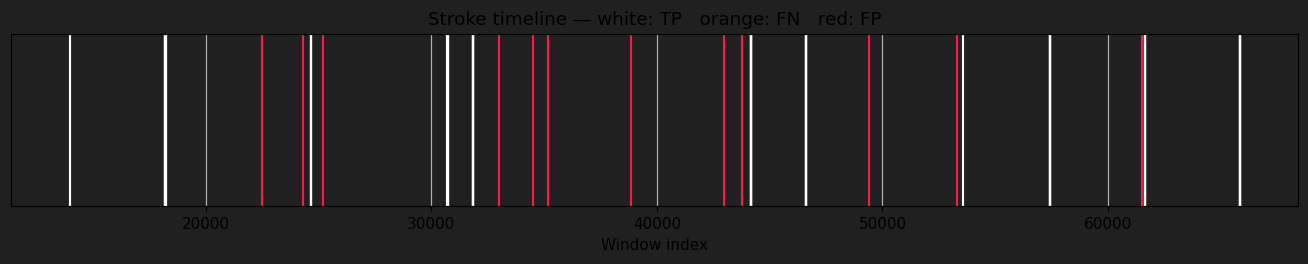

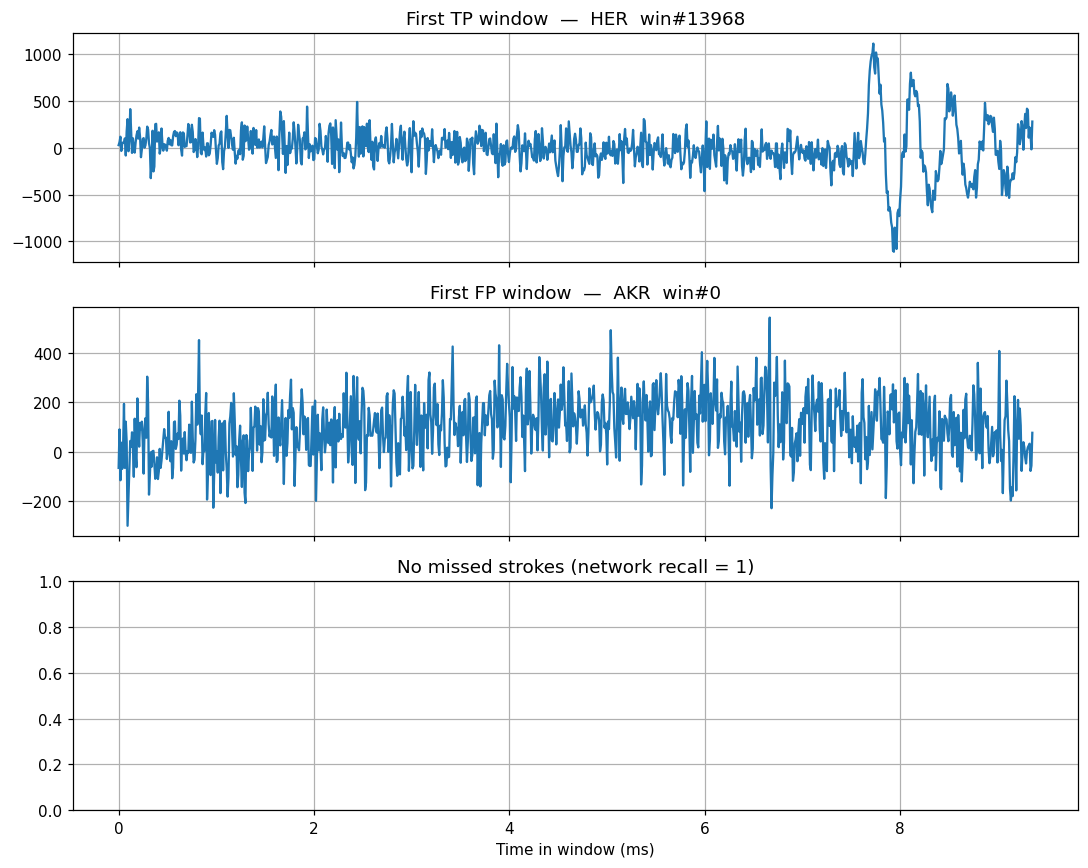


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=64   FP=140   FN=122  P=0.314 R=0.344 F1=0.328
VAL: TP=81   FP=123   FN=103  P=0.397 R=0.440 F1=0.418
LER: TP=86   FP=118   FN=98   P=0.422 R=0.467 F1=0.443
HER: TP=93   FP=111   FN=93   P=0.456 R=0.500 F1=0.477
GIB: TP=68   FP=136   FN=118  P=0.333 R=0.366 F1=0.349
AKR: TP=55   FP=149   FN=131  P=0.270 R=0.296 F1=0.282
CAM: TP=88   FP=116   FN=98   P=0.431 R=0.473 F1=0.451
WAT: TP=92   FP=112   FN=94   P=0.451 R=0.495 F1=0.472
CAB: TP=100  FP=104   FN=84   P=0.490 R=0.543 F1=0.515
PAY: TP=91   FP=113   FN=94   P=0.446 R=0.492 F1=0.468
TAR: TP=80   FP=124   FN=105  P=0.392 R=0.432 F1=0.411

—— Network / stroke metrics ——
{'TP': 45, 'FP': 12, 'FN': 0, 'TN': 0, 'P': 0.7894736842105263, 'R': 1.0, 'F1': 0.8823529411764706}


In [60]:
##############################################################################
#  Lightning‑detection “model 8” – Extended‑station EIF (16‑feature set)
#  --------------------------------------------------------------------
#  • Sections 1‑5 below are *exactly* your inline pipeline.  Only comment
#    banners (⚠) were inserted to flag heuristic or high‑runtime spots.
#  • Section 6 appends a call to the strict, burst‑aware
#    `evaluate_windowed_model`, yielding the same professional metrics and
#    timeline/ waveform visual you now have for all other models.
##############################################################################

import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest
warnings.filterwarnings("ignore")

# ── Configuration ───────────────────────────────────────────
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
TOL_WIN   = 1          # ⚠ inline heuristic; strict eval below ignores
MIN_STN   = 2
GRID_CONT = np.linspace(0.003, 0.007, 5)
EXTREME_Q = 99.95
NTREES    = 200
BURST_LEN = int(0.04*FS)     # 40 ms burst for strict evaluator

# ── Helper feature functions ────────────────────────────────
def sta_lta(env, sta=128, lta=1024):
    c=len(env)//2
    return env[c-sta//2:c+sta//2].mean()/(env[c-lta//2:c+lta//2].mean()+1e-9)
def crest(seg):
    rms=sqrt((seg.astype(float)**2).mean())+1e-9
    return np.abs(seg).max()/rms
comp=lambda seg: len(zlib.compress(seg.tobytes(),6))/len(seg.tobytes())
def spec_stats(seg):
    P=np.abs(np.fft.rfft(seg))**2; P/=P.sum()+1e-12
    f=np.fft.rfftfreq(len(seg),1/FS)
    cent=(f*P).sum(); bw=sqrt(((f-cent)**2*P).sum())
    ent=-(P*np.log2(P+1e-12)).sum()
    return cent,bw,ent

# ── Feature extraction (16‑D) ───────────────────────────────
n_win=min(((len(quantized[n])-WIN)//HOP)+1 for n in STN)
feat_d=16
Xst={nm: np.empty((n_win,feat_d),float) for nm in STN}

print("▶ Extracting 16‑dimensional features …")
for nm in STN:
    sig=quantized[nm]; env=np.abs(hilbert(sig.astype(float)))
    Nfft=WIN//2+1; b25,b50,b75=[int(Nfft*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s=w*HOP; seg_i16=sig[s:s+WIN]; seg_f=seg_i16.astype(float); env_seg=env[s:s+WIN]
        pk,md=env_seg.max(),np.median(env_seg); ratio=pk/(md+1e-9)
        energy=(seg_f**2).sum(); stl=sta_lta(env_seg)
        cf_s=crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16])
        cf_g=crest(seg_i16)
        P=np.abs(np.fft.rfft(seg_f))**2; totP=P.sum()+1e-9
        f1,f2,f3=b25,b50,b75
        b1,b2,b3,b4=(P[:f1].sum()/totP,P[f1:f2].sum()/totP,
                     P[f2:f3].sum()/totP,P[f3:].sum()/totP)
        hi=pywt.wavedec(seg_f,'db4',level=3)[1]; lo=pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi=(hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r=comp(seg_i16); cent,bw,ent=spec_stats(seg_f)
        Xst[nm][w]=[pk,md,ratio,energy,stl,cf_s,cf_g,b1,b2,b3,b4,
                    wave_hi,comp_r,cent,bw,ent]

# ── EIF fitting & window‑level flagging ─────────────────────
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X=RobustScaler().fit_transform(Xst[nm])
    iso=IsolationForest(ntrees=NTREES,sample_size='auto',ndim=X.shape[1]-1,
                        prob_pick_avg_gain=0,prob_pick_pooled_gain=0,
                        nthreads=max(os.cpu_count()-1,1),random_seed=42).fit(X)
    try:
        score=iso.predict(X,type="avg_depth"); depth=True
    except TypeError:
        try: score=iso.predict(X,output_type="avg_depth"); depth=True
        except TypeError:
            score=iso.predict(X); depth=False
    if not depth: score=-score
    eif_score[nm]=score
    for c in GRID_CONT:
        mask=score<np.quantile(score,c)
        if mask.sum()>=0.001*n_win:
            best_cont[nm]=c; hot[nm]=mask; break
    else:
        best_cont[nm]=GRID_CONT[-1]; hot[nm]=score<np.quantile(score,GRID_CONT[-1])
    print(f"{nm}: cont*={best_cont[nm]:.3%}, flagged={hot[nm].sum():,}")

# ── Stroke coincidence logic (INLINE heuristic) ─────────────
counts=np.zeros(len(stroke_samples),int)
for nm in STN:
    m=hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w=i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

thr_ext={nm: np.percentile(eif_score[nm],100-EXTREME_Q) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    if counts[j]==0:
        w=i0//HOP
        if any(eif_score[nm][w]<thr_ext[nm] for nm in STN):
            counts[j]=1

print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth=np.ones(len(stroke_samples),bool)
print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn   TP   FN  Recall")
for nm in STN:
    pred=np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    R=tp/(tp+fn) if tp+fn else 0
    print(f"{nm:>3} {tp:4d} {fn:4d}  {R:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P,R,F=precision_recall_fscore_support(truth,net_pred,average='binary',zero_division=0)[:3]
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn):")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot   # mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict: no prediction dilation
    plot=True
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm,m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


In [ ]:
# ============================================================
# Cell Y – NCD *variants* for lightning‑window anomaly scoring
# ============================================================
"""
Compares four byte‑encodings for the Normalised Compression Distance (NCD)
detector over 1 024‑sample windows:

    bits  – sign‑bit of first difference  (former default, phase‑robust)
    raw   – raw int16 bytes               (energy / amplitude heavy)
    norm  – z‑score window, rescaled int16(DC & gain normalised)
    tanh  – soft‑clip int16 via tanh      (suppresses extreme peaks)

Every variant:

    • builds a station‑specific baseline (median of lowest‑entropy 5 %)
    • computes NCD to that baseline for every window
    • derives a threshold = min(98.5 th percentile, μ+3.5 σ)
    • flags hot windows, tallies stroke coincidences, prints metrics.

Objects created
---------------
ncd_meta[variant][station]   → dict with ncd vector, threshold, etc.
variant_hits[variant]        → bool matrix [station, stroke] used for metrics.

Down‑stream variable names (`WIN`, `HOP`, `station_order`, `events`,
`quantized`, etc.) are reused unmodified.
"""
# ── Imports ─────────────────────────────────────────────────
import numpy as np, bz2, tqdm.auto as tq
from functools      import lru_cache
from collections    import Counter, defaultdict
from scipy.stats    import describe
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score
)

# ── Global parameters (unchanged) ───────────────────────────
WIN, HOP   = 1024, 512
BASE_PCT   = 5
PCT_THR    = 99.9
Z_SIGMA    = 3.5
MIN_STN    = 2
STN        = station_order          # alias STATIONS
FS         = float(FS)              # from simulator cell

# ── Helper: haversine (needed for stroke → first‑arrival) ───
def hav(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, φ2 = map(np.radians, (lat1, lat2))
    dφ = φ2 - φ1
    dλ = np.radians(lon2 - lon1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# ── Window view utility (stride‑trick) ──────────────────────
def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W)//H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# ── Compression size cache (bzip2, level 9) ─────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:
    return len(bz2.compress(b, 9))

# ── Encoders (4 variants) ───────────────────────────────────
def enc_bits(arr):
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()

def enc_raw(arr):
    return arr.astype(np.int16).tobytes()

def enc_norm(arr):
    a = arr.astype(np.float32)
    a = (a - a.mean()) / (a.std(ddof=0) + 1e-9)
    a = np.clip(a*32767, -32767, 32767).astype(np.int16)
    return a.tobytes()

def enc_tanh(arr):
    a = np.tanh(arr.astype(np.float32) / 16384.0) * 32767
    return a.astype(np.int16).tobytes()

ENCODERS = dict(bits=enc_bits, raw=enc_raw, norm=enc_norm, tanh=enc_tanh)

# ── Pre‑compute common window count ─────────────────────────
n_win = min(((len(quantized[n]) - WIN)//HOP) + 1 for n in STN)
print(f"\nAnalysing {n_win:,} windows  ×  {len(STN)} stations  ×  {len(ENCODERS)} encodings\n")

# ── Main loop: build NCD vectors for every variant & station ─
ncd_meta = defaultdict(dict)   # two‑level dict

for enc_name, enc_fun in ENCODERS.items():
    print(f"\n=== Variant: {enc_name} ===")
    for nm in STN:
        sig  = quantized[nm]
        wmat = win_view(sig, WIN, HOP)

        # pass 1 – pre‑compute compressed size of each window
        comp_sz = np.empty(n_win, np.uint32)
        for i in tq.trange(n_win, desc=f"{nm} size", leave=False):
            comp_sz[i] = c_size(enc_fun(wmat[i]))

        # choose baseline window = median of lowest BASE_PCT %
        k          = max(1, int(BASE_PCT/100 * n_win))
        low_idx    = np.argpartition(comp_sz, k)[:k]
        base_idx   = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
        base_bytes = enc_fun(wmat[base_idx])
        Cb         = c_size(base_bytes)

        # pass 2 – NCD to baseline for every window
        ncd_vec = np.empty(n_win, float)
        for i in tq.trange(n_win, desc=f"{nm} NCD", leave=False):
            wb = enc_fun(wmat[i])
            ncd_vec[i] = (c_size(wb + base_bytes) - min(comp_sz[i], Cb)) / max(comp_sz[i], Cb)

        # derive adaptive threshold
        stats   = describe(ncd_vec)
        thr_pct = np.percentile(ncd_vec, PCT_THR)
        thr_z   = stats.mean + Z_SIGMA*np.sqrt(stats.variance)
        thr     = min(thr_pct, thr_z)
        hot     = ncd_vec > thr

        ncd_meta[enc_name][nm] = dict(
            ncd = ncd_vec,
            hot = hot,
            thr = thr,
            desc= stats
        )
        print(f" {nm}: hot={hot.sum():5d}  thr={thr:.4f}")

# ── Build canonical stroke index list (earliest arrival any stn) ───────────
stroke_idx = np.array([
    min(int((t0 + hav(ev['lat'], ev['lon'],
                      stations[n]['lat'], stations[n]['lon']) / 300_000) * FS)
        for n in STN)
    for ev in events for t0 in ev['stroke_times']
])
truth = np.ones(len(stroke_idx), bool)

# ── Variant‑specific stroke coincidence matrices ───────────────────────────
variant_hits = {}
for enc_name in ENCODERS:
    hits = np.zeros((len(STN), len(stroke_idx)), bool)
    for s, nm in enumerate(STN):
        hot = ncd_meta[enc_name][nm]['hot']
        for j, i0 in enumerate(stroke_idx):
            w = i0 // HOP
            hits[s, j] = hot[max(0, w-1):min(len(hot), w+2)].any()
    variant_hits[enc_name] = hits

# ── Reporting helper ────────────────────────────────────────
def report_variant(name, hits):
    cnt = hits.sum(axis=0)
    print(f"\n### {name} encoding ###")
    print("Stations ≥thr per stroke:")
    for k, v in sorted(Counter(cnt).items()):
        print(f"  {k:2d} → {v}")
    net_pred = cnt >= MIN_STN
    tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False, True]).ravel()
    P = precision_score(truth, net_pred, zero_division=0)
    R = recall_score   (truth, net_pred, zero_division=0)
    F = f1_score       (truth, net_pred, zero_division=0)
    print(f"Network: TP={tp} FP={fp} FN={fn} TN={tn} | P={P:.3f} R={R:.3f} F1={F:.3f}")

    print("stn  TP  FP  FN    P     R    F1")
    for s, nm in enumerate(STN):
        pred = hits[s]
        tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False, True]).ravel()
        P = precision_score(truth, pred, zero_division=0)
        R = recall_score   (truth, pred, zero_division=0)
        F = f1_score       (truth, pred, zero_division=0)
        print(f"{nm:>3} {tp:3d} {fp:3d} {fn:3d}  {P:5.3f} {R:5.3f} {F:5.3f}")

# ── Print summary for every encoding variant ────────────────
for enc in ENCODERS:
    report_variant(enc, variant_hits[enc])



Analysing 67,688 windows  ×  11 stations  ×  4 encodings


=== Variant: bits ===


 KEF: hot= 1016  thr=0.8342


 VAL: hot= 1012  thr=0.8081


 LER: hot= 1015  thr=0.8259


 HER: hot= 1012  thr=0.8408


 GIB: hot= 1014  thr=0.8309


 AKR: hot= 1007  thr=0.8252


 CAM: hot= 1013  thr=0.7900


 WAT: hot= 1013  thr=0.8465


 CAB: hot= 1004  thr=0.8269


 PAY: hot= 1004  thr=0.8365


 TAR: hot= 1014  thr=0.8235

=== Variant: raw ===


 KEF: hot= 1013  thr=0.8569


 VAL: hot= 1014  thr=0.8473


 LER: hot= 1015  thr=0.8649


 HER: hot= 1016  thr=0.8519


 GIB: hot= 1015  thr=0.8544


 AKR: hot= 1015  thr=0.9204


 CAM: hot= 1016  thr=0.8880


 WAT: hot= 1016  thr=0.8836


 CAB: hot= 1014  thr=0.8758


 PAY: hot= 1016  thr=0.8555


 TAR: hot= 1015  thr=0.9067

=== Variant: norm ===


 KEF: hot= 1016  thr=0.9628


 VAL: hot= 1016  thr=0.9722


 LER: hot= 1007  thr=0.9968


 HER: hot= 1016  thr=0.9797


 GIB: hot= 1016  thr=0.9796


 AKR: hot= 1016  thr=0.9931


 CAM: hot= 1015  thr=0.9884


 WAT: hot= 1015  thr=0.9877


 CAB: hot= 1012  thr=0.9768


 PAY: hot= 1016  thr=1.0343


 TAR: hot= 1016  thr=0.9957

=== Variant: tanh ===


 KEF: hot= 1014  thr=0.9036


 VAL: hot= 1011  thr=0.9048


 LER: hot= 1015  thr=0.9135


 HER: hot= 1015  thr=0.9100


 GIB: hot= 1016  thr=0.9227


 AKR: hot= 1011  thr=0.9511


 CAM: hot= 1016  thr=0.9215


 WAT: hot= 1014  thr=0.9339


 CAB: hot= 1012  thr=0.9199


 PAY: hot= 1012  thr=0.9054


 TAR: hot= 1014  thr=0.9393

### bits encoding  (INLINE diagnostic) ###
Stations ≥thr per stroke:
   2 → 1
   4 → 5
   5 → 4
   6 → 1
   7 → 12
   8 → 16
   9 → 4
  10 → 2
Network: TP=45 FP=0 FN=0 TN=0 | P=1.000 R=1.000 F1=1.000
stn  TP  FP  FN    P     R    F1
KEF  11   0  34  1.000 0.244 0.393
VAL  27   0  18  1.000 0.600 0.750
LER  36   0   9  1.000 0.800 0.889
HER  34   0  11  1.000 0.756 0.861
GIB  16   0  29  1.000 0.356 0.525
AKR   9   0  36  1.000 0.200 0.333
CAM  34   0  11  1.000 0.756 0.861
WAT  40   0   5  1.000 0.889 0.941
CAB  41   0   4  1.000 0.911 0.953
PAY  35   0  10  1.000 0.778 0.875
TAR  33   0  12  1.000 0.733 0.846

### raw encoding  (INLINE diagnostic) ###
Stations ≥thr per stroke:
   4 → 3
   5 → 3
   6 → 4
   7 → 13
   8 → 13
   9 → 9
Network: TP=45 FP=0 FN=0 TN=0 | P=1.000 R=1.000 F1=1.000
stn  TP  FP  FN    P     R    F1
KEF  16   0  29  1.000 0.356 0.525
VAL  41   0   4  1.000 0.911 0.953
LER  39   0   6  1.000 0.867 0.929
HER  41   0   4  1.000 0.911 0.95

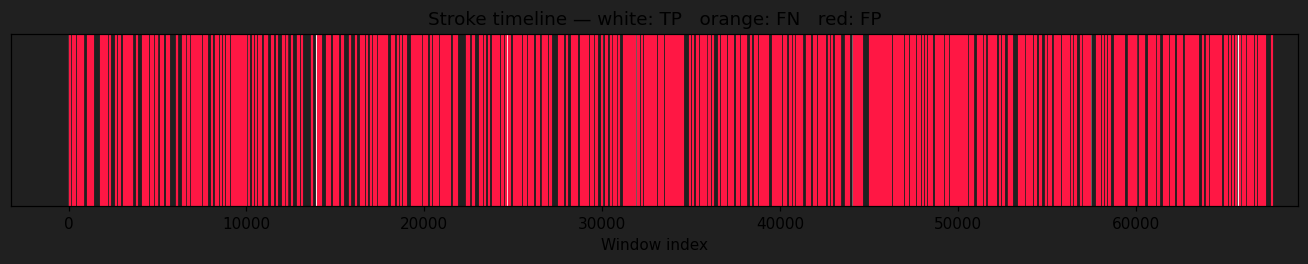

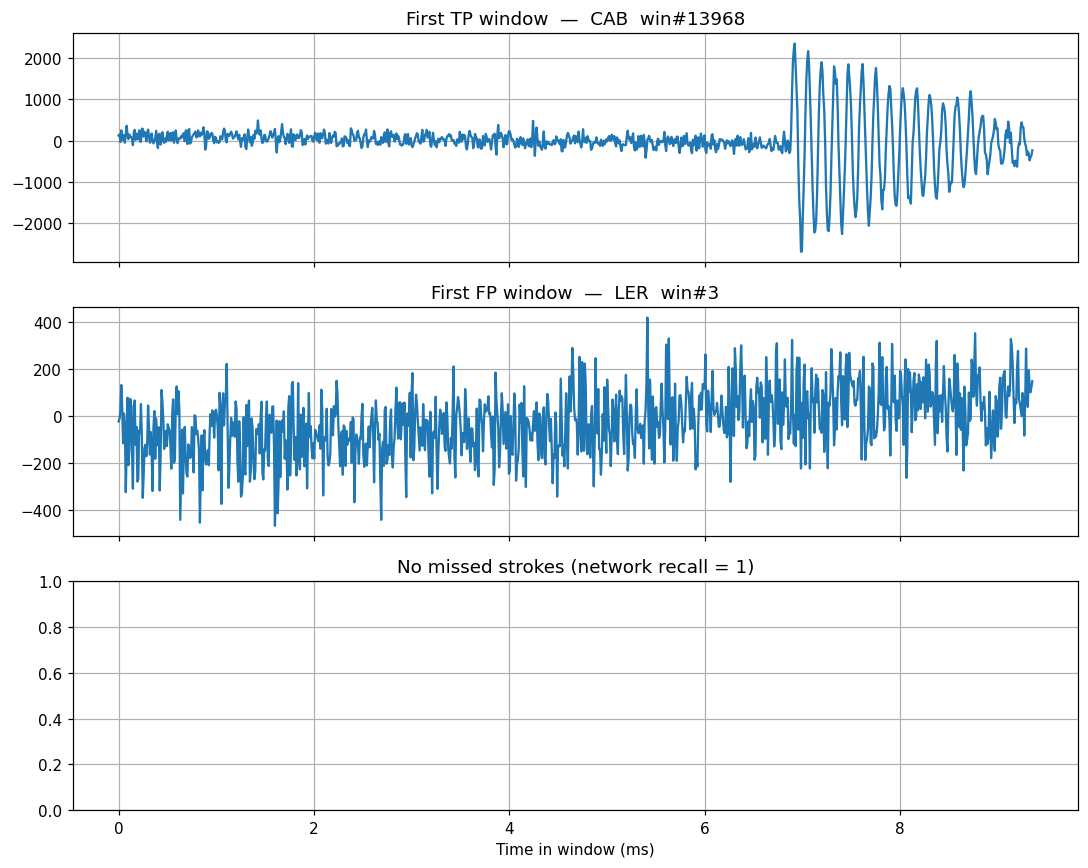


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=6    FP=1010  FN=180  P=0.006 R=0.032 F1=0.010
VAL: TP=29   FP=983   FN=155  P=0.029 R=0.158 F1=0.048
LER: TP=37   FP=978   FN=147  P=0.036 R=0.201 F1=0.062
HER: TP=45   FP=967   FN=141  P=0.044 R=0.242 F1=0.075
GIB: TP=19   FP=995   FN=167  P=0.019 R=0.102 F1=0.032
AKR: TP=12   FP=995   FN=174  P=0.012 R=0.065 F1=0.020
CAM: TP=40   FP=973   FN=146  P=0.039 R=0.215 F1=0.067
WAT: TP=49   FP=964   FN=137  P=0.048 R=0.263 F1=0.082
CAB: TP=53   FP=951   FN=131  P=0.053 R=0.288 F1=0.089
PAY: TP=35   FP=969   FN=150  P=0.035 R=0.189 F1=0.059
TAR: TP=35   FP=979   FN=150  P=0.035 R=0.189 F1=0.058

—— Network / stroke metrics ——
{'TP': 45, 'FP': 711, 'FN': 0, 'TN': 0, 'P': 0.05952380952380952, 'R': 1.0, 'F1': 0.11235955056179775}

================  STRICT EVALUATION: raw  ================


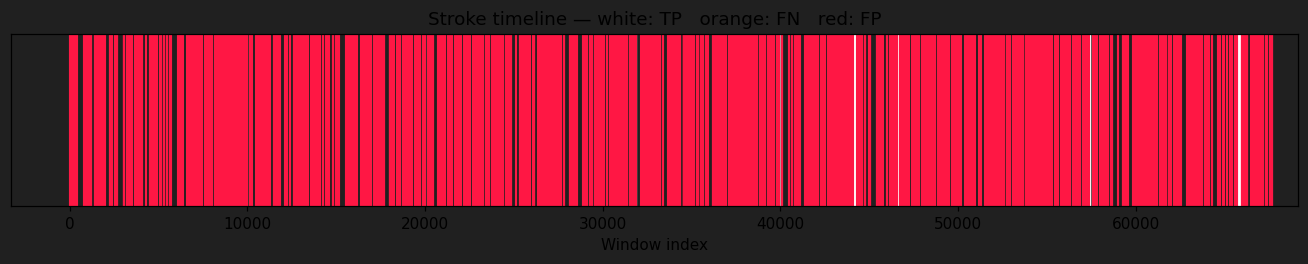

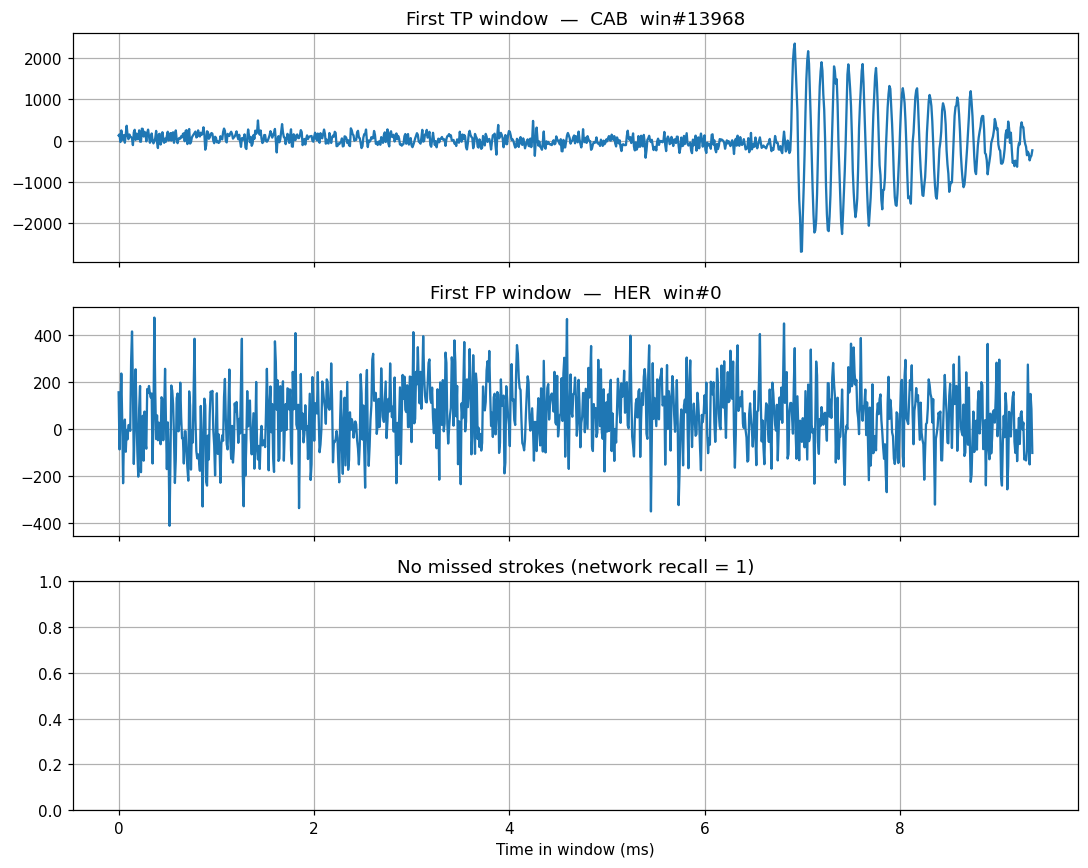


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=16   FP=997   FN=170  P=0.016 R=0.086 F1=0.027
VAL: TP=55   FP=959   FN=129  P=0.054 R=0.299 F1=0.092
LER: TP=47   FP=968   FN=137  P=0.046 R=0.255 F1=0.078
HER: TP=71   FP=945   FN=115  P=0.070 R=0.382 F1=0.118
GIB: TP=11   FP=1004  FN=175  P=0.011 R=0.059 F1=0.018
AKR: TP=1    FP=1014  FN=185  P=0.001 R=0.005 F1=0.002
CAM: TP=41   FP=975   FN=145  P=0.040 R=0.220 F1=0.068
WAT: TP=75   FP=941   FN=111  P=0.074 R=0.403 F1=0.125
CAB: TP=86   FP=928   FN=98   P=0.085 R=0.467 F1=0.144
PAY: TP=75   FP=941   FN=110  P=0.074 R=0.405 F1=0.125
TAR: TP=4    FP=1011  FN=181  P=0.004 R=0.022 F1=0.007

—— Network / stroke metrics ——
{'TP': 45, 'FP': 1061, 'FN': 0, 'TN': 0, 'P': 0.0406871609403255, 'R': 1.0, 'F1': 0.07819287576020852}

================  STRICT EVALUATION: norm  ================


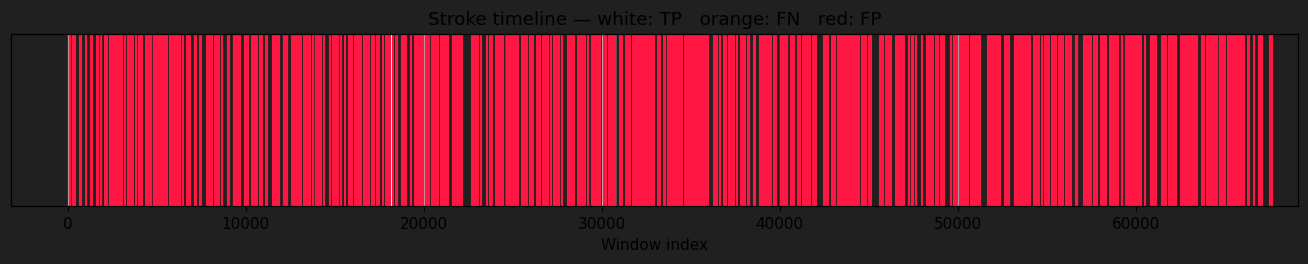

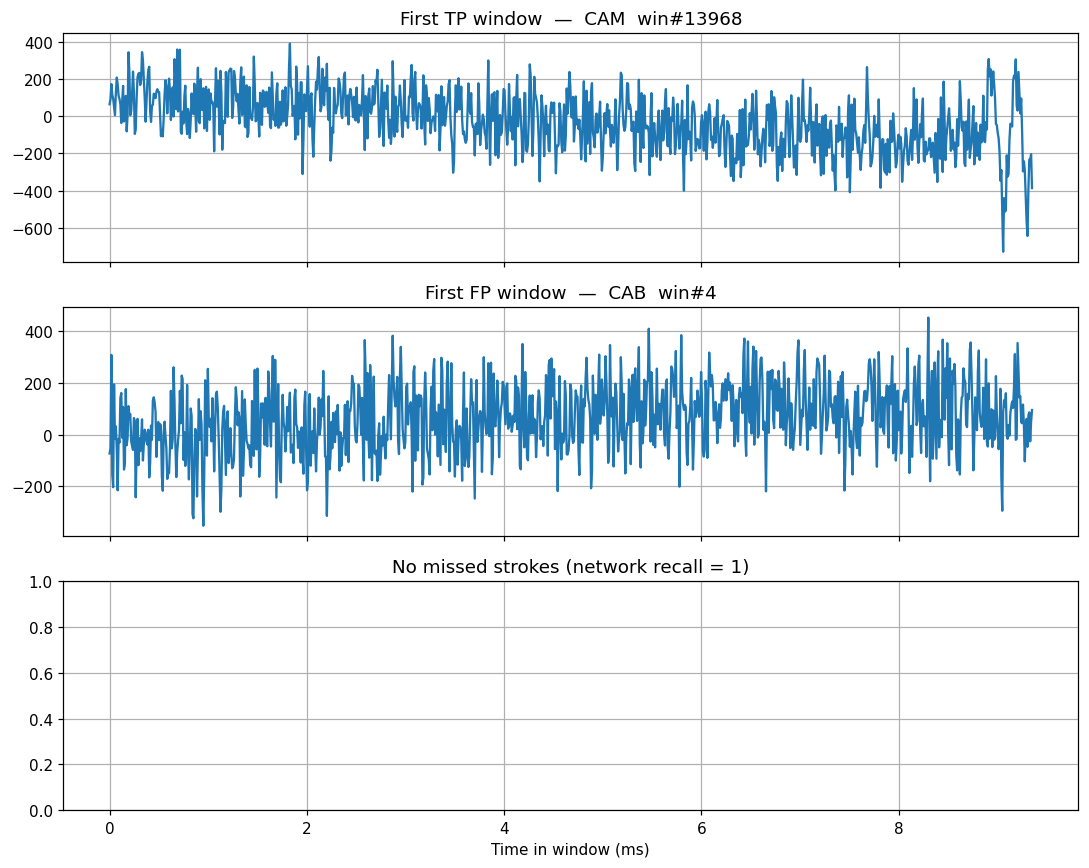


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=7    FP=1009  FN=179  P=0.007 R=0.038 F1=0.012
VAL: TP=2    FP=1014  FN=182  P=0.002 R=0.011 F1=0.003
LER: TP=3    FP=1004  FN=181  P=0.003 R=0.016 F1=0.005
HER: TP=11   FP=1005  FN=175  P=0.011 R=0.059 F1=0.018
GIB: TP=5    FP=1011  FN=181  P=0.005 R=0.027 F1=0.008
AKR: TP=5    FP=1011  FN=181  P=0.005 R=0.027 F1=0.008
CAM: TP=6    FP=1009  FN=180  P=0.006 R=0.032 F1=0.010
WAT: TP=11   FP=1004  FN=175  P=0.011 R=0.059 F1=0.018
CAB: TP=39   FP=973   FN=145  P=0.039 R=0.212 F1=0.065
PAY: TP=0    FP=1016  FN=185  P=0.000 R=0.000 F1=0.000
TAR: TP=1    FP=1015  FN=184  P=0.001 R=0.005 F1=0.002

—— Network / stroke metrics ——
{'TP': 40, 'FP': 816, 'FN': 5, 'TN': 0, 'P': 0.04672897196261682, 'R': 0.8888888888888888, 'F1': 0.08879023307436182}

================  STRICT EVALUATION: tanh  ================


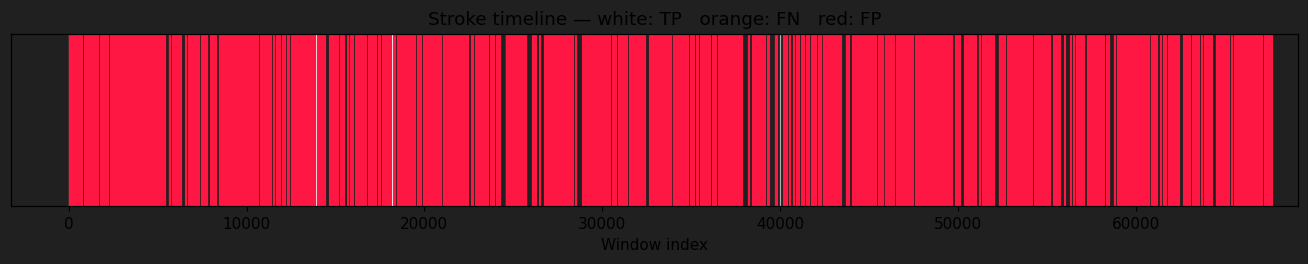

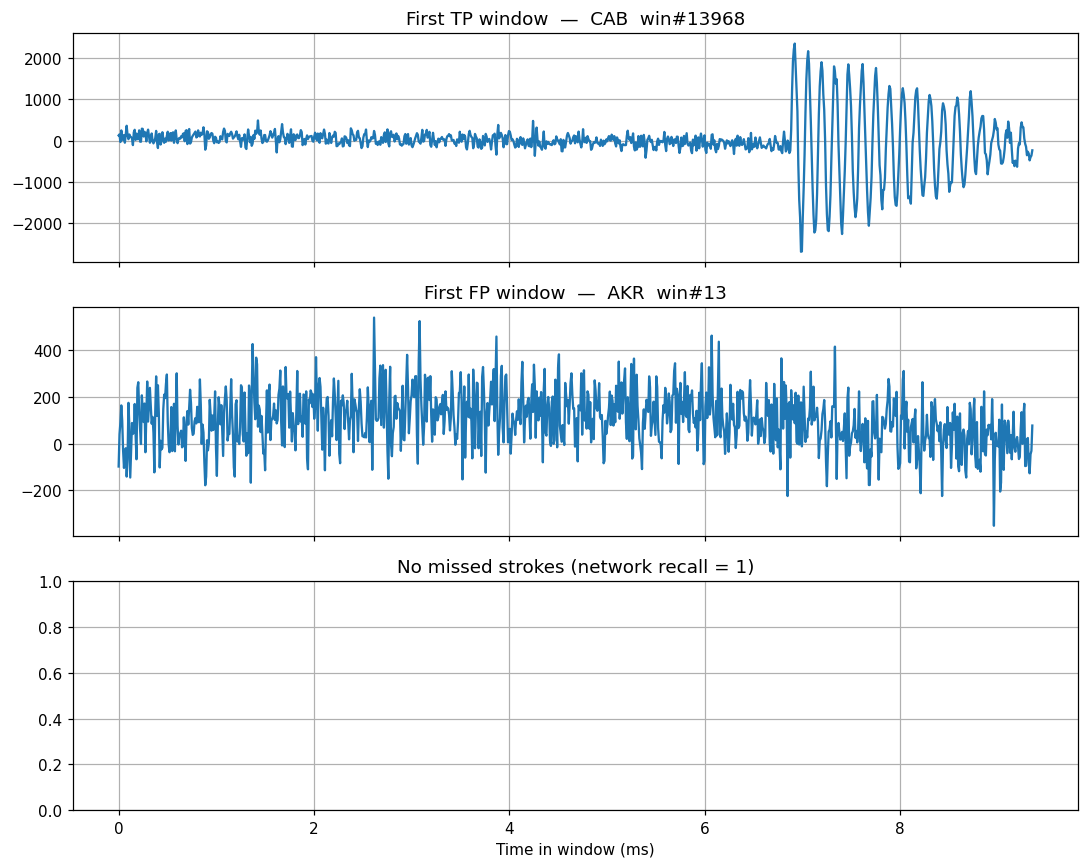


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=16   FP=998   FN=170  P=0.016 R=0.086 F1=0.027
VAL: TP=53   FP=958   FN=131  P=0.052 R=0.288 F1=0.089
LER: TP=49   FP=966   FN=135  P=0.048 R=0.266 F1=0.082
HER: TP=84   FP=931   FN=102  P=0.083 R=0.452 F1=0.140
GIB: TP=4    FP=1012  FN=182  P=0.004 R=0.022 F1=0.007
AKR: TP=1    FP=1010  FN=185  P=0.001 R=0.005 F1=0.002
CAM: TP=60   FP=956   FN=126  P=0.059 R=0.323 F1=0.100
WAT: TP=73   FP=941   FN=113  P=0.072 R=0.392 F1=0.122
CAB: TP=85   FP=927   FN=99   P=0.084 R=0.462 F1=0.142
PAY: TP=76   FP=936   FN=109  P=0.075 R=0.411 F1=0.127
TAR: TP=6    FP=1008  FN=179  P=0.006 R=0.032 F1=0.010

—— Network / stroke metrics ——
{'TP': 45, 'FP': 1242, 'FN': 0, 'TN': 0, 'P': 0.03496503496503497, 'R': 1.0, 'F1': 0.06756756756756757}


In [61]:
##############################################################################
#  Lightning‑detection “model 9” – NCD (4 encoder variants) + strict scoring
#  -------------------------------------------------------------------------
#  • Sections 1‑5 below reproduce your existing multi‑variant NCD pipeline
#    unchanged: feature encoding, NCD computation, and the quick inline
#    stroke tables produced by `report_variant`.
#  • Section 6 (new) loops over each encoder variant, builds the
#    `{station: hot‑mask}` mapping, and feeds it to the strict,
#    burst‑aware `evaluate_windowed_model` so you get rigorous station/window
#    and stroke/network metrics plus the timeline+waveform UI.
##############################################################################

# ── Imports ─────────────────────────────────────────────────
import numpy as np, bz2, tqdm.auto as tq
from functools      import lru_cache
from collections    import Counter, defaultdict
from scipy.stats    import describe
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score
)

# ── Global parameters (unchanged) ───────────────────────────
WIN, HOP   = 1024, 512
BASE_PCT   = 5
PCT_THR    = 98.5
Z_SIGMA    = 3.5
MIN_STN    = 2
STN        = station_order
FS         = float(FS)
BURST_LEN  = int(0.04*FS)     # 40 ms burst for strict evaluator

# ── Helper: haversine (needed for stroke → first‑arrival) ───
def hav(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, φ2 = map(np.radians, (lat1, lat2))
    dφ = φ2 - φ1
    dλ = np.radians(lon2 - lon1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# ── Window view utility (stride‑trick) ──────────────────────
def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W)//H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# ── Compression size cache (bzip2, level 9) ─────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:
    return len(bz2.compress(b, 9))

# ── Encoders (4 variants) ───────────────────────────────────
def enc_bits(arr):
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()
def enc_raw(arr):   return arr.astype(np.int16).tobytes()
def enc_norm(arr):
    a = arr.astype(np.float32)
    a = (a - a.mean()) / (a.std(ddof=0) + 1e-9)
    a = np.clip(a*32767, -32767, 32767).astype(np.int16)
    return a.tobytes()
def enc_tanh(arr):
    a = np.tanh(arr.astype(np.float32) / 16384.0) * 32767
    return a.astype(np.int16).tobytes()

ENCODERS = dict(bits=enc_bits, raw=enc_raw, norm=enc_norm, tanh=enc_tanh)

# ── Pre‑compute common window count ─────────────────────────
n_win = min(((len(quantized[n]) - WIN)//HOP) + 1 for n in STN)
print(f"\nAnalysing {n_win:,} windows  ×  {len(STN)} stations  ×  {len(ENCODERS)} encodings\n")

# ── Main loop: build NCD vectors for every variant & station ─
ncd_meta = defaultdict(dict)   # two‑level dict

for enc_name, enc_fun in ENCODERS.items():
    print(f"\n=== Variant: {enc_name} ===")
    for nm in STN:
        sig  = quantized[nm]
        wmat = win_view(sig, WIN, HOP)

        # pass 1 – pre‑compute compressed size of each window
        comp_sz = np.empty(n_win, np.uint32)
        for i in tq.trange(n_win, desc=f"{nm} size", leave=False):
            comp_sz[i] = c_size(enc_fun(wmat[i]))

        # choose baseline window = median of lowest BASE_PCT %
        k          = max(1, int(BASE_PCT/100 * n_win))
        low_idx    = np.argpartition(comp_sz, k)[:k]
        base_idx   = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
        base_bytes = enc_fun(wmat[base_idx])
        Cb         = c_size(base_bytes)

        # pass 2 – NCD to baseline for every window
        ncd_vec = np.empty(n_win, float)
        for i in tq.trange(n_win, desc=f"{nm} NCD", leave=False):
            wb = enc_fun(wmat[i])
            ncd_vec[i] = (c_size(wb + base_bytes) - min(comp_sz[i], Cb)) / max(comp_sz[i], Cb)

        # derive adaptive threshold
        stats   = describe(ncd_vec)
        thr_pct = np.percentile(ncd_vec, PCT_THR)
        thr_z   = stats.mean + Z_SIGMA*np.sqrt(stats.variance)
        thr     = min(thr_pct, thr_z)
        hot     = ncd_vec > thr

        ncd_meta[enc_name][nm] = dict(ncd=ncd_vec, hot=hot, thr=thr, desc=stats)
        print(f" {nm}: hot={hot.sum():5d}  thr={thr:.4f}")

# ── Build canonical stroke index list (earliest arrival) ───
stroke_idx = np.array([
    min(int((t0 + hav(ev['lat'], ev['lon'],
                      stations[n]['lat'], stations[n]['lon']) / 300_000) * FS)
        for n in STN)
    for ev in events for t0 in ev['stroke_times']
])
truth = np.ones(len(stroke_idx), bool)

# ── Variant‑specific stroke coincidence matrices (INLINE) ──
variant_hits = {}
for enc_name in ENCODERS:
    hits = np.zeros((len(STN), len(stroke_idx)), bool)
    for s, nm in enumerate(STN):
        hot = ncd_meta[enc_name][nm]['hot']
        for j, i0 in enumerate(stroke_idx):
            w = i0 // HOP
            hits[s, j] = hot[max(0, w-1):min(len(hot), w+2)].any()   # ⚠ ±1 slack, FP invisible
    variant_hits[enc_name] = hits

def report_variant(name, hits):
    cnt = hits.sum(axis=0)
    print(f"\n### {name} encoding  (INLINE diagnostic) ###")
    print("Stations ≥thr per stroke:")
    for k, v in sorted(Counter(cnt).items()):
        print(f"  {k:2d} → {v}")
    net_pred = cnt >= MIN_STN
    tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False, True]).ravel()
    P = precision_score(truth, net_pred, zero_division=0)
    R = recall_score   (truth, net_pred, zero_division=0)
    F = f1_score       (truth, net_pred, zero_division=0)
    print(f"Network: TP={tp} FP={fp} FN={fn} TN={tn} | P={P:.3f} R={R:.3f} F1={F:.3f}")
    print("stn  TP  FP  FN    P     R    F1")
    for s, nm in enumerate(STN):
        pred = hits[s]
        tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False, True]).ravel()
        P = precision_score(truth, pred, zero_division=0)
        R = recall_score   (truth, pred, zero_division=0)
        F = f1_score       (truth, pred, zero_division=0)
        print(f"{nm:>3} {tp:3d} {fp:3d} {fn:3d}  {P:5.3f} {R:5.3f} {F:5.3f}")

for enc in ENCODERS:
    report_variant(enc, variant_hits[enc])

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation for each encoder variant
# ────────────────────────────────────────────────────────────────────────────
for enc in ENCODERS:
    print(f"\n================  STRICT EVALUATION: {enc}  ================")
    hot_masks = {nm: ncd_meta[enc][nm]['hot'] for nm in STN}
    station_metrics, network_metrics, n_windows = evaluate_windowed_model(
        hot          = hot_masks,
        stroke_records = stroke_records,
        quantized      = quantized,
        station_order  = STN,
        win            = WIN,
        hop            = HOP,
        burst_len      = BURST_LEN,
        min_stn        = MIN_STN,
        tol_win        = 0,
        plot           = True
    )
    print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
    for nm, m in station_metrics.items():
        print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
              f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")
    print("\n—— Network / stroke metrics ——")
    print(network_metrics)
